In [1]:
#!pip install nimfa
#!pip install implicit

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

#import torch
#import torch.nn as nn
#import torch.nn.parallel
#import torch.optim as optim
#import torch.utils.data

#from torch.nn import functional
#from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import xml.etree.ElementTree as ET

import geopandas as gpd

import copy 

import json

#binary factorization
import nimfa

from sklearn.decomposition import NMF
import scipy.sparse as sparse
import implicit

#extract number from str
import re

In [2]:
#process the fcd data
path = "G:/My Drive/2021/Bias/sumo_simulation/"
os.chdir(path)
#os.listdir()

raw_dt_path = []
for i in os.listdir():
    if len(i) == 12 and '2017' in i:
        raw_dt_path.append(i)
print(raw_dt_path)

['20170404.csv', '20170405.csv', '20170406.csv', '20170411.csv', '20170412.csv', '20170413.csv', '20170418.csv', '20170419.csv', '20170420.csv', '20170426.csv', '20170427.csv', '20170425.csv']


In [3]:
#read_csv
def get_data(raw_path):
    idx = 0
        
    if len(raw_path) > 1:
        for path in raw_path:
            if idx == 0:
                dt = pd.read_csv(path)
                idx = 1
            else:
                dt_cur = pd.read_csv(path)
                dt = pd.concat([dt, dt_cur])
    else:
        dt = pd.read_csv(path)
            
    get_hr = lambda x: int(x.split(':')[0])
    get_min = lambda x: int(x.split(':')[1])
    dt['hr'] = dt['time'].apply(get_hr)
    dt['min'] = dt['time'].apply(get_min)
    return(dt)

def get_time_variationbyzone(data, taz, time_loc, plot_index):
    data_taz = data[data['taz']==taz]
    data_taz = data_taz.sort_values(by=['hr', 'min'])
    data_taz = data_taz.groupby(by=['hr', 'min']).sum()
    
    data_taz.reset_index(inplace=True)
    data_taz = data_taz[['hr','min','sum']]
    #data_taz
    obs_sum = np.zeros((len(time_loc)))
    hr_ = data_taz['hr'].values
    min_ = data_taz['min'].values
    sum_val = data_taz['sum'].values
    
    for i in range(len(hr_)):
        obs_sum[time_loc[str(hr_[i])+'_'+str(min_[i])]] = sum_val[i]
    #use obs/max(obs) instead of obs/sum(obs) 
    obs_per = obs_sum/(np.max(obs_sum))
    
    if plot_index == True:
        fig = plt.figure(taz)
        plt.plot(obs_sum)
    return(obs_per)

def get_sim_obs_ts(fcd_out, taz_time_per, avg_per, return_sim=True):
    taz_ = fcd_out['taz'].values
    time_5 = fcd_out['time_5'].values
    per_ts = []
    for i in range(len(taz_)):
        if taz_[i] in taz_time_per:
            per_ts.append(taz_time_per[taz_[i]][time_5[i]])
        else:
            per_ts.append(avg_per[time_5[i]])
    if return_sim == True:
        sim_obs_ts = [] 
        for i in range(len(per_ts)):
            sim_obs_ts.append(np.random.binomial(1, per_ts[i], 1)[0])
        return(sim_obs_ts)
    else:
        return(per_ts)
    

#convert dt to matrix
def read_fcd(fcd_dt_path, app_based_data):
    fcd_out = pd.read_csv(fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']
    fcd_out.taz = fcd_out.taz.astype('int')
    
    
    revise_dt = lambda x: x.split('-')[0] if '-' in x else x
    get_sample_index = lambda x: x.split('-')[2] if '-' in x else 3
    fcd_out['reids'] = fcd_out['id'].apply(revise_dt)
    fcd_out['sample_index'] = (fcd_out['id'].apply(get_sample_index)).astype(int)
    
    fcd_out['time'] = fcd_out['time'].astype('int')
    fcd_out['hr'] = (fcd_out['time'].values/3600).astype(int)
    fcd_out['minus'] = ((fcd_out['time'].values- fcd_out['hr'].values*3600)/60).astype(int)
    fcd_out['time_30'] = (fcd_out['time']/30).astype(int)
    fcd_out['time_5'] = (fcd_out['time']/300).astype(int)
    
    print('num id', len(np.unique(fcd_out.reids)))

    #fcd_out.sort_values(by=['time', 'taz'])
    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+(fcd_out['time_5']).astype(str)

    time_ = np.unique((fcd_out['time']/300).astype(int))
    
    if app_based_data == True:
        #sample index 0: non app-based samples, 1: app=based samples, 3: transit
        #fcd_out.groupby(by=['sample_index']).size()
        #sample_index 0    1714901, 1     572267, 3     180802
        return(fcd_out[fcd_out['sample_index']!=0])
    else:
        return(fcd_out)
    
def getfcdnorigindt(fcd_out, savepath, 
                    data_obs, time_loc, taz_time_per, avg_per, 
                    save_index):
    #get one day data (use 5 min as the time interval)
    #fcd_out = fcd_out[fcd_out['time_5']<288]
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.reids):
        newuser_[i] = index_
        index_ += 1    
    ## fcd output processing
    #delete the data exceeds the 24-hr daily period
    #fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    fcd_out.time = fcd_out.time.astype('int')

    obs = data_obs.groupby(by=['time']).size().values
    obs_per = obs/max(obs)

    sample_ct = lambda x: np.random.binomial(1, obs_per[x], 1)[0]

    fcd_out['sim_obs'] = fcd_out['time_5'].apply(sample_ct)

    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)
    
    sim_obs = get_sim_obs_ts(fcd_out, taz_time_per, avg_per, True)
    fcd_out['sim_obs_ts'] = sim_obs

    #simulated observations based on time variation
    print('sim based on time', 
          np.count_nonzero(fcd_out['sim_obs'])/fcd_out.shape[0])

    #simulated observations based on time and spatial variation
    print('sim based on time and spatial',
          np.count_nonzero(fcd_out['sim_obs_ts'])/fcd_out.shape[0])
    
    return(fcd_out)

#fcd_out = read_fcd(fcd_dt_path, app_based_data)
def run_sim(csv_path, fcd_out, savepath, save_index=False, plot_index=True):
    data_obs = pd.read_csv(csv_path, header=0)
    print('app based data', data_obs.head(3))
    
    newids = np.unique(data_obs.newid)
    newid_ = {}
    index_ = 0
    for i in range(len(newids)):
        newid_[newids[i]] = index_
        index_ += 1
        
    get_hr = lambda x: x.split(':')[0]
    get_min = lambda x: x.split(':')[1]

    hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
    min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
    taz_ = np.unique(data_obs['taz'])

    data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
    data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)
    
    index_ = 0
    lt_loc = {}
    for taz in taz_:
        for h in hr_:
            for m in min_:
                lt_loc['4_'+str(h)+'_'+str(m)+'_'+str(taz)] = index_
                index_ += 1
    obs_mx = np.zeros((len(newid_), len(lt_loc)))

    newid_col = data_obs.newid.values
    key_col = data_obs.key.values
    ct_col = data_obs['sum'].values

    for i in range(len(newid_col)):
        obs_mx[newid_[newid_col[i]]][lt_loc[key_col[i]]] = 1

    total_ct = np.sum(obs_mx, axis=0)
    #get ct based on taz and time
    total_ct = total_ct.reshape(1, total_ct.shape[0])
    total_ct_conver = np.hsplit(total_ct, len(taz_))
    max_num = np.max(np.array(total_ct_conver), axis=2)
    
    if plot_index == True:
        plt.plot(data_obs.groupby(by=['time']).size().values)
        
    time_loc = {}
    index_ = 0
    for hr in hr_:
        for miuts in min_:
            time_loc[str(hr)+'_'+str(miuts)] = index_
            index_ += 1

    taz_time_per = {}
    avg_per = 0
    index_ = 0 
    for taz_id in taz_:
        taz_time_per[taz_id] = get_time_variationbyzone(data_obs, taz_id, time_loc, plot_index)
        if index_ == 0:
            avg_per = taz_time_per[taz_id]
        else:
            avg_per = avg_per + taz_time_per[taz_id]
        index_ += 1
        
    avg_per = avg_per/np.max(avg_per)
    if plot_index == True:
        fig = plt.figure(1)
        plt.plot(avg_per)
        
    
    fcd_out = getfcdnorigindt(fcd_out, savepath, data_obs, time_loc, taz_time_per, avg_per, save_index=False)
    
    fcd_out['obs'] = 1
    #simulation compare
    print('sim_t vs sim_ts', mean_squared_error(fcd_out.sim_obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_ts', mean_squared_error(fcd_out.obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_t', mean_squared_error(fcd_out.obs, fcd_out.sim_obs, squared=False))
    
    return(fcd_out)   


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)

def get_pred_dt(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    #print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  


def get_simdt(fcd_out, sim_col, newuser_, loc_time):
    sim_dt = np.zeros((len(newuser_), len(loc_time)))
    fcd_obs = fcd_out[['reids', 'tl_id', 'sim_obs']].groupby(by=['reids', 'tl_id']).sum()
    fcd_obs.reset_index(inplace=True) 
    ids_ = fcd_obs['reids'].values
    tl_id_ = fcd_obs['tl_id'].values
    sim_obs = fcd_obs['sim_obs'].values
    for i in range(len(ids_)):
        sim_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = sim_obs[i]
    return(sim_dt)

def fit_dt(fcd_out, sim_col, newuser_, loc_time, k_val): 
    sim_dt = get_simdt(fcd_out, sim_col, newuser_, loc_time)
    #predict data based on time
    model = NMF(n_components=k_val, init='random', random_state=0)
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def get_index_lst(i, num_taz, num_time):
    return(list(np.arange(i, (num_time-1)*num_taz+i, num_time)))

#sep_dict = {'mor':[6, 9]
#            'noon':[9, 17]
#            'eve':[17, 20]}
def sep_indexdetime(num_taz, num_time, time_interval):
    sep_time = {'mor':[],
               'noon':[],
               'eve':[],
               'other':[]}
    for i in range(num_time):
        if i>=6*time_interval and i < 9*time_interval:
            sep_time['mor'].extend(get_index_lst(i, num_taz, num_time))
        elif i >= 9*time_interval and i < 17*time_interval:
            sep_time['noon'].extend(get_index_lst(i, num_taz, num_time))
        elif i>17*time_interval and i <20*time_interval:
            sep_time['eve'].extend(get_index_lst(i, num_taz, num_time))
        else:
            sep_time['other'].extend(get_index_lst(i, num_taz, num_time))
            
    for key in sep_time:
        sep_time[key] = sorted(sep_time[key])
    return(sep_time)

def fit_dtbytime(sim_dt, num_taz, num_time, time_interval, k_val, save_name):
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')

def del_transit_oneobs(fcd_out):
    fcd_transit = fcd_out[fcd_out['sample_index']==3]
    fcd_transit = fcd_transit.groupby(by=['id']).size().to_frame()
    fcd_transit.reset_index(inplace=True)
    fcd_transit_ids = fcd_transit[['id']][fcd_transit[0]==1].values.flatten()
    #print(fcd_transit_ids)
    print('# o ftransit line with only one obs deleted', len(fcd_transit_ids))
    return(fcd_out[~fcd_out['id'].isin(fcd_transit_ids)])

def get_test_dt(fcd_out, selected_ids):
    fcd_test = (fcd_out[fcd_out['reids'].isin(selected_ids)]).sort_values(by=['reids', 'time_30'])
    fcd_test['od_taz'] = fcd_test['otaz'].astype(str)+'_'+fcd_test['dtaz'].astype(str)
    fcd_test = fcd_test.sort_values(by=['reids', 'time_30'])
    return(fcd_test)

def get_other_stay_od(fcd_ids):
    fcd_ids['otaz'] = fcd_ids['taz']
    fcd_ids['dtaz'] = fcd_ids[['taz']].shift(periods=-1, fill_value=fcd_ids['otaz'].values[-1])
    fcd_ids['od_taz'] = fcd_ids['otaz'].astype(str)+'_'+fcd_ids['dtaz'].astype(str)
    return(fcd_ids)

def get_stay_val(fcd_test, ids, other_index):
    fcd_ids = fcd_test[fcd_test['reids']==ids]
    if other_index == True:
        fcd_ids = get_other_stay_od(fcd_ids)

    fcd_index = fcd_ids.groupby(by=['od_taz', 'otaz','dtaz','time_5_new'], sort=False).size().to_frame()
    fcd_index.reset_index(inplace=True)
    fcd_index = fcd_index.sort_values(by=['time_5_new'])

    fcd_index['time_diff'] = fcd_index[['time_5_new']] - (fcd_index[['time_5_new']].shift(periods=1, fill_value=0))
    fcd_index['time_diff_index'] = fcd_index['time_diff']>1

    start_t = 0
    time_ = []
    taz_ = []
    first_index = False

    for i in range(fcd_index.shape[0]):
        #handle special condition, when the first index = 1
        if i == 0 and fcd_index.iloc[i, 5] == 1:
            first_index = True
        if fcd_index.iloc[i, 6] == True or first_index==True:
            add_time = np.arange(start_t, fcd_index.iloc[i, 3])
            time_.extend(add_time)
            taz_.extend(np.repeat(fcd_index.iloc[i, 1], len(add_time)))

        start_t = fcd_index.iloc[i, 3]+1

    if start_t-1 < 287:
        add_time = np.arange(start_t, 288)
        time_.extend(add_time)
        taz_.extend(np.repeat(fcd_index.iloc[i, 2], len(add_time)))
        
    return(np.vstack((np.repeat(ids, len(time_)), time_, taz_)))

def get_stays_mx(fcd_dt, selected_ids, other_index=False):
    fcd_test = get_test_dt(fcd_dt, selected_ids)
    index_ = 0
    for ids in np.unique(fcd_test['reids']):
        if index_ == 0:
            add_stay = get_stay_val(fcd_test, ids, other_index)
            index_ = 1
        else:
            add_stay_cur = get_stay_val(fcd_test, ids, other_index)
            add_stay = np.hstack((add_stay, add_stay_cur))
            
    return(add_stay.T)

#check add stay function
def add_stay_check(add_stay, selected_ids, fcd_out):
    #get fcd trip num based on the time
    fcd_trip_num = (fcd_out.sort_values(by=['reids', 'time_30'])).groupby(by=['reids', 'time_5'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    fcd_trip_num = fcd_trip_num.groupby(by=['reids'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    
    test = pd.DataFrame(add_stay)
    test.columns = ['reids', 'taz', 'time_5']
    test = test.groupby(by=['reids']).size().to_frame()
    test.columns = ['stay_num']
    test = test.join((fcd_trip_num[fcd_trip_num['reids'].isin(selected_ids)]).set_index('reids'))
    test.reset_index(inplace=True)
    test = test[~(test['reids'].isin(stays_[0].values))]
    test.columns = ['reids','stay_num', 'trip_num']
    test['total'] = test['stay_num']+test['trip_num']
    print(test['total'].describe())
    return(test[test['total']!=288])

#add ids with stays only
#time = np.range(0, 288)
def get_stays(stays_dt):
    for i in range(stays_dt.shape[0]):
        ids = stays_dt.iloc[i, 0]
        taz = stays_dt.iloc[i, 1]
        if i == 0 :
            stays = np.vstack((np.repeat(ids, 288),
                               np.arange(0, 288),
                               np.repeat(taz, 288)))
        else:
            stays = np.hstack((stays, np.vstack((np.repeat(ids, 288),
                                                 np.arange(0, 288),
                                                 np.repeat(taz, 288)))))
        
    return(stays.T)

def add_index(index_val, stay_mx):
    add_index = np.repeat(index_val, stay_mx.shape[0]).reshape(stay_mx.shape[0], 1)
    return(np.hstack((stay_mx, add_index)))

def join_dt(add_mx, colname, index_val):
    add_mx = add_index(index_val, add_mx)
    join_dt = pd.DataFrame(add_mx)
    join_dt.columns = colname
    return(join_dt)
    

#colname = ['reids', 'time_5', 'taz'], indexcol = 'col_index'
def get_filled_dt(stay, add_stay, add_stay_other, fcd_out, colname, indexcol):
    #add index to distinguish the filled dt
    fcd_dt = fcd_out[colname]
    fcd_dt[indexcol] = 3
    colname.append(indexcol)
    
    #add add stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay, colname, 0)])
    #add add other stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay_other, colname, 1)])
    #add stays only
    fcd_dt = pd.concat([fcd_dt, join_dt(stay, colname, 2)])
    
    return(fcd_dt.sort_values(by=['reids', 'time_5_new']))

def conver2mx(test_taz_time, taz_dict):
    time_len = len(np.unique(test_taz_time['minut_5']))
    taz_len = len(taz_dict)
    output_mx = np.zeros((taz_len, time_len))
    taz_val = test_taz_time.taz.values
    time_val = test_taz_time.minut_5.values
    num_val = test_taz_time[0].values 
    for i in range(test_taz_time.shape[0]):
        output_mx[taz_val[i]][time_val[i]] = num_val[i]
    return(output_mx)

def cal_time_taz_per(test_taz, test_taz_time, taz_dict):
    output_per = conver2mx(test_taz_time, taz_dict)
    print(output_per.shape)
    taz_ = test_taz_.taz.values
    num_ids = test_taz_[0].values
    
    missing_taz = []
    for i in range(output_per.shape[0]):
        if i in taz_:
            output_per[i, :] = output_per[i, :]/(num_ids[np.where(taz_==167)[0][0]])
        else:
            missing_taz.append(i)
    print('# of missing tazs', len(missing_taz))
    #add average data to the tazs without data info
    mean_per = np.sum(output_per, axis=0)/(len(taz_)-len(missing_taz))
    for i in missing_taz:
        output_per[i,:] = mean_per
    return(output_per)

#######
#get the simulated observed data
def check_fcd_dt(fcd_dt):
    fcd_colname = fcd_dt.columns
    id_dict = {}
    index_ = 0
    for i in np.unique(fcd_dt['reids']):
        if i not in id_dict:
            id_dict[i] = index_
            index_ += 1

    get_id_index = lambda x: id_dict[x]        
    fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
    if 'ts_index' not in fcd_colname:
        fcd_dt['ts_index'] = fcd_dt['taz_index']*288 + fcd_dt['time_5_new']
    return(fcd_dt)

#get the simulated observed data
def getinput_mx(fcd_dt, sim_col):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    fcd_val = check_fcd_dt(fcd_val)
    #fcd_dt['ts_index'] = fcd_dt['taz_index']*288+fcd_dt['time_5_new'] 

    fcd_val = check_fcd_dt(fcd_val)
    input_mx = np.zeros((len(np.unique(fcd_val['reids'])),
                         len(np.unique(fcd_val['time_5_new']))*len(np.unique(fcd_val['taz_index']))))
   # print(input_mx.shape)
    
    vals = fcd_val[sim_col].values
    rows = fcd_val['id_index'].values
    cols = fcd_val['ts_index'].values
    for i in range(len(vals)):
        input_mx[rows[i], cols[i]] = vals[i]        
    return(input_mx)

def fit_dt01(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', 
                random_state=0, solver='cd', 
                beta_loss='binary_reconstruction')
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay01(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', 
                    random_state=0, solver='cd', 
                    beta_loss='binary_reconstruction')
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

def fit_dt(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', random_state=0)
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

#get time loc
#time_interval = 288
#num_taz = int(WH_ts.shape[1]/time_interval)

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)


def get_pred_dt_time(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  

In [47]:
def get_idx_dict(idx_val):
    idx = 0
    idx_dict = {}
    for i in idx_val:
        if i not in idx_dict:
            idx_dict[i] = idx
            idx += 1
    return(idx_dict)

def get_dt_idx(idx_col, dt, idx_dict):
    get_idx = lambda x: idx_dict[x]
    dt[idx_col+'_idx'] = dt[idx_col].apply(get_idx)
    return(dt)

def get_time_idx(dt, time_col):
    get_hr = lambda x: int(x.split(':')[0])
    get_min = lambda x: int(x.split(':')[1])
    
    dt[time_col+'_idx'] = (dt[time_col].apply(get_hr)*12+dt[time_col].apply(get_min)/5).astype(int)
    return(dt)

def convert2matrix(dt, time_range):
    newids = np.unique(dt['newid'])
    newid_dict = get_idx_dict(newids) 
    dt = get_dt_idx('newid', dt, newid_dict)
    
    taz =  np.unique(dt['taz'])
    taz_dict = get_idx_dict(taz)
    dt = get_dt_idx('taz', dt, taz_dict)
    
    dt = get_time_idx(dt, 'time')
    
    dt['lt_idx'] = (dt['taz_idx']*time_range+dt['time_idx']).astype(int)
    
    arr = np.zeros((len(newids), len(taz) * time_range))
    
    lt_idx = dt['lt_idx'].values
    newid_idx = dt['newid_idx'].values
    
    for i in range(dt.shape[0]):
        arr[newid_idx[i], lt_idx[i]] = 1
    return(arr)  

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def convert_timedic2mx(time_dict):
    #dataDict = {'device1':(1,1,0,1), 'device2':(0,1,0,1), 'device3':(1,0,0,1)}
    #orderedNames = ['device1','device2','device3']
    times = list(time_dict.keys())
    dataMatrix = np.array([time_dict[i] for i in times])
    return(dataMatrix)

def get_missing_rate(time_index_mx, input_mx_indi):
    indi_m = input_mx_indi[time_index_mx]
    return(np.count_nonzero(np.sum(indi_m,axis=1))/(indi_m.shape[0]))


def check_missings(dt, time_range, plot_idx=True):
    input_mx = convert2matrix(dt, time_range)
    num_taz = int(input_mx.shape[1]/time_range)
    #print('num taz', num_taz)
    time_dic = get_pred_timedict(num_taz, time_range)
    time_mx = convert_timedic2mx(time_dic)
    missing_rate = []
    for i in range(input_mx.shape[0]):
        missing_rate.append(get_missing_rate(time_mx, input_mx[i,]))
        #print(missing_rate)
    if plot_idx == True:
        plt.hist(missing_rate)
        plt.title('hist of non-missing rate')
        plt.xlabel('non-missing rate')
        plt.ylabel('# of ids')
        print(max(missing_rate))
        print(min(missing_rate))
    return(np.array(missing_rate))

0.9791666666666666
0.003472222222222222


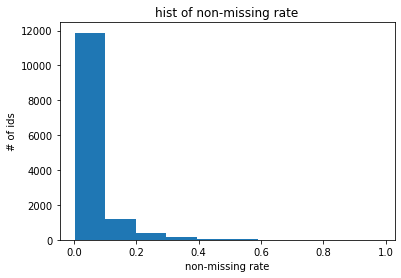

In [63]:
missing_info = check_missings(app_based_test_dt, 288)

### NMF test

In [72]:
app_based_test_dt.head(3)

,newid,sum,key,taz,date,time,newid_idx,taz_idx,time_idx,lt_idx
0,26,1,4_3_55_608,608,4,3:55,0,143,47,41231
1,26,2,4_4_5_615,615,4,4:05,0,150,49,43249
2,26,1,4_3_40_578,578,4,3:40,0,132,44,38060


In [81]:
a = np.ones((2,5))
b = np.ones((2,5))
b[0,1:3] = 0
b[1,2:] = 2

In [82]:
b

array([[1., 0., 0., 1., 1.],
       [1., 1., 2., 2., 2.]])

In [86]:
np.count_nonzero(a[np.where((1*((a == b)==True))==0)]<0)/len(a[np.where((1*((a == b)==True))==0)])

0.0

In [88]:
app_based_test_dt.groupby()

,newid,sum,key,taz,date,time,newid_idx,taz_idx,time_idx,lt_idx
0,26,1,4_3_55_608,608,4,3:55,0,143,47,41231
1,26,2,4_4_5_615,615,4,4:05,0,150,49,43249
2,26,1,4_3_40_578,578,4,3:40,0,132,44,38060
3,26,3,4_3_40_627,627,4,3:40,0,151,44,43532
4,32,1,4_11_35_502,502,4,11:35,1,72,139,20875
...,...,...,...,...,...,...,...,...,...,...
227191,458481,1,4_23_0_567,567,4,23:00,13708,121,276,35124
227192,458481,1,4_23_0_566,566,4,23:00,13708,120,276,34836
227193,458481,1,4_22_55_431,431,4,22:55,13708,5,275,1715
227194,458481,1,4_23_10_550,550,4,23:10,13708,116,278,33686


In [ ]:

mitigate_miss_per  = np.count_nonzero(1*(WH_index[check_idx] == WH_index_tru[check_idx]))/(len(WH_index[check_idx]))
    

In [89]:
#no ground truth to check 
def fit_process_dt_mf01(dt, time_range, missing_info, 
                        missing_val, k_val, model_name): 
    #convert data into matrix
    result_para = []
    test_dt = convert2matrix(dt, time_range)
    fit_dt = test_dt[np.where(missing_info>=missing_val)[0],]
    svd_idx = 0
    
    #predict data based on missing_rate
    if  model_name == 'NMF':
        model = NMF(n_components=k_val, init='random', random_state=0,
                   beta_loss='kullback-leibler', solver='mu')
        W = model.fit_transform(fit_dt)
        H = model.components_

    if model_name == 'BMF':
        #some of the parameters may be reconducted
        #seed = 'nndsvd'
        model = nimfa.Bmf(fit_dt, rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
        model_fit = model()
        
        W = model_fit.fit.W
        H = model_fit.fit.H
        
    if model_name == 'SVD':
        u, s, v = svds(fit_dt, k=k_val)
        svd_idx = 1
        
    if svd_idx == 1:
        pred_dt = u @ np.diag(s) @ v
        print('if pred & fit dt is equal, with tol=0.01:', 
              np.allclose(pred_dt, fit_dt, atol=1e-2))
        
        model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)
        #model_rmse_tru = mean_squared_error(fit_dt_tru, pred_dt, squared=False)

        print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)

        WH_max, WH_index = get_pred_dt(pred_dt, 288)
        ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, fit_dt_tru, WH_index)

        result_para = [model_rmse, ori_miss_per, mitigate_miss_per]    

        del(u, s, v, pred_dt)
        return(result_para)
    
    else:
        #check if the model fit the data well    
        if True in np.isnan(W) or True in np.isnan(H):
            print('Error, fitting data failed')
            del(W, H)
            return([0,0,0,0])

        else:
            pred_dt = np.dot(W, H)
            pred_dt = np.array(pred_dt)

            model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)

            WH_max, WH_index = get_pred_dt(pred_dt, 288)
            ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, WH_index)

            result_para = [model_rmse,  ori_miss_per, mitigate_miss_per]    

            del(W, H, pred_dt)
            return(result_para)
    
#para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
#para_lst_bmf = [k_val, lambda_w, lambda_h]  
#for BMF and NMF
def fit_process_dt_mf01_sensitive(dt, time_range, 
                      missing_info, missing_val, 
                      model_name, para_lst): 
    #convert data into matrix
    result_para = []
    test_dt = convert2matrix(dt, time_range)
    fit_dt = test_dt[np.where(missing_info>=missing_val)[0],]
    
    #predict data based on missing_rate
    if  model_name == 'NMF':
        #para_lst = [k_val, alpha_W, alpha_H, l1_ratio]
        model = NMF(n_components = para_lst[0], init='random', random_state=0,
                   alpha_W = para_lst[1], alpha_H = para_lst[2],
                   l1_ratio = para_lst[3], beta_loss='kullback-leibler',
                   solver='mu')
        W = model.fit_transform(fit_dt)
        H = model.components_

    if model_name == 'BMF':
        #some of the parameters may be reconducted
        #seed = 'nndsvd'
        #para_lst = [k_val, lambda_w, lambda_h]
        model = nimfa.Bmf(fit_dt, rank=para_lst[0], max_iter=1000, 
                          lambda_w=para_lst[1], lambda_h=para_lst[2])
        model_fit = model()
        
        W = model_fit.fit.W
        H = model_fit.fit.H
        
    #check if the model fit the data well    
    if True in np.isnan(W) or True in np.isnan(H):
        print('Error, fitting data failed')
        del(W, H)
        return([0,0,0,0])
        
    else:
        pred_dt = np.dot(W, H)
        pred_dt = np.array(pred_dt)
    
        model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)

        print('RMSE, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+',', model_rmse)

        WH_max, WH_index = get_pred_dt(pred_dt, 288)
        ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, WH_index)

        result_para = [model_rmse, ori_miss_per, mitigate_miss_per]    

        del(W, H, pred_dt)
        return(result_para)


#para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
#para_lst_bmf = [k_val, lambda_w, lambda_h]    
def fit_dtbytime_sensitive(dt, missing_info, missing_val, 
                           time_interval, model_name, para_lst):
    num_taz = len(np.unique(dt['taz_idx']))
    num_time = len(np.unique(dt['time_idx']))
    test_dt = convert2matrix(dt, time_interval)
    
    #predict data based on missing_rate
    
    fit_dt = test_dt[np.where(missing_info>=missing_val)[0],]
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    
    null_idx = 0
    result_para = {}
    svd_idx = 0
    for ky in time_dict:
        result_para[ky] = []
        #print(ky)
        input_dt = fit_dt[:, time_dict[ky]]
        if model_name == 'NMF':
            #para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
            model = NMF(n_components = para_lst[0], init='random', 
                        random_state=0,
                        alpha_W = para_lst[1], alpha_H = para_lst[2],
                        l1_ratio = para_lst[3], beta_loss='kullback-leibler', solver='mu')
            #model = NMF(n_components=k_val, init='random', random_state=0)
            W = model.fit_transform(input_dt)
            H = model.components_
            
        if model_name == 'BMF':
            #some of the parameters may be reconducted
            #seed = 'nndsvd'
            #para_lst = [k_val, lambda_w, lambda_h]
            model = nimfa.Bmf(input_dt, rank=para_lst[0], max_iter=1000, 
                              lambda_w=para_lst[1], lambda_h=para_lst[2])
            #model = nimfa.Bmf(input_dt, rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
            model_fit = model()

            W = model_fit.fit.W
            H = model_fit.fit.H
            
        if model_name == 'SVD':
            u, s, v = svds(fit_dt, k=k_val)
            svd_idx = 1
        
        if svd_idx == 1:
            pred_dt = u @ np.diag(s) @ v
            print('if pred & fit dt is equal, with tol=0.01:', 
                  np.allclose(pred_dt, fit_dt, atol=1e-2))

            model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)
            #model_rmse_tru = mean_squared_error(fit_dt_tru, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)

            WH_max, WH_index = get_pred_dt(pred_dt, 288)

        else:
            if True in np.isnan(W) or True in np.isnan(H):
                print('Error, fitting data failed')
                null_idx = 1
                del(W, H)
                result_para[ky] = [0,0,0,0]

            else:
                #print(WH.shape)
                pred_dt = np.dot(W, H)
                pred_dt = np.array(pred_dt)

                WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
                #print(WH_max.shape, WH_index.shape)

        model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)

        print('RMSE, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+','+ky+',', model_rmse)

        ori_miss_per, mitigate_miss_per = check_pred_indexbytime(input_dt, WH_index, num_taz, ky)

        del(WH_max, WH_index, pred_dt)
        #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
        #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
        result_para[ky] = [model_rmse, ori_miss_per, mitigate_miss_per]
    
    return(result_para)    

def check_pred_index(fit_dt, WH_index):
    WH_max_mis, WH_index_mis = get_pred_dt(fit_dt, 288)

    #real vs revised data
    match_per = np.count_nonzero(1*((WH_index_mis == WH_index)==True))/(len(WH_index_mis.flatten()))
    #sim pred vs sim true
    #mx location with pred != raw dt
    check_idx = np.where((1*((WH_index_mis == WH_index)==True))==0)
    mitigate_miss_per  = np.count_nonzero(WH_idx[check_idx]>0)/(len(WH_index[check_idx]))
    
    print('matched % compared with raw dt', match_per)
    print('% of missings mitigated', mitigate_miss_per)
    return(match_per, mitigate_miss_per)
    
def fit_process_dt_nmf_csrsparse(sim_dt, missing_info, missing_val, k_val):
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    ix = np.nonzero(fit_dt)
    sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))
    model = NMF(n_components=k_val, init='random', random_state=0, beta_loss='kullback-leibler', solver='mu').fit(sparse_fit_dt)
    
    reconstructed = model.inverse_transform(model.transform(sparse_fit_dt))
    model_rmse = mean_squared_error(sparse_fit_dt.toarray(), reconstructed, squared=False)
    
    print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)
    del(sparse_fit_dt, reconstructed)
    return(model_rmse)         
    

def fit_dtbytime(dt,  
                 missing_info, missing_val, time_interval, 
                 k_val, model_name):
    
    num_taz = len(np.unique(dt['taz_idx']))
    num_time = len(np.unique(dt['time_idx']))
    test_dt = convert2matrix(dt, time_interval)
    
    
    #predict data based on missing_rate
    
    fit_dt = test_dt[np.where(missing_info>=missing_val)[0],]
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    
    null_idx = 0
    svd_idx = 0
    result_para = {}
    for ky in time_dict:
        result_para[ky] = []
        #print(ky)
        input_dt = fit_dt[:, time_dict[ky]]
        if model_name == 'NMF':
            model = NMF(n_components=k_val, init='random', random_state=0,  
                        beta_loss='kullback-leibler', solver='mu')
            W = model.fit_transform(input_dt)
            H = model.components_
            
        if model_name == 'BMF':
            #some of the parameters may be reconducted
            #seed = 'nndsvd'
            model = nimfa.Bmf(input_dt, rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
            model_fit = model()

            W = model_fit.fit.W
            H = model_fit.fit.H
        
        #pred_dt = np.dot(W, H)
        #pred_dt = np.array(pred_dt)
        if model_name == 'SVD':
            u, s, v = svds(input_dt, k=k_val)
            svd_idx = 1
        
        if svd_idx == 1:
            pred_dt = u @ np.diag(s) @ v
            print('if pred & fit dt is equal, with tol=0.01:', 
                  np.allclose(pred_dt, input_dt, atol=1e-2))

            WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
            #print(WH_max.shape, WH_index.shape)

            model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky+',', model_rmse)
            print('RMSE with True, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky+',', model_rmse_tru)

            match_per, mitigate_miss_per = check_pred_indexbytime(input_dt, WH_index, num_taz,ky)

            del(WH_max, WH_index, pred_dt)
            #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
            #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
            result_para[ky] = [model_rmse, match_per, mitigate_miss_per]
            del(u, s, v)

        else:
            if True in np.isnan(W) or True in np.isnan(H):
                print('Error, fitting data failed')
                null_idx = 1
                del(W, H)
                result_para[ky] = [0,0,0,0]

            else:
                #print(WH.shape)
                pred_dt = np.dot(W, H)
                pred_dt = np.array(pred_dt)

                WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
                #print(WH_max.shape, WH_index.shape)

                model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)

                print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky+',', model_rmse)

                match_per, mitigate_miss_per = check_pred_indexbytime(input_dt, input_dt_tru, WH_index, num_taz, ky)

                del(WH_max, WH_index, pred_dt, W, H)
                #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
                #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
                result_para[ky] = [model_rmse, match_per, mitigate_miss_per]
    
    return(result_para)
        

def check_pred_indexbytime(fit_dt, WH_index, num_taz, ky):
    WH_max_mis, WH_index_mis = get_pred_dt_time(fit_dt, num_taz)

    #sim var vs sim true
    match_per = (np.count_nonzero(1*((WH_index_mis == WH_index)==True))/(len(WH_index_mis.flatten())))
    #sim pred vs sim true
    check_idx = np.where((1*((WH_index_mis == WH_index_tru)==True))==0)
    mitigate_miss_per  = np.count_nonzero(WH_index[check_idx]>0)/(len(WH_index[check_idx]))
    
    print('matched % compared with raw dt'+ky+',', match_per)
    print('% of missings mitigated'+ky+',', mitigate_miss_per)
    
    return(match_per, mitigate_miss_per)

def get_pred_dt_time(WH_pred, num_taz):
    #print('num taz', num_taz)
    time_interval = int(WH_pred.shape[1]/num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T) 


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def add_result2dict(result_para, result_para_time, result_para_dict):
    result_para_dict = add_val(result_para, 'ori', result_para_dict)
    result_para_dict = add_val(result_para_time['mor'], 'mor', result_para_dict)
    result_para_dict = add_val(result_para_time['noon'], 'noon', result_para_dict)
    result_para_dict = add_val(result_para_time['eve'], 'eve', result_para_dict)
    result_para_dict = add_val(result_para_time['other'], 'other', result_para_dict)
    return(result_para_dict)
    
    
def add_val(result_val, ky, result_para_dict):    
    result_para_dict[ky]['rmse_predvsraw'].append(result_val[0])
    result_para_dict[ky]['match per'].append(result_val[1])
    result_para_dict[ky]['per of missings mitigated'].append(result_val[2])
    return(result_para_dict)

#plot the results
def plot_paras(result_para_dict, xval, kval, missinginfo, ypop):
    plot_popidx = 0
    for ky in result_para_dict:
        #plt.figure(idx)
        paras = list(result_para_dict[ky].keys())
        #print(paras)
        #fig.tight_layout()
        
        plt.title('model:k='+str(kval)+', use '+missinginfo)
        #ax[0].set_title('RMSE')
        #print(result_para_dict[ky][paras[0]])
        plt.figure(1)
        plt.plot(xval, result_para_dict[ky][paras[0]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel('RMSE, pred vs. raw')
        #ax[0, 0].legend()
        plt.legend()
        
        plt.figure(2)
        plt.plot(xval, result_para_dict[ky][paras[1]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel(paras[1])
        plt.legend()
        
        plt.figure(3)
        plt.plot(xval, result_para_dict[ky][paras[2]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel(paras[2])
        #label = f"({x},{y})"
        plt.legend()
        if ypop != -1:
            if plot_popidx == 0:
                for i in range(len(xval)):
                    label =  f"{ypop[i]}"

                    plt.annotate(label, # this is the text
                                 (xval[i], 0.015), # these are the coordinates to position the label
                                 textcoords="offset points", # how to position the text
                                 xytext=(0,10), # distance from text to points (x,y)
                                 ha='center') # horizontal alignment can be left, right or center
                plot_popidx = 1
                

def plot_paras_sensitive(result_para_dict, xval, paras_intest, para_loc, idx):
    xval = np.array(xval)[:, para_loc]
    #convert xval from number to string
    xval = list(map(str, list(xval)))
    for ky in result_para_dict:
        #plt.figure(idx)
        paras = list(result_para_dict[ky].keys())
        #print(paras)
        #fig.tight_layout()
        
        #ax[0].set_title('RMSE')
        #print(result_para_dict[ky][paras[0]])
        plt.figure(idx)
        plt.title('sensitive test, test para: '+paras_intest)
        plt.plot(xval, result_para_dict[ky][paras[0]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.ylabel('RMSE, sim vs pred')
        #ax[0, 0].legend()
        plt.legend()
        
        plt.figure(idx+1)
        plt.plot(xval, result_para_dict[ky][paras[1]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.ylabel('match rate')
        #ax[0, 1].legend()
        plt.legend()
        
        plt.figure(idx+2)
        plt.plot(xval, result_para_dict[ky][paras[2]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.ylabel('rate'+paras[2][3:])
        #label = f"({x},{y})"
        plt.legend()  

    return(idx+3) 
        
def save_result_dict(result_dict, savename):
    # create json object from dictionary
    #json = json.dumps(result_dict)
    # open file for writing, "w" 
    f = open(savename,"w")
    # write json object to file
    f.write(str(result_dict))
    # close file
    f.close()
    
def fit_model_get_para(dt, k_val, 
                       x_val, time_interval, 
                       result_para_dict, model_name,
                       change_k=False):
    missing_info = check_missings(dt, time_interval, False)
    result_para_dict_return = copy.deepcopy(result_para_dict)
    if change_k == True:
        for i in k_val:
            result_para = fit_process_dt_mf01(dt, time_interval, missing_info, x_val, i, model_name)
            result_para_time = fit_dtbytime(dt, time_interval, missing_info, x_val, 12, i, model_name)
            result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
    else:
        for i in x_val:
            result_para = fit_process_dt_mf01(dt, time_interval, missing_info, i, k_val, model_name)
            result_para_time = fit_dtbytime(dt, time_interval, missing_info, i, 12, k_val, model_name)
            result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
            #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    return(result_para_dict_return)

def fit_model_get_para_sensitive(dt, para_lst, missing_val, time_interval, result_para_dict, model_name):
    missing_info = check_missings(dt, time_interval, False)
    result_para_dict_return = copy.deepcopy(result_para_dict)
    for paras in para_lst:
        result_para = fit_process_dt_mf01_sensitive(dt, time_interval, 
                                                  missing_info, missing_val,  
                                                  model_name, paras)
        result_para_time = fit_dtbytime_sensitive(dt, time_interval, 
                                        missing_info, missing_val, 12, 
                                        model_name, paras)
        result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
        #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    return(result_para_dict_return)

In [104]:
result_para_dict = {'ori':{'rmse_predvsraw':[],
                           'match per':[],    
                           'per of missings mitigated':[]},
                    'mor':{'rmse_predvsraw':[],
                     'match per':[],    
                     'per of missings mitigated':[]},
                    'noon':{'rmse_predvsraw':[],
                       'match per':[],    
                       'per of missings mitigated':[]},
                    'eve':{'rmse_predvsraw':[],
                      'match per':[],    
                      'per of missings mitigated':[]},
                    'other':{'rmse_predvsraw':[],
                        'match per':[],    
                        'per of missings mitigated':[]}
                   }

### Sensitive test

In [105]:
def generate_paralst(test_valrange, val_loc, other_val, para_len):
    para_lst = []
    add_para_cb = []
    idx = 0
    if len(val_loc) == 1:
        for i in range(para_len):
            if i in val_loc:
                add_para_cb.append(0)
            else:
                add_para_cb.append(other_val[idx])
                idx += 1
        #print(add_para_cb)        
        for j in range(len(test_valrange)):
            add_para_cb_cur = copy.deepcopy(add_para_cb)
            add_para_cb_cur[val_loc[0]] = test_valrange[j]
            para_lst.append(add_para_cb_cur)
        
    else:
        add_para_cb = np.zeros(para_len)
        idx = 0
        for i in range(para_len):
            if i not in val_loc:
                add_para_cb[i] = other_val[idx]
                idx += 1
        for j in range(len(test_valrange)):
            add_para_cb_cur = copy.deepcopy(add_para_cb)
            add_para_cb_cur[val_loc] = test_valrange[j]
            para_lst.append(list(add_para_cb_cur))
    
    #conver type k to int
    for i in range(len(para_lst)):
        para_lst[i][0] = int(para_lst[i][0])
    #convert other type to float
    num_other_para = len(para_lst[0])-1
    for i in range(len(para_lst)):
        for j in range(1, num_other_para+1):
            para_lst[i][j] = round(para_lst[i][j], 1)
    
    return(para_lst)

def get_num_txt(line):
    nums = re.findall("\d+", line)
    est_ = nums[-2]+'.'+nums[-1]
    return(float(est_))


def get_para_dt(txt_file, result_para_dict):    
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    f.close()
    
    para_result =  copy.deepcopy(result_para_dict)
    paras = list(para_result['ori'].keys())

    event_idx = 0
    start_idx = 0


    for l in lines:
        if l=='\n':
            pass
        else:
            if 'mor' in l or event_idx == 1:
                event_idx = 1
                est_val = get_num_txt(l)
                para_result['mor'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            elif 'eve' in l or event_idx == 3:
                event_idx = 3
                est_val = get_num_txt(l)
                para_result['eve'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            elif 'noon' in l or event_idx == 2:
                event_idx = 2
                est_val = get_num_txt(l)
                para_result['noon'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            elif 'other' in l or event_idx == 4:
                event_idx = 4
                est_val = get_num_txt(l)
                para_result['other'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            else:
                est_val = get_num_txt(l)
                para_result['ori'][paras[start_idx%4]].append(est_val)
            start_idx += 1
    
    return(para_result)

### NMF test

In [99]:
k_nmf = generate_paralst(list(np.array(range(1, 21))*10), [0], [0, 0, 0], 4)
k_nmf_100 = generate_paralst(list(np.array(range(1, 11))*100), [0], [0, 0, 0], 4)

,0
0,0.010417
1,0.121528
2,0.048611
3,0.006944
4,0.003472
...,...
13704,0.093750
13705,0.069444
13706,0.041667
13707,0.107639


In [ ]:
#test of k
test_k_nmf = fit_model_get_para_sensitive(app_based_test_dt, k_nmf, 
                                          0.05, 288, result_para_dict, 'NMF')

### BMF test

In [ ]:
k_bmf =  generate_paralst(list(np.array(range(1, 21))*10), [0], [1.1, 1.1], 3)
#after check k, k=40
lw_bmf =  generate_paralst(list(np.array(range(0, 21))*0.2), [1], [40, 1.1], 3)
lh_bmf =  generate_paralst(list(np.array(range(0, 21))*0.2), [2], [40, 1.1], 3)
lwlh_bmf = generate_paralst(list(np.array(range(0, 21))*0.2), [1,2], [40], 3)

##### NMF vs BMF sensitive test

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0] 0.012747941355114744
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0] 0.05890990254038719
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0012748812457545689


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0],mor 0.014897337919360236
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0],mor 0.06309733429106809
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08124442165631705
RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0],noon 0.020279348798804307
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0],noon 0.06865090938058255
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0008554037890541286
RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0],eve 0.016006798279745077
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0],eve 0.06349993891236778
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06786325122377966


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0],other 0.005193827870676038
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0],other 0.048822982802958555
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.05640331557648284


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0] 0.012728718568937158
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0] 0.058837325335104544
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0035766192435194026


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0],mor 0.01487681263820534
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0],mor 0.06309411730648869
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08310545205947702
RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0],noon 0.020232963311889035
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0],noon 0.06846143358945231
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0028537882298636666
RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0],eve 0.016001968528226718
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0],eve 0.0635454058530585
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06976035543672715
RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0],other 0.0051912075414179
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0],other 0.048860064497000914
% of missin

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0] 0.01271491599386535
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0] 0.05882305330455383
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0029309307752444455


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0],mor 0.01485186286166284
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0],mor 0.06308061776598275
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08733549820543497
RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0],noon 0.020196482054600024
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0],noon 0.0683454289353378
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0016045689918874017
RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0],eve 0.015977678326213936
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0],eve 0.06351789831834781
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07378064363929464
RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0],other 0.005184532115529781
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0],other 0.04885659150974452
% of missi

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0] 0.012702146379228882
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0] 0.058812769993008183
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.004911591934314159


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0],mor 0.014835492770883429
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0],mor 0.06307189088415674
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09164625230255037
RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0],noon 0.020166330636138076
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0],noon 0.068275073666488
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0029545317167972364
RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0],eve 0.0159540322529309
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0],eve 0.06349366012541163
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07787465350816836
RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0],other 0.00517834618261248
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0],other 0.04885719515309826
% of missings

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0] 0.012690169362749968
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0] 0.05880138269599802
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.005967316145216279


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0],mor 0.01481578160500504
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0],mor 0.0630723478347906
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.10009684954138894
RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0],noon 0.020147491195194166
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0],noon 0.06824144581635616
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0036963701205807954
RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0],eve 0.015943388249205864
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0],eve 0.06351658457952507
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08486838225175458
RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0],other 0.005173145082117199
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0],other 0.04885990749243864
% of missi

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0] 0.012677472944743171
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0] 0.05879410321453467
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.005992648813223417


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0],mor 0.01478858471424342
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0],mor 0.06305872255934462
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.10640156478474715
RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0],noon 0.020128653845190622
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0],noon 0.06821702282458424
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.004309989540994356
RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0],eve 0.015917559267014346
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0],eve 0.06349580559821014
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08557611024829458
RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0],other 0.005165878815844691
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0],other 0.04885834047537661
% of missi

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0] 0.012666525148895269
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0] 0.058793649421417044
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007179749418674182


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0],mor 0.014768088917015573
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0],mor 0.06305747447800099
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.11521772156706356
RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0],noon 0.02011800019769181
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0],noon 0.0682400390807881
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.005921885331931473
RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0],eve 0.01589058438103169
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0],eve 0.06348317568488952
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.09697347985924076
RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0],other 0.005158293173594068
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0],other 0.04885393210675108
% of missing

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0] 0.01265851021681209
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0] 0.05880182180952271
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00694115103395579


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0],mor 0.014744347262279031
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0],mor 0.06304006900040617
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.12397216050437722
RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0],noon 0.02009533012245921
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0],noon 0.0682177203390896
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.006004311821240757
RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0],eve 0.015879910377906963
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0],eve 0.06348913719425803
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.10079717695165824
RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0],other 0.005153214172841241
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0],other 0.04885554840475796
% of missin

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0] 0.01264742042841409
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0] 0.05879957000470048
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007008312060765412


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0],mor 0.014721230014808453
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0],mor 0.06302504540918395
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.13785867562999676
RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0],noon 0.02009034161337367
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0],noon 0.0682002457803892
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.007390908541399162
RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0],eve 0.015846122598569726
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0],eve 0.06346730668369849
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.11110346590127194
RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0],other 0.005145404997811132
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0],other 0.048849994215980505
% of missi

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0] 0.01263532505201235
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0] 0.05879072123055703
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007169734177834152


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],mor 0.014698131592701029
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],mor 0.06302897919237925
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1417184147059382
RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],noon 0.020083983769911846
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],noon 0.0682467889933743
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00749348372809516
RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],eve 0.015831136204656926
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],eve 0.06346728218521058
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.11648023276387441
RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],other 0.005141340290431893
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],other 0.04885114823871575
% of

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0] 0.01262584618351635
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0] 0.05878769436767305
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007710557183195839


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0],mor 0.014661246794220614
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0],mor 0.06299536025934954
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15583755863195276
RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0],noon 0.02007340754464375
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0],noon 0.06824392185698522
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00719308496705688
RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0],eve 0.015803884050179566
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0],eve 0.06346319951632777
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.12551359427526687
RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0],other 0.005131083736736035
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0],other 0.04884652736556249
% o

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0] 0.012616395386233816
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0] 0.05880454216520071
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0077659355737230715


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0],mor 0.01465037480386391
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0],mor 0.0630092601455547
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.16743576596593174
RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0],noon 0.020066618649483833
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0],noon 0.06824413394730376
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.008735376167021712
RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0],eve 0.01578415545721309
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0],eve 0.06345407294276882
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.12810368215149312
RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0],other 0.005126391737913087
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0],other 0.04884653777007829
% of

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0] 0.012608011712918627
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0] 0.058805865278089266
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007965651258709577


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0],mor 0.014628795940029988
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0],mor 0.06299806195343544
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.17036024231375455
RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0],noon 0.020065896101163133
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0],noon 0.06827771474251872
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.008870921949441423
RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0],eve 0.015760581142626594
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0],eve 0.06344837632292538
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.14213537263844928
RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0],other 0.005120350016116125
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0],other 0.048846535989498924


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0] 0.012601913256504308
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0] 0.05880534057094603
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008051075371756903


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0],mor 0.01458296619715145
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0],mor 0.06297738814106128
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.19367534514517937
RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0],noon 0.020033687185747252
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0],noon 0.0682247114970292
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.009253747199788989
RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0],eve 0.01573126571404942
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0],eve 0.0634342844984454
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.15148819470383548
RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0],other 0.005110072692998595
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0],other 0.048843151485382985
% of

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0] 0.01259605135894552
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0] 0.058825449234717046
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007347651985698236


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0],mor 0.014574194515717986
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0],mor 0.06297187895950937
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.19841812415731405
RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0],noon 0.02006688462879074
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0],noon 0.06828069053156263
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.008790327159894567
RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0],eve 0.015733299471849503
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0],eve 0.06344181791515086
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.15729746200876796
RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0],other 0.005101105258193535
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0],other 0.048840652968526625
%

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0] 0.01258370547499114
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0] 0.05881812051617653
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007522624134491724


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0],mor 0.014546041776095468
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0],mor 0.06297078115424178
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.20649841432613608
RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0],noon 0.020051901087956996
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0],noon 0.06829784406551682
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.009220776604065275
RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0],eve 0.015666795854590743
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0],eve 0.06340928955045413
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.17261682426720665
RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0],other 0.005096259007754664
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0],other 0.0488432753300689
% 

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0] 0.01258349710107602
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0] 0.05882398660625106
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008359191310541395


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0],mor 0.014514688337722605
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0],mor 0.06295777720097237
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.22142938529026376
RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0],noon 0.02005894199706284
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0],noon 0.06832082322655231
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.009810583927567264
RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0],eve 0.01565187060367931
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0],eve 0.06341046821199932
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.18063282678357284
RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0],other 0.0050888571980560945
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0],other 0.048835476242801615
%

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0] 0.012569430302118796
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0] 0.05884057637044217
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00853710911840548


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0],mor 0.01448440094786518
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0],mor 0.06295348156405224
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.239593421827228
RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0],noon 0.0200749737015595
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0],noon 0.06831551386924907
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.009742811036357409
RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0],eve 0.015590178015922948
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0],eve 0.06338363046657791
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.18741030530599406
RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0],other 0.005081840864737031
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0],other 0.048838425581189955
% of 

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0] 0.012566623729345486
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0] 0.05883629718776525
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008596611431631547


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0],mor 0.014458085329361313
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0],mor 0.06294116639003887
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.24200041778233541
RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0],noon 0.02005801548204884
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0],noon 0.06835134258239875
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.010891286787400103
RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0],eve 0.015595318948947653
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0],eve 0.06340710031100319
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.203098275895964
RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0],other 0.005074277552717471
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0],other 0.048834936702560505
% o

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0] 0.012560519017558194
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0] 0.05882477787009622
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008487032914205323


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],mor 0.014440279372249185
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],mor 0.06294356161068372
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.2605679940750869
RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],noon 0.02002161988882496
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],noon 0.0683539920306817
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.010689799813532965
RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],eve 0.01558460766103296
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],eve 0.06339620521283915
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.2057178524387127
RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],other 0.005067082155127967
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],other 0.04882849390101225
% of m

4

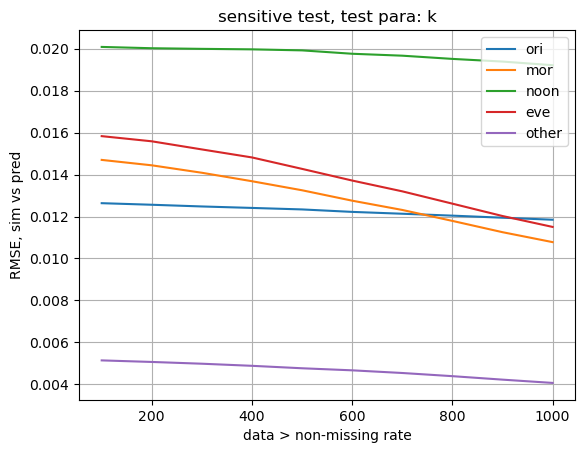

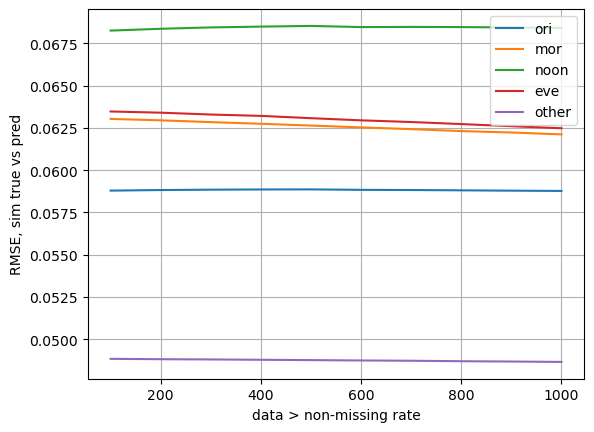

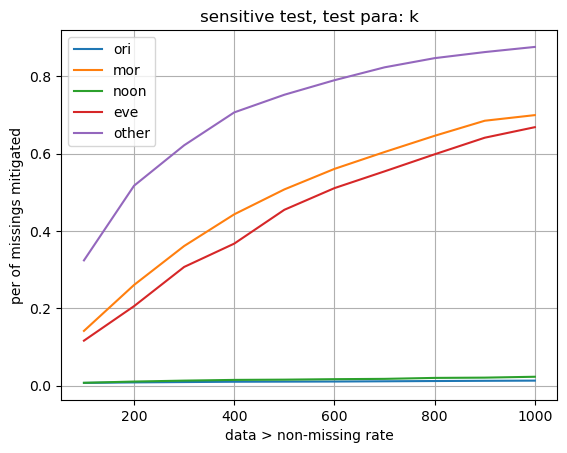

In [107]:
plot_paras_sensitive(test_k_nmf_100, k_nmf_100, 'k', 0, 1)

4

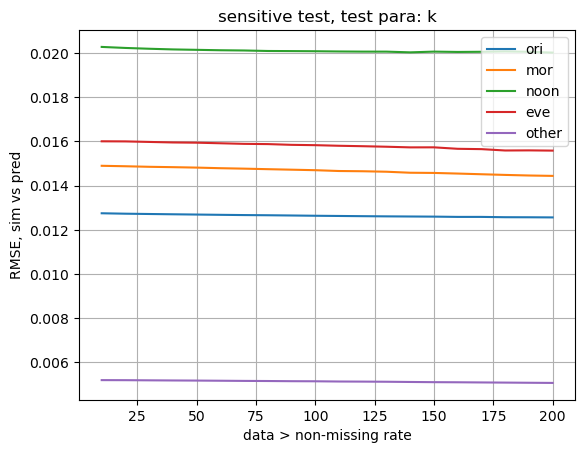

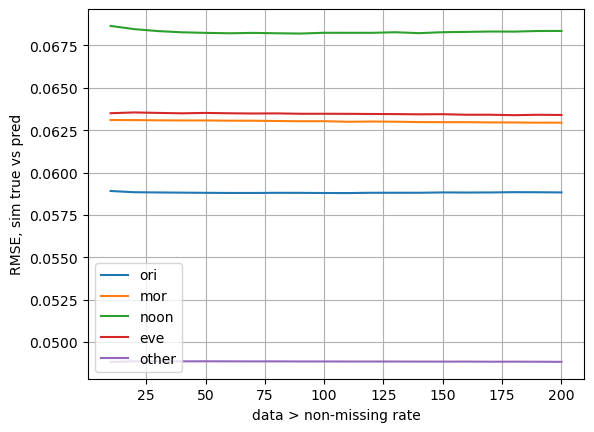

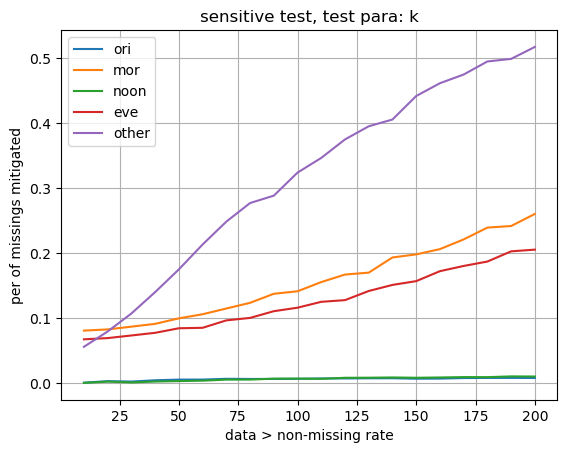

In [59]:
plot_paras_sensitive(test_k_nmf, k_nmf, 'k', 0, 1)

###### aW and aH

In [ ]:
aWaH_nmf = [[700, 0.01, 0.01, 0.5],
            [700, 0.1, 0.1, 0.5],
            [700, 1., 1., 0.5],
            [700, 10., 10., 0.5],
            [700, 100., 100., 0.5]]
test_aWaH_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf, 
                                          0.05, 288, result_para_dict, 'NMF')

In [ ]:
aWaH_nmf_2 =  [[700, 0.01, 0.1, 0.5],
                [700, 0.01, 1.0, 0.5],
                [700, 0.01, 10.0, 0.5],
                [700, 0.01, 100.0, 0.5],
                [700, 0.1, 0.01, 0.5],
                [700, 1., 0.01, 0.5],
                [700, 10., 0.01, 0.5],
                [700, 100., 0.01, 0.5]]

test_aWaH_nmf2 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_2, 
                                          0.05, 288, result_para_dict, 'NMF')

In [35]:
aWaH_nmf_2 =  [[700, 0.01, 0.01, 0.2],
                [700, 0.01, 0.1, 0.2],
                [700, 0.01, 1.0, 0.2],
                [700, 0.01, 10.0, 0.2],
                [700, 0.01, 100.0, 0.2]
               ]

aWaH_nmf_3 =  [[700, 0.01, 0.01, 0.2],
                [700, 0.1, 0.01, 0.2],
                [700, 1., 0.01, 0.2],
                [700, 10., 0.01, 0.2],
                [700, 100., 0.01, 0.2]]

test_aWaH_nmf2 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_2, 
                                          0.05, 288, result_para_dict, 'NMF')

test_aWaH_nmf3 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_3, 
                                          0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2], 0.012688169872462665
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2], 0.05902531329861469
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.007004777269880695


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],mor, 0.01469097114213229
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],mor, 0.06310939927108696
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.5013625401165992
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],noon, 0.02009441692451088
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],noon, 0.06864156516543975
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.009475382871042841
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],eve, 0.01577430384586085
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],eve, 0.06355938605510274
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.4301659228969666
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],other, 0.005179342052624784
RMS

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.1, 0.2], 0.012767135571331389
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.1, 0.2], 0.05911694391619182
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006281323402141966


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.1, 0.2],mor, 0.014889659578560008
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.1, 0.2],mor, 0.06318007164281245
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.5405960994321958
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.1, 0.2],noon, 0.02028998059374235
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.1, 0.2],noon, 0.06887633483540108
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.0068029329176596005
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.1, 0.2],eve, 0.01600222438275021
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.1, 0.2],eve, 0.06363937312733418
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.48556529773723633
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.1, 0.2],other, 0.005205400922081787
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 1.0, 0.2], 0.012788738415805273
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 1.0, 0.2], 0.05917911783116411
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.00524386227747755


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 1.0, 0.2],mor, 0.014930480474055539
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 1.0, 0.2],mor, 0.06319428739068438
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.5354212955050419
RMSE, data with missing rate>=0.05, para=[700, 0.01, 1.0, 0.2],noon, 0.020345909707373693
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 1.0, 0.2],noon, 0.06900272274796325
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.006480553759472177
RMSE, data with missing rate>=0.05, para=[700, 0.01, 1.0, 0.2],eve, 0.016049630526245643
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 1.0, 0.2],eve, 0.06365576250183817
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.4892218923860263
RMSE, data with missing rate>=0.05, para=[700, 0.01, 1.0, 0.2],other, 0.005210225536488506
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 10.0, 0.2], 0.012793418034945516
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 10.0, 0.2], 0.059194452323211556
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006325508288200927


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 10.0, 0.2],mor, 0.014936015194618008
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 10.0, 0.2],mor, 0.06319618549576564
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10422245010349608
RMSE, data with missing rate>=0.05, para=[700, 0.01, 10.0, 0.2],noon, 0.020357376693545728
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 10.0, 0.2],noon, 0.06903244551889075
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010627522021610394
RMSE, data with missing rate>=0.05, para=[700, 0.01, 10.0, 0.2],eve, 0.01605623225036453
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 10.0, 0.2],eve, 0.06365800833489661
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09181787799555705
RMSE, data with missing rate>=0.05, para=[700, 0.01, 10.0, 0.2],other, 0.005210840720618519

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 100.0, 0.2], 0.012793730839943233
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 100.0, 0.2], 0.05919522509267881
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006329043079085644


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 100.0, 0.2],mor, 0.014936578935343569
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 100.0, 0.2],mor, 0.06319637490829395
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.1056609506447141
RMSE, data with missing rate>=0.05, para=[700, 0.01, 100.0, 0.2],noon, 0.020357963460226256
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 100.0, 0.2],noon, 0.06903325748596896
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010631185421135251
RMSE, data with missing rate>=0.05, para=[700, 0.01, 100.0, 0.2],eve, 0.01605691249992133
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 100.0, 0.2],eve, 0.0636582358147576
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09269270843572454
RMSE, data with missing rate>=0.05, para=[700, 0.01, 100.0, 0.2],other, 0.0052109030636

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2], 0.012688169872462665
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2], 0.05902531329861469
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.007004777269880695


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],mor, 0.01469097114213229
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],mor, 0.06310939927108696
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.5013625401165992
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],noon, 0.02009441692451088
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],noon, 0.06864156516543975
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.009475382871042841
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],eve, 0.01577430384586085
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],eve, 0.06355938605510274
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.4301659228969666
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],other, 0.005179342052624784
RMS

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.1, 0.01, 0.2], 0.01277163239210546
RMSE with True, data with missing rate>=0.05, para=[700, 0.1, 0.01, 0.2], 0.05914430531751148
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006100459935207283


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.1, 0.01, 0.2],mor, 0.014897896379470671
RMSE with True, data with missing rate>=0.05, para=[700, 0.1, 0.01, 0.2],mor, 0.063182127089017
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.3580821891794375
RMSE, data with missing rate>=0.05, para=[700, 0.1, 0.01, 0.2],noon, 0.020297202019298567
RMSE with True, data with missing rate>=0.05, para=[700, 0.1, 0.01, 0.2],noon, 0.06892405097085673
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.00830859012237586
RMSE, data with missing rate>=0.05, para=[700, 0.1, 0.01, 0.2],eve, 0.016008382789173704
RMSE with True, data with missing rate>=0.05, para=[700, 0.1, 0.01, 0.2],eve, 0.06362815065080686
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.29365305600880726
RMSE, data with missing rate>=0.05, para=[700, 0.1, 0.01, 0.2],other, 0.005206990151192883
RMSE with

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0.01, 0.2], 0.01279082014146392
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0.01, 0.2], 0.059187934624664006
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.0054111757126874835


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0.01, 0.2],mor, 0.014932241504912716
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0.01, 0.2],mor, 0.06319456839732837
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.3183738772099736
RMSE, data with missing rate>=0.05, para=[700, 1.0, 0.01, 0.2],noon, 0.020349838282506093
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0.01, 0.2],noon, 0.0690178321066407
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.007988042663950867
RMSE, data with missing rate>=0.05, para=[700, 1.0, 0.01, 0.2],eve, 0.016050893744624553
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0.01, 0.2],eve, 0.06365270658994111
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.2488106237835925
RMSE, data with missing rate>=0.05, para=[700, 1.0, 0.01, 0.2],other, 0.0052105045689317085
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10.0, 0.01, 0.2], 0.012793551151987765
RMSE with True, data with missing rate>=0.05, para=[700, 10.0, 0.01, 0.2], 0.05919499721886322
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.0072233451729190245


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10.0, 0.01, 0.2],mor, 0.014936231451942459
RMSE with True, data with missing rate>=0.05, para=[700, 10.0, 0.01, 0.2],mor, 0.06319624517001449
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10248010786380296
RMSE, data with missing rate>=0.05, para=[700, 10.0, 0.01, 0.2],noon, 0.020357439606617265
RMSE with True, data with missing rate>=0.05, para=[700, 10.0, 0.01, 0.2],noon, 0.06903267877819022
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010720938709494249
RMSE, data with missing rate>=0.05, para=[700, 10.0, 0.01, 0.2],eve, 0.016056494769068765
RMSE with True, data with missing rate>=0.05, para=[700, 10.0, 0.01, 0.2],eve, 0.06365806947005742
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09072188255647079
RMSE, data with missing rate>=0.05, para=[700, 10.0, 0.01, 0.2],other, 0.00521087082250365

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 100.0, 0.01, 0.2], 0.012793744533281392
RMSE with True, data with missing rate>=0.05, para=[700, 100.0, 0.01, 0.2], 0.05919528079360822
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.0072227560411049045


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 100.0, 0.01, 0.2],mor, 0.014936600918940585
RMSE with True, data with missing rate>=0.05, para=[700, 100.0, 0.01, 0.2],mor, 0.06319638098216186
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10248485539034163
RMSE, data with missing rate>=0.05, para=[700, 100.0, 0.01, 0.2],noon, 0.02035797003468476
RMSE with True, data with missing rate>=0.05, para=[700, 100.0, 0.01, 0.2],noon, 0.06903328135303491
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010722770409256678
RMSE, data with missing rate>=0.05, para=[700, 100.0, 0.01, 0.2],eve, 0.016056939253254555
RMSE with True, data with missing rate>=0.05, para=[700, 100.0, 0.01, 0.2],eve, 0.06365824207154383
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.0907022234454558
RMSE, data with missing rate>=0.05, para=[700, 100.0, 0.01, 0.2],other, 0.005210906102

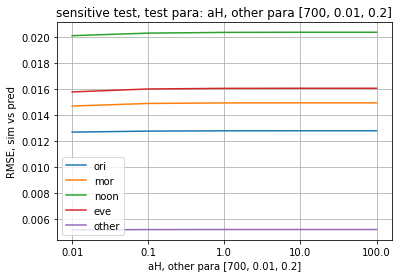

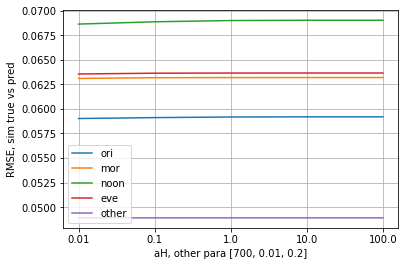

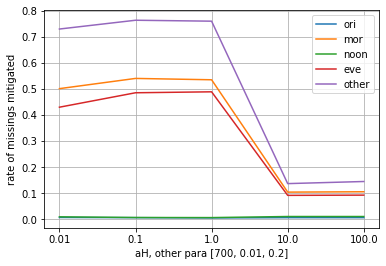

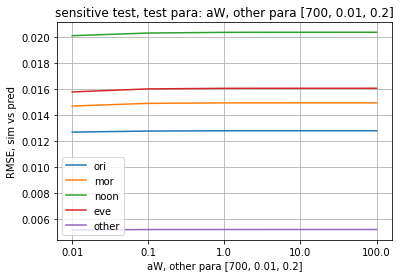

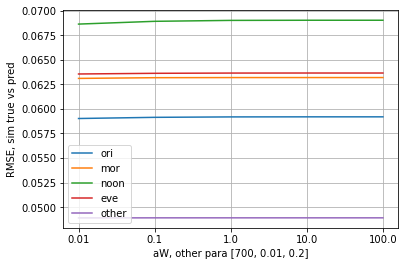

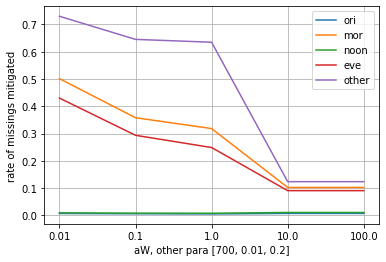

In [60]:
idx = plot_paras_sensitive(test_aWaH_nmf2, aWaH_nmf_2, 'aH, other para '+str([700, 0.01, 0.2]), 2, 1)
idx = plot_paras_sensitive(test_aWaH_nmf3, aWaH_nmf_3, 'aW, other para '+str([700, 0.01, 0.2]), 1, idx)

In [61]:
aWaH_nmf_2 =  [[700, 10, 0.01, 0.2],
                [700, 10, 0.1, 0.2],
                [700, 10, 1.0, 0.2],
                [700, 10, 10.0, 0.2],
                [700, 10, 100.0, 0.2]
               ]

aWaH_nmf_3 =  [[700, 0.01, 10, 0.2],
                [700, 0.1, 10, 0.2],
                [700, 1., 10, 0.2],
                [700, 10., 10, 0.2],
                [700, 100., 10, 0.2]]

test_aWaH_nmf2 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_2, 
                                          0.05, 288, result_para_dict, 'NMF')

test_aWaH_nmf3 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_3, 
                                          0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 0.01, 0.2], 0.012793551151987765
RMSE with True, data with missing rate>=0.05, para=[700, 10, 0.01, 0.2], 0.05919499721886322
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.0072233451729190245


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 0.01, 0.2],mor, 0.014936231451942459
RMSE with True, data with missing rate>=0.05, para=[700, 10, 0.01, 0.2],mor, 0.06319624517001449
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10248010786380296
RMSE, data with missing rate>=0.05, para=[700, 10, 0.01, 0.2],noon, 0.020357439606617265
RMSE with True, data with missing rate>=0.05, para=[700, 10, 0.01, 0.2],noon, 0.06903267877819022
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010720938709494249
RMSE, data with missing rate>=0.05, para=[700, 10, 0.01, 0.2],eve, 0.016056494769068765
RMSE with True, data with missing rate>=0.05, para=[700, 10, 0.01, 0.2],eve, 0.06365806947005742
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09072188255647079
RMSE, data with missing rate>=0.05, para=[700, 10, 0.01, 0.2],other, 0.005210870822503657
RMSE with Tr

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 0.1, 0.2], 0.012793731014545735
RMSE with True, data with missing rate>=0.05, para=[700, 10, 0.1, 0.2], 0.05919524222039684
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.007024218619746638


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 0.1, 0.2],mor, 0.01493657585591679
RMSE with True, data with missing rate>=0.05, para=[700, 10, 0.1, 0.2],mor, 0.06319637327220204
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10385689056001823
RMSE, data with missing rate>=0.05, para=[700, 10, 0.1, 0.2],noon, 0.02035794339184117
RMSE with True, data with missing rate>=0.05, para=[700, 10, 0.1, 0.2],noon, 0.0690332390638119
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010722770409256678
RMSE, data with missing rate>=0.05, para=[700, 10, 0.1, 0.2],eve, 0.016056909652300475
RMSE with True, data with missing rate>=0.05, para=[700, 10, 0.1, 0.2],eve, 0.063658233972452
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09171466766272829
RMSE, data with missing rate>=0.05, para=[700, 10, 0.1, 0.2],other, 0.005210903706892639
RMSE with True, data wit

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 1.0, 0.2], 0.012793761662703811
RMSE with True, data with missing rate>=0.05, para=[700, 10, 1.0, 0.2], 0.05919530256489536
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006818022484804818


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 1.0, 0.2],mor, 0.014936633756287907
RMSE with True, data with missing rate>=0.05, para=[700, 10, 1.0, 0.2],mor, 0.06319639329884504
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10512922767238268
RMSE, data with missing rate>=0.05, para=[700, 10, 1.0, 0.2],noon, 0.020358019406104228
RMSE with True, data with missing rate>=0.05, para=[700, 10, 1.0, 0.2],noon, 0.06903333606224332
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010829008995477533
RMSE, data with missing rate>=0.05, para=[700, 10, 1.0, 0.2],eve, 0.016056978675235138
RMSE with True, data with missing rate>=0.05, para=[700, 10, 1.0, 0.2],eve, 0.06365825789984722
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09271728232449329
RMSE, data with missing rate>=0.05, para=[700, 10, 1.0, 0.2],other, 0.00521090925533806
RMSE with True, data

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 10.0, 0.2], 0.012793765606183222
RMSE with True, data with missing rate>=0.05, para=[700, 10, 10.0, 0.2], 0.05919531135834292
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.00681507682573422


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 10.0, 0.2],mor, 0.014936641165866914
RMSE with True, data with missing rate>=0.05, para=[700, 10, 10.0, 0.2],mor, 0.06319639580692453
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10680510454053438
RMSE, data with missing rate>=0.05, para=[700, 10, 10.0, 0.2],noon, 0.02035802812761859
RMSE with True, data with missing rate>=0.05, para=[700, 10, 10.0, 0.2],noon, 0.06903334724182782
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010841830893814533
RMSE, data with missing rate>=0.05, para=[700, 10, 10.0, 0.2],eve, 0.01605698766795849
RMSE with True, data with missing rate>=0.05, para=[700, 10, 10.0, 0.2],eve, 0.0636582609360595
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09374938565278078
RMSE, data with missing rate>=0.05, para=[700, 10, 10.0, 0.2],other, 0.005210909944667401
RMSE with True,

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 100.0, 0.2], 0.012793766021394523
RMSE with True, data with missing rate>=0.05, para=[700, 10, 100.0, 0.2], 0.059195312302663144
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006823324671131893


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10, 100.0, 0.2],mor, 0.014936641946066736
RMSE with True, data with missing rate>=0.05, para=[700, 10, 100.0, 0.2],mor, 0.06319639606992178
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10866613494369433
RMSE, data with missing rate>=0.05, para=[700, 10, 100.0, 0.2],noon, 0.020358029023724303
RMSE with True, data with missing rate>=0.05, para=[700, 10, 100.0, 0.2],noon, 0.06903334839091917
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010874801489538247
RMSE, data with missing rate>=0.05, para=[700, 10, 100.0, 0.2],eve, 0.01605698862222597
RMSE with True, data with missing rate>=0.05, para=[700, 10, 100.0, 0.2],eve, 0.06365826125659453
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09495350620244952
RMSE, data with missing rate>=0.05, para=[700, 10, 100.0, 0.2],other, 0.005210910016360568
RMSE w

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 10, 0.2], 0.012793418034945516
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 10, 0.2], 0.059194452323211556
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006325508288200927


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 10, 0.2],mor, 0.014936015194618008
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 10, 0.2],mor, 0.06319618549576564
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10422245010349608
RMSE, data with missing rate>=0.05, para=[700, 0.01, 10, 0.2],noon, 0.020357376693545728
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 10, 0.2],noon, 0.06903244551889075
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010627522021610394
RMSE, data with missing rate>=0.05, para=[700, 0.01, 10, 0.2],eve, 0.01605623225036453
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 10, 0.2],eve, 0.06365800833489661
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09181787799555705
RMSE, data with missing rate>=0.05, para=[700, 0.01, 10, 0.2],other, 0.005210840720618519
RMSE with Tru

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.1, 10, 0.2], 0.012793721934702355
RMSE with True, data with missing rate>=0.05, para=[700, 0.1, 10, 0.2], 0.05919521035015271
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006775604994188215


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.1, 10, 0.2],mor, 0.014936560478070965
RMSE with True, data with missing rate>=0.05, para=[700, 0.1, 10, 0.2],mor, 0.06319636866519313
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10643479747051786
RMSE, data with missing rate>=0.05, para=[700, 0.1, 10, 0.2],noon, 0.02035793735540853
RMSE with True, data with missing rate>=0.05, para=[700, 0.1, 10, 0.2],noon, 0.0690332280281789
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010949901179797817
RMSE, data with missing rate>=0.05, para=[700, 0.1, 10, 0.2],eve, 0.01605688953250461
RMSE with True, data with missing rate>=0.05, para=[700, 0.1, 10, 0.2],eve, 0.06365822807294495
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09343975465429454
RMSE, data with missing rate>=0.05, para=[700, 0.1, 10, 0.2],other, 0.005210902207088765
RMSE with True, data w

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.0, 10, 0.2], 0.012793761472122571
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 10, 0.2], 0.05919530193634313
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006807418112150667


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.0, 10, 0.2],mor, 0.014936633416827045
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 10, 0.2],mor, 0.06319639319566796
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10679086196091836
RMSE, data with missing rate>=0.05, para=[700, 1.0, 10, 0.2],noon, 0.020358019250364637
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 10, 0.2],noon, 0.06903333582308604
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010836335794527247
RMSE, data with missing rate>=0.05, para=[700, 1.0, 10, 0.2],eve, 0.016056978198054486
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 10, 0.2],eve, 0.06365825775673255
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09370023787524329
RMSE, data with missing rate>=0.05, para=[700, 1.0, 10, 0.2],other, 0.005210909228892421
RMSE with True, dat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10.0, 10, 0.2], 0.012793765606183222
RMSE with True, data with missing rate>=0.05, para=[700, 10.0, 10, 0.2], 0.05919531135834292
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.00681507682573422


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 10.0, 10, 0.2],mor, 0.014936641165866914
RMSE with True, data with missing rate>=0.05, para=[700, 10.0, 10, 0.2],mor, 0.06319639580692453
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.10680510454053438
RMSE, data with missing rate>=0.05, para=[700, 10.0, 10, 0.2],noon, 0.02035802812761859
RMSE with True, data with missing rate>=0.05, para=[700, 10.0, 10, 0.2],noon, 0.06903334724182782
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010841830893814533
RMSE, data with missing rate>=0.05, para=[700, 10.0, 10, 0.2],eve, 0.01605698766795849
RMSE with True, data with missing rate>=0.05, para=[700, 10.0, 10, 0.2],eve, 0.0636582609360595
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09374938565278078
RMSE, data with missing rate>=0.05, para=[700, 10.0, 10, 0.2],other, 0.005210909944667401
RMSE with True,

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 100.0, 10, 0.2], 0.012793766021622398
RMSE with True, data with missing rate>=0.05, para=[700, 100.0, 10, 0.2], 0.059195312303405176
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006812720298477742


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 100.0, 10, 0.2],mor, 0.014936641946484176
RMSE with True, data with missing rate>=0.05, para=[700, 100.0, 10, 0.2],mor, 0.06319639607004912
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.1068193471201504
RMSE, data with missing rate>=0.05, para=[700, 100.0, 10, 0.2],noon, 0.020358029023919297
RMSE with True, data with missing rate>=0.05, para=[700, 100.0, 10, 0.2],noon, 0.069033348391214
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010836335794527247
RMSE, data with missing rate>=0.05, para=[700, 100.0, 10, 0.2],eve, 0.016056988622829088
RMSE with True, data with missing rate>=0.05, para=[700, 100.0, 10, 0.2],eve, 0.06365826125677614
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.09376412998604203
RMSE, data with missing rate>=0.05, para=[700, 100.0, 10, 0.2],other, 0.005210910016390925
RMSE wit

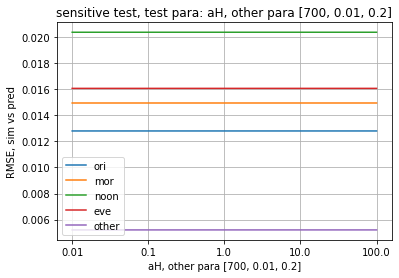

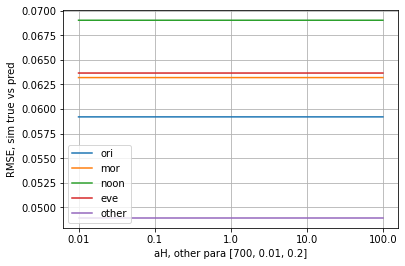

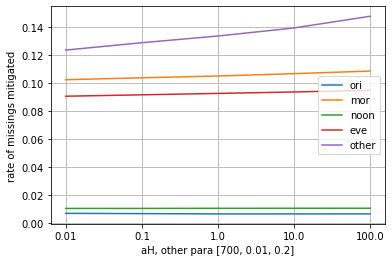

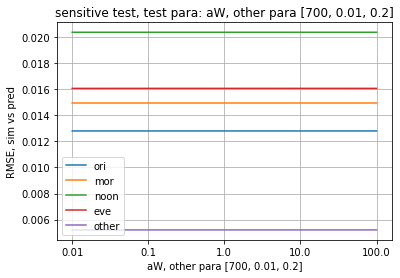

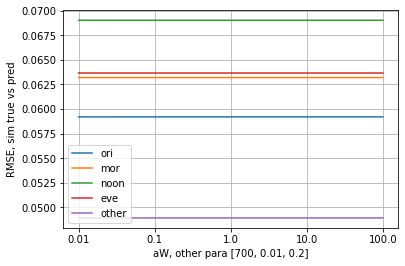

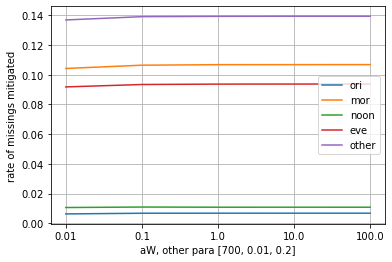

In [62]:
idx = plot_paras_sensitive(test_aWaH_nmf2, aWaH_nmf_2, 'aH, other para '+str([700, 0.01, 0.2]), 2, 1)
idx = plot_paras_sensitive(test_aWaH_nmf3, aWaH_nmf_3, 'aW, other para '+str([700, 0.01, 0.2]), 1, idx)

###### l1 RATIO

In [12]:
l1_ratio_nmf_1 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [700, 0.01, 0.01], 4)
l1_ratio_nmf_2 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [700, 10, 10], 4)
l1_ratio_nmf_3 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [700, 0.1, 0.01], 4)
l1_ratio_nmf_4 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [700, 0.01, 0.1], 4)
l1_ratio_nmf_5 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [700, 0.01, 10], 4)
l1_ratio_nmf_6 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [700, 10, 0.01], 4)

In [13]:
test_l1_nmf_1 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_1,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_2 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_2,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_3 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_3,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_4 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_4,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_5 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_5,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_6 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_6,
                                            0, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.0], 0.01173566470627472
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.0], 0.057673254848958556
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.005668860424774839


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.0],mor, 0.013514124402139251
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.0],mor, 0.061632150549790155
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.2130532349748521
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.0],noon, 0.018277889583429387
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.0],noon, 0.06664227916980078
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008864198390860646
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.0],eve, 0.014301980886192228
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.0],eve, 0.06151809464593117
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.19678980745621694
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.0],other, 0.0049818338138459374
RMSE with True, d

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.1], 0.011815061761872869
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.1], 0.057743319442301856
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0049019945399149


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.1],mor, 0.013706831068152974
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.1],mor, 0.06172944639368578
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5552611629236547
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.1],noon, 0.01845513312876325
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.1],noon, 0.06673603146157374
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.006720227245461476
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.1],eve, 0.01451305320817616
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.1],eve, 0.06161869034827257
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.5532655811371213
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.1],other, 0.005031228960896347
RMSE with True, data w

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.2], 0.011849085402576695
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.2], 0.05777854785595459
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004408696321735609


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.2],mor, 0.013799881901737974
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.2],mor, 0.061758961174265325
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5939917038365349
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.2],noon, 0.01853023495814642
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.2],noon, 0.06684656321827635
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.006485125716430791
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.2],eve, 0.014617829168733864
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.2],eve, 0.06165244101139147
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.5304611198139986
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.2],other, 0.005049527678664877
RMSE with True, data

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.30000000000000004], 0.01186640980854933
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.30000000000000004], 0.057803694570213164
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004215884327827967


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.30000000000000004],mor, 0.013853679943536012
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.30000000000000004],mor, 0.06177548043603351
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5770241102528391
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.30000000000000004],noon, 0.0185737123534071
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.30000000000000004],noon, 0.06691781784309528
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.006009117682343972
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.30000000000000004],eve, 0.01467769185707179
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.30000000000000004],eve, 0.061671158407726766
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.5029258209892794
RMSE, data with

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.4], 0.011876484105340935
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.4], 0.05782362314336215
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004322619538741125


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.4],mor, 0.013886641889154061
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.4],mor, 0.0617852609317655
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.56126542937809
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.4],noon, 0.01860134142031222
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.4],noon, 0.06696918088782733
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005944295450059791
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.4],eve, 0.014714251983604673
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.4],eve, 0.061682496824135936
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4846228232282818
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.4],other, 0.00506240536854485
RMSE with True, data wit

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.5], 0.011883140145778254
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.5], 0.057840416022146464
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004114157220652668


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.5],mor, 0.013908025156576187
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.5],mor, 0.061791667303877015
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5387821715598248
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.5],noon, 0.018620189527692226
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.5],noon, 0.06700849599715834
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005971385338178553
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.5],eve, 0.01473826944637437
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.5],eve, 0.06168988511483763
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.46979953238994615
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.5],other, 0.005065021026261886
RMSE with True, dat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.6000000000000001], 0.011887758016663646
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.6000000000000001], 0.05785327086008686
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004034966580297744


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.6000000000000001],mor, 0.01392246562593082
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.6000000000000001],mor, 0.061795944983550205
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5407693218251559
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.6000000000000001],noon, 0.01863376020429825
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.6000000000000001],noon, 0.06703886932196444
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005748861257203008
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.6000000000000001],eve, 0.014754642500031693
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.6000000000000001],eve, 0.061694839251031496
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.46616082762287797
RMSE, data with mi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.7000000000000001], 0.011891335495563446
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.7000000000000001], 0.05786457008807493
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.003903816863662514


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.7000000000000001],mor, 0.013932796256224721
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.7000000000000001],mor, 0.06179899598092792
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5306144550700036
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.7000000000000001],noon, 0.018644090152214774
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.7000000000000001],noon, 0.06706335491682165
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005697583968978208
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.7000000000000001],eve, 0.01476641529664665
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.7000000000000001],eve, 0.06169838652641195
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.44270994883397236
RMSE, data with mis

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.8], 0.011894158426846343
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.8], 0.05787394171683563
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0037507566931741423


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.8],mor, 0.013940396551460869
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.8],mor, 0.061801216514477536
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.529244353999864
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.8],noon, 0.01865227448608238
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.8],noon, 0.06708384410686917
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005838838385597468
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.8],eve, 0.01477511361637245
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.8],eve, 0.0617009843376619
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.44110433125767295
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.8],other, 0.0050686676911282594
RMSE with True, data 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.9], 0.01189646285461778
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.9], 0.05788194087320356
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.003692224480737894


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.9],mor, 0.013946158454853634
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.9],mor, 0.06180289411458623
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5271740909857927
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.9],noon, 0.01865885430285167
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.9],noon, 0.0671008232531407
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005881408209784093
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.9],eve, 0.014781769735851814
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 0.9],eve, 0.061702941078573444
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.43948828759321573
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 0.9],other, 0.005069275622437096
RMSE with True, data

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 1.0], 0.011898406361436195
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 1.0], 0.057888948369208146
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0035754730623490136


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 1.0],mor, 0.013950638552977753
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 1.0],mor, 0.06180418879683472
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5255319845561401
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 1.0],noon, 0.01866432334259119
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 1.0],noon, 0.06711550114209967
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.00586592827371623
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 1.0],eve, 0.01478698858195044
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.01, 1.0],eve, 0.061704482082243314
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.43816417439717664
RMSE, data with missing rate>=0, para=[700, 0.01, 0.01, 1.0],other, 0.005069738415227472
RMSE with True, data 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.0], 0.01191325760917174
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.0], 0.057943787987128584
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.0],mor, 0.013973849779817308
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.0],mor, 0.06180785382346702
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.1294946996733417
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.0],noon, 0.018704931499753236
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.0],noon, 0.06723018669753171
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.00046439808203592117
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.0],eve, 0.014815509010470776
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.0],eve, 0.061709523257827595
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.11059994317781954
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.0],other, 0.005071900274461933
RMSE with True, data with missing rate>=0, p

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.1], 0.011913922516820538
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.1], 0.05794641652359782
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004783678089107938


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.1],mor, 0.013974950195852136
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.1],mor, 0.06181111751302499
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14839151645506496
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.1],noon, 0.018706342345070973
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.1],noon, 0.06723480821696444
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008360132972650824
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.1],eve, 0.014816727816041136
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.1],eve, 0.06171310314388066
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12792028212994555
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.1],other, 0.00507204125350232
RMSE with True, data with missing rate>=0, para

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.2], 0.01191392340649481
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.2], 0.057946419024252134
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004799015406805137


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.2],mor, 0.01397495194202207
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.2],mor, 0.06181111801052142
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14878441308547263
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.2],noon, 0.018706344509930972
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.2],noon, 0.0672348122805841
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008389157852778068
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.2],eve, 0.014816729964609563
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.2],eve, 0.06171310376654514
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12813662345921967
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.2],other, 0.005072041419717818
RMSE with True, data with missing rate>=0, para=

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.30000000000000004], 0.01191392357380269
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.30000000000000004], 0.057946419493688485
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0048105966466989395


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.30000000000000004],mor, 0.013974952273821284
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.30000000000000004],mor, 0.06181111810486761
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14896071285552737
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.30000000000000004],noon, 0.018706344915491443
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.30000000000000004],noon, 0.06723481303627057
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008415280244892588
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.30000000000000004],eve, 0.01481673037508045
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.30000000000000004],eve, 0.06171310388523337
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12824349086283698
RMSE, data with missing rate>=0, par

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.4], 0.011913923632498071
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.4], 0.057946419658224044
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004815291743953184


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.4],mor, 0.013974952390584633
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.4],mor, 0.061811118138054975
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14912693835300755
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.4],noon, 0.01870634505762672
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.4],noon, 0.06723481330042681
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008421085220918037
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.4],eve, 0.014816730519700646
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.4],eve, 0.06171310392703003
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12835035826645433
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.4],other, 0.005072041462085866
RMSE with True, data with missing rate>=0, par

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.5], 0.011913923659679474
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.5], 0.05794641973437786
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.00481654376988765


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.5],mor, 0.013974952444736947
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.5],mor, 0.06181111815344418
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14924531105575858
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.5],noon, 0.01870634512341884
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.5],noon, 0.06723481342253977
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.00841624774089683
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.5],eve, 0.014816730586801123
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.5],eve, 0.061713103946419115
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.1284207343615194
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.5],other, 0.005072041467191627
RMSE with True, data with missing rate>=0, para=

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.6000000000000001], 0.011913923674445567
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.6000000000000001], 0.05794641977573325
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0048168567763712655


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.6000000000000001],mor, 0.01397495247418032
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.6000000000000001],mor, 0.06181111816181092
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14932086810006776
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.6000000000000001],noon, 0.01870634515915111
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.6000000000000001],noon, 0.0672348134888075
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.00842205271692228
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.6000000000000001],eve, 0.01481673062329184
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.6000000000000001],eve, 0.061713103956962376
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12846765175822944
RMSE, data with missing rate>=0, para=[700, 1

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.7000000000000001], 0.011913923683348418
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.7000000000000001], 0.05794641980066125
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004817482789338499


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.7000000000000001],mor, 0.013974952491942591
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.7000000000000001],mor, 0.0618111181668581
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14938635087180235
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.7000000000000001],noon, 0.0187063451806917
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.7000000000000001],noon, 0.06723481352873448
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008424955204935004
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.7000000000000001],eve, 0.01481673064530788
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.7000000000000001],eve, 0.06171310396332316
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12853542133125506
RMSE, data with missing rate>=0, para=[700, 1

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.8], 0.011913923689126074
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.8], 0.05794641981683573
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004817169782854882


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.8],mor, 0.01397495250347436
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.8],mor, 0.06181111817013481
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14946190791611152
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.8],noon, 0.018706345194669394
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.8],noon, 0.06723481355463311
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008424955204935004
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.8],eve, 0.014816730659602196
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.8],eve, 0.06171310396745289
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.1285979778602018
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.8],other, 0.005072041472727638
RMSE with True, data with missing rate>=0, para=

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.9], 0.011913923693086751
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.9], 0.057946419827922035
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0048177957958221145


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 0.9],mor, 0.013974952511381953
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.9],mor, 0.0618111181723817
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14953998352856435
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.9],noon, 0.018706345204250626
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.9],noon, 0.06723481357238059
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008414312748888347
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.9],eve, 0.014816730669404506
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 0.9],eve, 0.06171310397028478
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.1287256974401347
RMSE, data with missing rate>=0, para=[700, 10, 10, 0.9],other, 0.005072041473472774
RMSE with True, data with missing rate>=0, para=

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 1.0], 0.011913923695919487
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 1.0], 0.057946419835850235
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0048177957958221145


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 10, 1.0],mor, 0.01397495251703889
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 1.0],mor, 0.06181111817398906
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.1495953920277244
RMSE, data with missing rate>=0, para=[700, 10, 10, 1.0],noon, 0.01870634521110288
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 1.0],noon, 0.06723481358507027
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008412377756879865
RMSE, data with missing rate>=0, para=[700, 10, 10, 1.0],eve, 0.014816730676417056
RMSE with True, data with missing rate>=0, para=[700, 10, 10, 1.0],eve, 0.061713103972310696
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.1287752213588842
RMSE, data with missing rate>=0, para=[700, 10, 10, 1.0],other, 0.0050720414740058105
RMSE with True, data with missing rate>=0, para=

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.0], 0.011832227072377901
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.0], 0.057740411978833006
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0031147275184658174


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.0],mor, 0.013801978287009088
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.0],mor, 0.06167900032358089
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.1505776336037436
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.0],noon, 0.01851272571191331
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.0],noon, 0.06678630905251579
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.004693323116575529
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.0],eve, 0.014622951576128322
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.0],eve, 0.06156902735667993
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.13049552590491928
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.0],other, 0.005039369862078812
RMSE with True, data with m

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.1], 0.011886285189205684
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.1], 0.057873253588875295
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.003914146077621852


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.1],mor, 0.013921817715482567
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.1],mor, 0.061794262953106076
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.3416160644350474
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.1],noon, 0.01863123330449645
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.1],noon, 0.06707341696510345
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005733381321135144
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.1],eve, 0.014755578038099971
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.1],eve, 0.0616928502951825
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.25549389682864465
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.1],other, 0.005065838952762707
RMSE with True, data with m

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.2], 0.011898678679610647
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.2], 0.05789900711949643
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.003579855153119642


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.2],mor, 0.013949460767845503
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.2],mor, 0.061803382036024035
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.4956718406451564
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.2],noon, 0.01866353592271461
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.2],noon, 0.06713262407809233
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005425717591786346
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.2],eve, 0.014787141983495093
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.2],eve, 0.06170397198894329
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4045426466103484
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.2],other, 0.0050693604900734
RMSE with True, data with mis

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.30000000000000004], 0.011903655436169766
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.30000000000000004], 0.05791198148311588
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0033066004929226105


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.30000000000000004],mor, 0.01395983136886169
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.30000000000000004],mor, 0.06180661317254528
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5129769223600998
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.30000000000000004],noon, 0.018677673559884932
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.30000000000000004],noon, 0.06716183239649957
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.0053415454394173355
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.30000000000000004],eve, 0.01479906474399953
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.30000000000000004],eve, 0.061707739114411936
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4061195924442139
RMSE, data with mis

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.4], 0.011906353758482686
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.4], 0.05792014877743317
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.003071532623726768


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.4],mor, 0.013964809383178275
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.4],mor, 0.06180813089209558
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5021798207283196
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.4],noon, 0.018685414705768285
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.4],noon, 0.06717973132115031
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005475059888002663
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.4],eve, 0.014804762996349679
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.4],eve, 0.061709507959633786
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.43344115646169845
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.4],other, 0.005071028184504126
RMSE with True, data with

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.5], 0.01190805986948263
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.5], 0.05792571697956345
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.002958537283141283


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.5],mor, 0.013967593175266543
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.5],mor, 0.06180896791483752
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5072043641748794
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.5],noon, 0.01869025115414184
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.5],noon, 0.06719153266831238
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005429587575803312
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.5],eve, 0.014808004387895929
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.5],eve, 0.06171050500767671
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4273679601097867
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.5],other, 0.005071316519456175
RMSE with True, data with mi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.6000000000000001], 0.011909220439446063
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.6000000000000001], 0.057929644928877005
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.002957598263690434


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.6000000000000001],mor, 0.013969340002789429
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.6000000000000001],mor, 0.06180948914902999
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5201901015234819
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.6000000000000001],noon, 0.018693538788600673
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.6000000000000001],noon, 0.06719990572736616
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005371537815548822
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.6000000000000001],eve, 0.014810034168123074
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.6000000000000001],eve, 0.06171112556567555
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4307929300696202
RMSE, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.7000000000000001], 0.01191006173118935
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.7000000000000001], 0.05793256218365961
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0030377279234962075


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.7000000000000001],mor, 0.013970525785014787
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.7000000000000001],mor, 0.06180984061542666
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5112970374082927
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.7000000000000001],noon, 0.018695874656646287
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.7000000000000001],noon, 0.0672059744632475
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005461514943943282
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.7000000000000001],eve, 0.014811402548115938
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.7000000000000001],eve, 0.061711539230107255
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4331153412067676
RMSE, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.8], 0.011912233494371574
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.8], 0.05794175008415826
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004824368931978057


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.8],mor, 0.013971364597683627
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.8],mor, 0.06181008713795013
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5222452531286913
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.8],noon, 0.01870219981890994
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.8],noon, 0.06722722861365071
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008400767804828966
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.8],eve, 0.014812382512715366
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.8],eve, 0.061711833040800766
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.43496597185477504
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.8],other, 0.005071700282481341
RMSE with True, data with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.9], 0.011912528674962534
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.9], 0.057942545399534674
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004811222659666172


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.9],mor, 0.013971988332300317
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.9],mor, 0.061810269295937276
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5230461577983685
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.9],noon, 0.018702954197412677
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.9],noon, 0.06722861434076766
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008404637788845933
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.9],eve, 0.014813112201510676
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 0.9],eve, 0.06171205027715067
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.43527875449950865
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 0.9],other, 0.005071762581129139
RMSE with True, data with

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 1.0], 0.011912754853138145
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 1.0], 0.05794316202961743
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004832820107035697


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 1.0],mor, 0.013972466510945135
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 1.0],mor, 0.06181040819244388
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5134252274896676
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 1.0],noon, 0.018703523148309417
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 1.0],noon, 0.06722965882144565
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008426890196943487
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 1.0],eve, 0.014813672922933206
RMSE with True, data with missing rate>=0, para=[700, 0.1, 0.01, 1.0],eve, 0.06171221624702193
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.43587564804654205
RMSE, data with missing rate>=0, para=[700, 0.1, 0.01, 1.0],other, 0.005071809728701206
RMSE with True, data with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.0], 0.011832848051256459
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.0], 0.05774436648185401
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0030702805977923025


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.0],mor, 0.013801749544240117
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.0],mor, 0.06167823830528814
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.15062548639847273
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.0],noon, 0.018513248662843033
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.0],noon, 0.06679065897075383
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.0046255983962786235
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.0],eve, 0.014622943788301508
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.0],eve, 0.061566399396246474
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12965883233025677
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.0],other, 0.005039371531932933
RMSE with True, data wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.1], 0.011882817810989968
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.1], 0.05784138644158807
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004177384530343162


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.1],mor, 0.013910345233059724
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.1],mor, 0.061792058129430165
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.6026152811603547
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.1],noon, 0.01862530881712154
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.1],noon, 0.06702837211227562
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.010546673942236618
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.1],eve, 0.014742883843773024
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.1],eve, 0.061690667560655485
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.5731194595115899
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.1],other, 0.00506296772670652
RMSE with True, data with m

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.2], 0.0118944893173536
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.2], 0.05787592155012859
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.003719143038328896


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.2],mor, 0.013940985646040615
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.2],mor, 0.06180122472131836
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.6062420192871948
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.2],noon, 0.018656569683060696
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.2],noon, 0.06709815110417695
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.006680559909287575
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.2],eve, 0.0147770363651909
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.2],eve, 0.061701345149169494
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.5441271148668197
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.2],other, 0.0050680647514821375
RMSE with True, data with m

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.30000000000000004], 0.011900535888043115
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.30000000000000004], 0.05789725476482488
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.003477502032977111


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.30000000000000004],mor, 0.013954879437777628
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.30000000000000004],mor, 0.06180532888305326
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5650483187298357
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.30000000000000004],noon, 0.018671877146195188
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.30000000000000004],noon, 0.06713776633828046
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005908498097902856
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.30000000000000004],eve, 0.014792830017683865
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.30000000000000004],eve, 0.06170608505932991
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.5071614193033809
RMSE, data with mis

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.4], 0.011904294473337617
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.4], 0.057911106414288246
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0032721697797248174


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.4],mor, 0.013961983659055266
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.4],mor, 0.06180739436882833
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5560167333667463
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.4],noon, 0.01868125251755673
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.4],noon, 0.06716381262159873
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005811748497478705
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.4],eve, 0.014801111952791145
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.4],eve, 0.061708531597441704
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4845159558246645
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.4],other, 0.0050707309409899265
RMSE with True, data with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.5], 0.011906759133852847
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.5], 0.05792024154130664
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0030608904032838136


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.5],mor, 0.013966016136240551
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.5],mor, 0.061808559623119146
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5272194252123783
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.5],noon, 0.01868750839223563
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.5],noon, 0.06718161235978035
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005755633729232698
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.5],eve, 0.014805886171672892
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.5],eve, 0.06170994196778929
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4660148623886689
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.5],other, 0.005071165667406024
RMSE with True, data with m

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.6000000000000001], 0.011908445832199431
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.6000000000000001], 0.057926481499369804
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0031181705897855966


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.6000000000000001],mor, 0.01396846956355388
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.6000000000000001],mor, 0.06180926461136114
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5225147399200607
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.6000000000000001],noon, 0.018691819115584683
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.6000000000000001],noon, 0.067193881155865
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.005719836377075763
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.6000000000000001],eve, 0.014808826249998115
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.6000000000000001],eve, 0.06171080406007231
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4482435951237186
RMSE, data with missing rate

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.7000000000000001], 0.011909633968063571
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.7000000000000001], 0.05793085353533791
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0030474311244883126


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.7000000000000001],mor, 0.013970055379774454
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.7000000000000001],mor, 0.06180971852766088
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5290730913660966
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.7000000000000001],noon, 0.018694871706946684
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.7000000000000001],noon, 0.06720254409976162
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.00562792425667282
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.7000000000000001],eve, 0.014810741625910548
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.7000000000000001],eve, 0.06171136271952978
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.45440801974701095
RMSE, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.8], 0.011912149233483356
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.8], 0.05794147598311039
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004844401346929501


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.8],mor, 0.013971140624638853
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.8],mor, 0.0618100291727896
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5177244233108593
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.8],noon, 0.01870209003799927
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.8],noon, 0.06722708790557994
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008432695172968935
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.8],eve, 0.01481205296260721
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.8],eve, 0.06171174464057591
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.45106645849243976
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.8],other, 0.005071682783579806
RMSE with True, data with mis

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.9], 0.011912496931573879
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.9], 0.05794244246548013
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004839080236708023


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.9],mor, 0.013971906727560171
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.9],mor, 0.061810248396182314
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5168932958234584
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.9],noon, 0.018702914253190244
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.9],noon, 0.0672285670770478
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008434630164977419
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.9],eve, 0.014812988540678747
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 0.9],eve, 0.06171201719613453
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4394622223728213
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 0.9],other, 0.0050717564271250464
RMSE with True, data with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 1.0], 0.011912753701141329
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 1.0], 0.0579431569395016
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004836576184839092


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 1.0],mor, 0.013972467127349923
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 1.0],mor, 0.06181040850044581
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5168026273702875
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 1.0],noon, 0.018703525913181102
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 1.0],noon, 0.06722966993163802
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008433662668973177
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 1.0],eve, 0.014813672987728062
RMSE with True, data with missing rate>=0, para=[700, 0.01, 0.1, 1.0],eve, 0.06171221629113459
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.43904517884650973
RMSE, data with missing rate>=0, para=[700, 0.01, 0.1, 1.0],other, 0.005071809700743383
RMSE with True, data with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.0], 0.011901701223357899
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.0], 0.05790740521581849
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.001543121964228367


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.0],mor, 0.013953347418378382
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.0],mor, 0.06177050936064155
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.1350708095433584
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.0],noon, 0.018678440435997513
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.0],noon, 0.06715982292990914
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.0025977267713884343
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.0],eve, 0.014792179371859044
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.0],eve, 0.06166701408463623
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.11691293955736043
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.0],other, 0.0050678005593344025
RMSE with True, data with missi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.1], 0.011913277261762145
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.1], 0.057944462239465144
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004527638785509803


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.1],mor, 0.01397370746076888
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.1],mor, 0.06181076375073568
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14680733709271604
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.1],noon, 0.01870509297980627
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.1],noon, 0.06723271056705246
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.007654828385558768
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.1],eve, 0.01481522059491735
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.1],eve, 0.0617126674234733
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12629902542140944
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.1],other, 0.005071882275152297
RMSE with True, data with missing ra

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.2], 0.011913688790472507
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.2], 0.05794572913176712
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004651276346538242


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.2],mor, 0.01397449341558615
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.2],mor, 0.061810988077436846
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14815980818585017
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.2],noon, 0.018705857076622114
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.2],noon, 0.06723392460514513
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.00808149412342927
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.2],eve, 0.01481617006062905
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.2],eve, 0.0617129423984125
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12716178421646646
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.2],other, 0.005071991027252262
RMSE with True, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.30000000000000004], 0.01191380495445065
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.30000000000000004], 0.057946077666520004
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.00474705633052483


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.30000000000000004],mor, 0.013974718858531602
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.30000000000000004],mor, 0.06181105199315123
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14869878176858892
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.30000000000000004],noon, 0.018706084449823076
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.30000000000000004],noon, 0.06723433066605033
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.00811342149156924
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.30000000000000004],eve, 0.01481644418644598
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.30000000000000004],eve, 0.0617130214175681
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12773521906514482
RMSE, data with missing ra

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.4], 0.011913852988699208
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.4], 0.05794621845237255
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0047733488751486


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.4],mor, 0.013974812792756077
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.4],mor, 0.06181107857588874
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14889523008379277
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.4],noon, 0.01870618431942635
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.4],noon, 0.06723451482039941
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.0082546759081885
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.4],eve, 0.014816558703869035
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.4],eve, 0.06171305439416962
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12799326474705006
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.4],other, 0.005072027653451755
RMSE with True, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.5], 0.01191387712661024
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.5], 0.05794628810536373
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004798389393837904


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.5],mor, 0.013974860179411396
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.5],mor, 0.061811091987472505
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14924531105575858
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.5],noon, 0.01870623685386185
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.5],noon, 0.0672346124993479
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.00839109284478655
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.5],eve, 0.01481661677619482
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.5],eve, 0.061713071116435085
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.1281939669440875
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.5],other, 0.005072032519834497
RMSE with True, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.6000000000000001], 0.01191389084398187
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.6000000000000001], 0.05794632729189582
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004815291743953184


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.6000000000000001],mor, 0.013974887209075653
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.6000000000000001],mor, 0.06181109964305259
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14934857234964777
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.6000000000000001],noon, 0.01870626768115724
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.6000000000000001],noon, 0.0672346698809372
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008387222860769586
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.6000000000000001],eve, 0.014816649998976184
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.6000000000000001],eve, 0.06171308068805037
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12841291479540104
RMSE, data with missing rate>=0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.7000000000000001], 0.0119138993383163
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.7000000000000001], 0.057946351398856996
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004820612854174662


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.7000000000000001],mor, 0.013974904001594226
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.7000000000000001],mor, 0.06181110440255847
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14945183364353698
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.7000000000000001],noon, 0.018706287198150325
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.7000000000000001],noon, 0.06723470617300048
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008401735300833208
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.7000000000000001],eve, 0.014816670681676487
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.7000000000000001],eve, 0.06171308665065861
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12850153654474225
RMSE, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.8], 0.01191390494362362
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.8], 0.05794636723720348
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004823116906043591


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.8],mor, 0.013974915113049515
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.8],mor, 0.061811107553718395
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.1494266479621006
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.8],noon, 0.018706300276615982
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.8],noon, 0.06723473045782132
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008414312748888347
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.8],eve, 0.014816684388294641
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.8],eve, 0.06171309060436525
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12857451916184678
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.8],other, 0.005072037933038586
RMSE with True, data with missin

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.9], 0.011913908828207455
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.9], 0.05794637818061516
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004822177886592743


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.9],mor, 0.013974922830417092
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.9],mor, 0.06181110974330658
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14944931507539333
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.9],noon, 0.018706309438530928
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.9],noon, 0.06723474744774076
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008412377756879865
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.9],eve, 0.014816693919333972
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 0.9],eve, 0.06171309335485837
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.1286709604773063
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 0.9],other, 0.005072038672572137
RMSE with True, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 1.0], 0.011913911626998985
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 1.0], 0.057946386048626675
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0048240559254944405


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 0.01, 10, 1.0],mor, 0.013974928400382206
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 1.0],mor, 0.0618111113241548
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14952739068784615
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 1.0],noon, 0.018706316090489315
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 1.0],noon, 0.0672347597698167
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008418182732905313
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 1.0],eve, 0.014816700804470496
RMSE with True, data with missing rate>=0, para=[700, 0.01, 10, 1.0],eve, 0.061713095342482836
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12874133657237138
RMSE, data with missing rate>=0, para=[700, 0.01, 10, 1.0],other, 0.005072039203095703
RMSE with True, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.0], 0.011901695611019508
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.0], 0.05790712489372876
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0014855287712429676


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.0],mor, 0.013953011315847164
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.0],mor, 0.06177002579289403
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.13539570483388783
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.0],noon, 0.018678420126534517
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.0],noon, 0.06715943643166312
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.002588051811346019
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.0],eve, 0.014791839761137168
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.0],eve, 0.061666416633506055
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.11679303954354586
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.0],other, 0.005067903590393364
RMSE with True, data with missi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.1], 0.011913570809487418
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.1], 0.05794572418378271
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0051708671093413025


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.1],mor, 0.01397429737113115
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.1],mor, 0.061810897680181484
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.1442006190640497
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.1],noon, 0.01870531381652708
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.1],noon, 0.0672331470710392
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.007161405423395602
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.1],eve, 0.014815956477719463
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.1],eve, 0.06171283758642823
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12672388851383934
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.1],other, 0.005071975463674768
RMSE with True, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.2], 0.011913782635962603
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.2], 0.057946091798964254
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004960526752351148


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.2],mor, 0.013974690868464552
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.2],mor, 0.06181103837393561
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14573946419981312
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.2],noon, 0.01870594579617876
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.2],noon, 0.06723410537101517
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.007449719232659569
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.2],eve, 0.014816423679818383
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.2],eve, 0.06171300770143186
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12654143197107803
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.2],other, 0.0050720149464588546
RMSE with True, data with missin

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.30000000000000004], 0.011913843920526692
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.30000000000000004], 0.057946218413385785
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004858173632208617


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.30000000000000004],mor, 0.013974802783716616
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.30000000000000004],mor, 0.061811073600409334
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.1460945823080662
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.30000000000000004],noon, 0.018706127688718186
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.30000000000000004],noon, 0.0672344136989061
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.007787375338139854
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.30000000000000004],eve, 0.014816554712138214
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.30000000000000004],eve, 0.061713050471663755
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12665351241877426
RMSE, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.4], 0.011913871352857427
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.4], 0.05794628197799465
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004823429912527208


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.4],mor, 0.013974853118739486
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.4],mor, 0.06181108898429436
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14633132771356827
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.4],noon, 0.018706206889918895
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.4],noon, 0.06723455582253195
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.00797893954697967
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.4],eve, 0.014816613038537988
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.4],eve, 0.061713068709824376
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12681511678521998
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.4],other, 0.005072031541311066
RMSE with True, data with missin

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.5], 0.011913886334201049
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.5], 0.05794631903182884
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0048218648801091266


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.5],mor, 0.013974880823743608
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.5],mor, 0.061811097320362565
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14656051741463944
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.5],noon, 0.018706248739322456
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.5],noon, 0.067234632693696
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008195658651929767
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.5],eve, 0.014816645170541428
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.5],eve, 0.06171307860018197
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12682554287337777
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.5],other, 0.005072034368727564
RMSE with True, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.6000000000000001], 0.011913895562677532
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.6000000000000001], 0.05794634281607105
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004807153575379161


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.6000000000000001],mor, 0.0139748980019942
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.6000000000000001],mor, 0.0618111024327017
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.1466486672996668
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.6000000000000001],noon, 0.0187062739698208
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.6000000000000001],noon, 0.06723468000253315
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008285635780324227
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.6000000000000001],eve, 0.014816665145104838
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.6000000000000001],eve, 0.0617130846837761
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.1269662950635079
RMSE, data with missing rate>=0, para

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.7000000000000001], 0.011913901711778103
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.7000000000000001], 0.057946359095046626
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0048105966466989395


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.7000000000000001],mor, 0.013974909533686691
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.7000000000000001],mor, 0.061811105832827055
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14675444716169964
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.7000000000000001],noon, 0.01870629043000459
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.7000000000000001],noon, 0.0672347111779001
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008318530644468438
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.7000000000000001],eve, 0.014816678595720459
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.7000000000000001],eve, 0.06171308874122365
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12698454071778403
RMSE, data with missing rate>=

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.8], 0.011913906045000727
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.8], 0.057946370776284034
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004803084491092149


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.8],mor, 0.013974917723577545
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.8],mor, 0.06181110822822438
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14681237422900334
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.8],noon, 0.018706301783386683
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.8],noon, 0.06723473270483049
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008366905444680514
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.8],eve, 0.014816688185246205
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.8],eve, 0.06171309160880769
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.1270549168128491
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.8],other, 0.005072038130335159
RMSE with True, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.9], 0.011913909228112451
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.9], 0.05794637946539039
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.0047930682836164265


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.9],mor, 0.013974923786867939
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.9],mor, 0.061811109989384605
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14684511561487062
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.9],noon, 0.01870630996131355
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.9],noon, 0.06723474816430379
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008392060340790793
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.9],eve, 0.014816695319638886
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 0.9],eve, 0.06171309372591014
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.1271696037825848
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 0.9],other, 0.005072038741228203
RMSE with True, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 1.0], 0.01191391164149477
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 1.0], 0.05794638611156321
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.004816230763404033


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[700, 10, 0.01, 1.0],mor, 0.01397492842046432
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 1.0],mor, 0.061811111327328895
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.14692570979546707
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 1.0],noon, 0.018706316057068
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 1.0],noon, 0.06723475963904066
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.008401735300833208
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 1.0],eve, 0.014816700804470196
RMSE with True, data with missing rate>=0, para=[700, 10, 0.01, 1.0],eve, 0.06171309534263086
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.12719566900297927
RMSE, data with missing rate>=0, para=[700, 10, 0.01, 1.0],other, 0.005072039203600078
RMSE with True, data with missing r

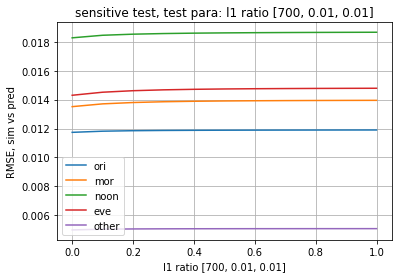

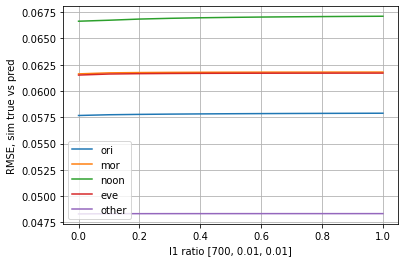

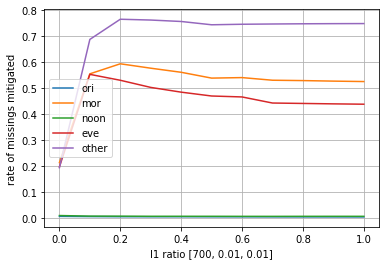

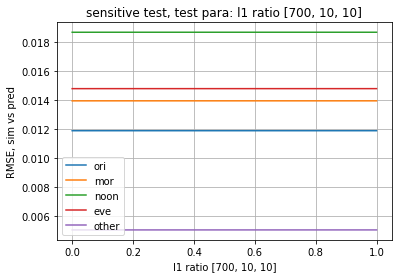

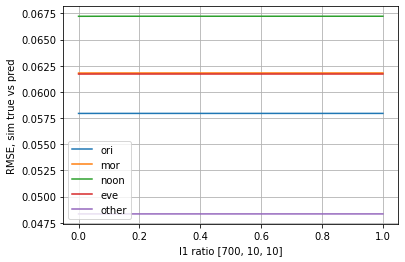

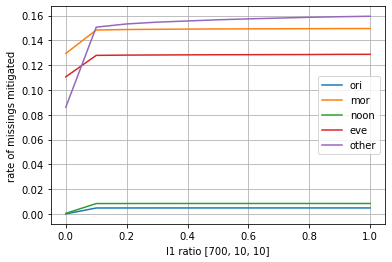

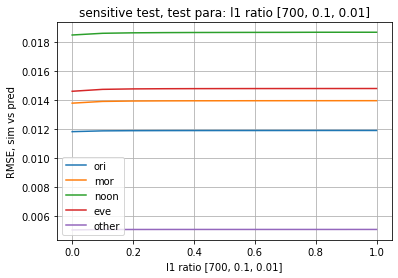

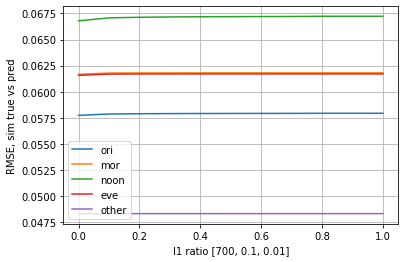

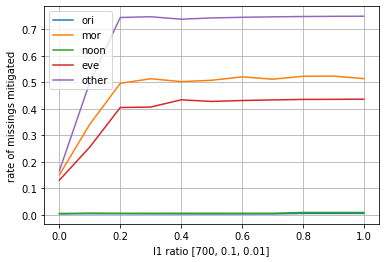

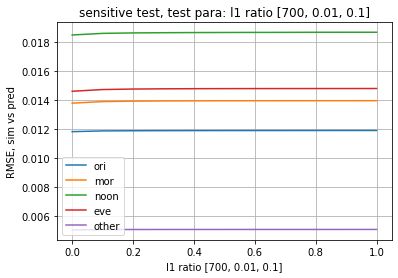

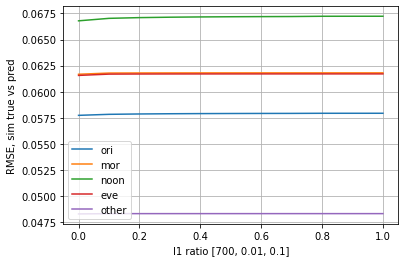

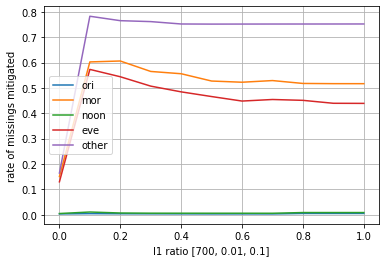

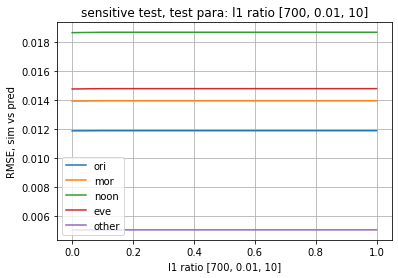

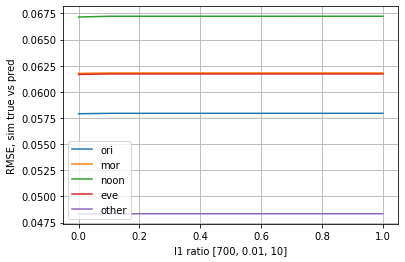

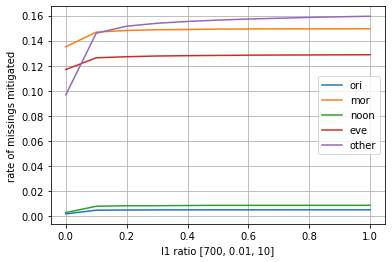

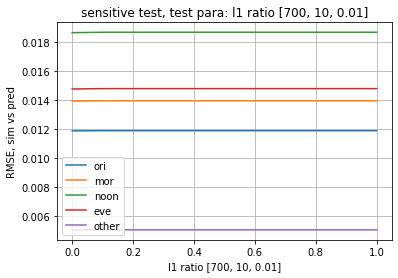

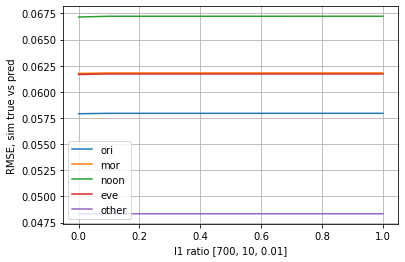

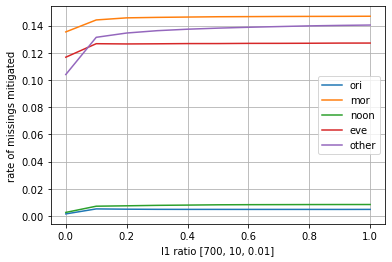

In [22]:
idx = plot_paras_sensitive(test_l1_nmf_1, l1_ratio_nmf_1, 'l1 ratio '+str(l1_ratio_nmf_1[0][:3]), 3, 1)
idx = plot_paras_sensitive(test_l1_nmf_2, l1_ratio_nmf_2, 'l1 ratio '+str(l1_ratio_nmf_2[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_3, l1_ratio_nmf_3, 'l1 ratio '+str(l1_ratio_nmf_3[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_4, l1_ratio_nmf_4, 'l1 ratio '+str(l1_ratio_nmf_4[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_5, l1_ratio_nmf_5, 'l1 ratio '+str(l1_ratio_nmf_5[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_6, l1_ratio_nmf_6, 'l1 ratio '+str(l1_ratio_nmf_6[0][:3]), 3, idx)

In [ ]:
test_k_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', k_nmf_100, 
                                          0, 288, result_para_dict, 'NMF')

In [ ]:
#para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
#para_lst_bmf = [k_val, lambda_w, lambda_h]
#k_nmf = generate_paralst(list(np.array(range(1, 21))*10), [0], [0, 0, 0], 4)
#k_nmf = generate_paralst(list(np.array(range(1, 11))*100), [0], [0, 0, 0], 4)
#test_k_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', k_nmf, 
#                                          0.05, 288, result_para_dict, 'NMF')
test_aWaH_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')
test_aW_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aW_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')
test_aH_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aW_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')
test_l1r_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0] 0.011385092232853547
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0] 0.05798719048789278
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01036106121491941


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],mor 0.009578210046726484
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],mor 0.061453210461100964
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15031143774093697


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],noon 0.01708249789776988
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],noon 0.06657486355458779
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014289089846705048


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],eve 0.010234970267176404
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],eve 0.061827433564115776
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13265968112921933


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],other 0.0035880959133879685
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],other 0.04850931475106625
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2651037202590837


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0] 0.011384106270741145
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0] 0.05798352886308953
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010513646354776357


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],mor 0.009582367284772322
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],mor 0.061453431295048384
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15157902732676276


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],noon 0.01708201125543513
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],noon 0.06657222202220119
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014257950950743762


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],eve 0.010226188530872244
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],eve 0.061824369709899615
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13207973735427683


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],other 0.0035852234140098496
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],other 0.04851417895707773
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26431849497130333


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0] 0.011384846888831183
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0] 0.05797535424539311
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010559009504463557


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],mor 0.009573768863177975
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],mor 0.061448232696405376
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1507197250232629


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],noon 0.01708142204213835
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],noon 0.0665729591408647
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014278099648130475


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],eve 0.01022682718674531
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],eve 0.06182457417914234
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13225666935341185


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],other 0.0035864951002883725
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],other 0.0485160091158117
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2572840155797377


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0] 0.011383183295854847
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0] 0.057976865044137044
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010596124808753086


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],mor 0.009576390268108054
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],mor 0.06145689073781746
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15165498775138153


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],noon 0.017081445122526493
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],noon 0.06657295899686996
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014278099648130475


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],eve 0.010237198802163873
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],eve 0.06182580054668351
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13181433935557435


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],other 0.003588683924383345
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],other 0.048513285150813046
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26643005934621516


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0] 0.01138510125844128
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0] 0.0579786085106827
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010488902818583338


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],mor 0.009571631844055522
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],mor 0.06145950196936573
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1521772156706356


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],noon 0.017078011801785545
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],noon 0.06656252924236208
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014309238544091761


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],eve 0.01023225162098114
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],eve 0.06182929579718144
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.1311901625808481


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],other 0.0035839290126105532
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],other 0.04850673269423114
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2689281335778065


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0] 0.011385485462427652
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0] 0.05798396385718136
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010468283205089156


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],mor 0.009581766923855942
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],mor 0.0614509947342764
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15047760116979053


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],noon 0.017078025998641475
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],noon 0.06656250729755095
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014312901943616618


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],eve 0.010236667958349047
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],eve 0.06182750365000249
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13227632846442683


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],other 0.0035837040859236155
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],other 0.04851294794842371
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.25976581571210033


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0] 0.01138257313191781
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0] 0.05797653395144794
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010587876963355412


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],mor 0.009578037062110467
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],mor 0.061461320130445016
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15085265576634574


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],noon 0.017079042504712334
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],noon 0.0665631320297076
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014336714040528189


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],eve 0.010225551915960047
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],eve 0.06183635036007552
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13270882890675684


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],other 0.003586450857327057
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],other 0.04851463535315142
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26398216358724547


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0] 0.011382025673275259
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0] 0.05797047549749516
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010388750410183025


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],mor 0.009590046898981248
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],mor 0.06146554962855977
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15168347291061357


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],noon 0.017079047269344644
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],noon 0.06656310214982374
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014333050641003332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],eve 0.010235992151955968
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],eve 0.06182346742605511
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13158825957890183


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],other 0.003580348793278391
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],other 0.04851013077715255
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2610189213527031


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0] 0.011385575132303457
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0] 0.057974773177804105
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010379324301157114


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],mor 0.009592785331083023
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],mor 0.06146166479434206
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1531029833456769


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],noon 0.017079054270585352
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],noon 0.06656311586021212
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014333050641003332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],eve 0.01024157389399515
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],eve 0.061833083811931415
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13004501936422436


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],other 0.003583132379948099
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],other 0.048509746153102766
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2705270638270172


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0] 0.011384759184818866
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0] 0.05797343330474795
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01038462648748419


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],mor 0.009575311938618757
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],mor 0.061459617147655354
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15243832963026263


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],noon 0.017078078119021012
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],noon 0.06656266029659261
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014320228742666332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],eve 0.010234246636234375
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],eve 0.06182787681261163
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.1323697092417481


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],other 0.003588090176766771
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],other 0.0485097458949961
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26565975198272773


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0] 0.011385092232853547
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0] 0.05798719048789278
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01036106121491941


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],mor 0.009578210046726484
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],mor 0.061453210461100964
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15031143774093697


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],noon 0.01708249789776988
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],noon 0.06657486355458779
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014289089846705048


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],eve 0.010234970267176404
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],eve 0.061827433564115776
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13265968112921933


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],other 0.0035880959133879685
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],other 0.04850931475106625
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2651037202590837


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0] 0.011384106270741145
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0] 0.05798352886308953
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010513646354776357


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],mor 0.009582367284772322
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],mor 0.061453431295048384
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15157902732676276


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],noon 0.01708201125543513
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],noon 0.06657222202220119
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014257950950743762


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],eve 0.010226188530872244
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],eve 0.061824369709899615
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13207973735427683


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],other 0.0035852234140098496
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],other 0.04851417895707773
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26431849497130333


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0] 0.011384846888831183
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0] 0.05797535424539311
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010559009504463557


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],mor 0.009573768863177975
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],mor 0.061448232696405376
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1507197250232629


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],noon 0.01708142204213835
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],noon 0.0665729591408647
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014278099648130475


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],eve 0.01022682718674531
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],eve 0.06182457417914234
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13225666935341185


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],other 0.0035864951002883725
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],other 0.0485160091158117
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2572840155797377


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0] 0.011383183295854847
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0] 0.057976865044137044
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010596124808753086


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],mor 0.009576390268108054
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],mor 0.06145689073781746
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15165498775138153


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],noon 0.017081445122526493
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],noon 0.06657295899686996
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014278099648130475


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],eve 0.010237198802163873
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],eve 0.06182580054668351
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13181433935557435


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],other 0.003588683924383345
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],other 0.048513285150813046
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26643005934621516


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0] 0.01138510125844128
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0] 0.0579786085106827
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010488902818583338


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],mor 0.009571631844055522
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],mor 0.06145950196936573
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1521772156706356


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],noon 0.017078011801785545
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],noon 0.06656252924236208
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014309238544091761


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],eve 0.01023225162098114
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],eve 0.06182929579718144
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.1311901625808481


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],other 0.0035839290126105532
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],other 0.04850673269423114
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2689281335778065


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0] 0.011385485462427652
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0] 0.05798396385718136
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010468283205089156


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],mor 0.009581766923855942
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],mor 0.0614509947342764
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15047760116979053


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],noon 0.017078025998641475
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],noon 0.06656250729755095
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014312901943616618


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],eve 0.010236667958349047
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],eve 0.06182750365000249
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13227632846442683


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],other 0.0035837040859236155
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],other 0.04851294794842371
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.25976581571210033


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0] 0.01138257313191781
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0] 0.05797653395144794
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010587876963355412


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],mor 0.009578037062110467
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],mor 0.061461320130445016
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15085265576634574


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],noon 0.017079042504712334
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],noon 0.0665631320297076
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014336714040528189


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],eve 0.010225551915960047
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],eve 0.06183635036007552
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13270882890675684


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],other 0.003586450857327057
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],other 0.04851463535315142
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26398216358724547


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0] 0.011382025673275259
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0] 0.05797047549749516
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010388750410183025


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],mor 0.009590046898981248
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],mor 0.06146554962855977
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15168347291061357


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],noon 0.017079047269344644
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],noon 0.06656310214982374
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014333050641003332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],eve 0.010235992151955968
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],eve 0.06182346742605511
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13158825957890183


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],other 0.003580348793278391
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],other 0.04851013077715255
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2610189213527031


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0] 0.011385575132303457
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0] 0.057974773177804105
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010379324301157114


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],mor 0.009592785331083023
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],mor 0.06146166479434206
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1531029833456769


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],noon 0.017079054270585352
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],noon 0.06656311586021212
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014333050641003332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],eve 0.01024157389399515
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],eve 0.061833083811931415
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13004501936422436


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],other 0.003583132379948099
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],other 0.048509746153102766
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2705270638270172


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0] 0.011384759184818866
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0] 0.05797343330474795
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01038462648748419


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],mor 0.009575311938618757
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],mor 0.061459617147655354
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15243832963026263


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],noon 0.017078078119021012
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],noon 0.06656266029659261
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014320228742666332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],eve 0.010234246636234375
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],eve 0.06182787681261163
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.1323697092417481


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],other 0.003588090176766771
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],other 0.0485097458949961
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26565975198272773


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


In [15]:
test_l1r_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


In [16]:
test_lw_bmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', lw_bmf, 
                                          0.05, 288, result_para_dict, 'BMF')
test_lh_bmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', lh_bmf, 
                                          0.05, 288, result_para_dict, 'BMF')
test_lwlh_bmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', lwlh_bmf, 
                                          0.05, 288, result_para_dict, 'BMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1] 0.01266307388476978
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1] 0.05863547113802357
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001402133717604378


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1],mor 0.01446293242913683
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1],mor 0.06271631178259134
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0015761788108395525
RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1],noon 0.020070988326790003
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1],noon 0.06814303225111457
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0012785264341751215
RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1],eve 0.01553760292451889
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1],eve 0.06313099181781245
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0021084396563587396
RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1],other 0.0050871302729668735
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1],other 0.048707322432176

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1] 0.012660751954759672
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1] 0.0586512936803169
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0012460137868627141


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1],mor 0.014475306958952983
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1],mor 0.06271454706577564
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0013957728023699652
RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1],noon 0.02007559543422185
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1],noon 0.0681728525758381
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.001344467625622549
RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1],eve 0.015541596381870755
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1],eve 0.06313185072554992
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0024524740991212378
RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1],other 0.005089978868329058
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1],other 0.04870753454774668

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1] 0.012661677873288077
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1] 0.05863378012074739
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0015293861894541871


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1],mor 0.014474747103862706
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1],mor 0.06268715844483659
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0016853719212290396
RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1],noon 0.02006807374269711
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1],noon 0.06811097572894131
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.001113673455556553
RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1],eve 0.015551502390855593
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1],eve 0.06312641728628948
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0020592918788212397
RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1],other 0.005087458319478042
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1],other 0.0487070998455403

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1] 0.012661907789925826
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1] 0.0586428634832243
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001375622785969001


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],mor 0.014482445269651019
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],mor 0.06268272455566022
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0015192084923754724
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],noon 0.020069999675924148
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],noon 0.06808619464870795
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0010825345595952677
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],eve 0.015548406359570548
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],eve 0.06312814458439568
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.002422985432598738
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],other 0.005

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1] 0.01266188151246304
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1] 0.05864702290677792
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0016236472797133048


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1],mor 0.014481605519448637
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1],mor 0.06272457470773825
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.001946485880856074
RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1],noon 0.020059024198409693
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1],noon 0.06801805152230604
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0011777829472415517
RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1],eve 0.015560424583267283
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1],eve 0.0630795249231974
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0016661096585212417
RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1],other 0.005090040680900113
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1],other 0.0487089601719936

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1] 0.012654255823038472
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1] 0.05860015282102721
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0017078931291323915


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1],mor 0.01449429716023306
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1],mor 0.06266659911652239
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.002145881995480355
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1],noon 0.020064994807948766
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1],noon 0.06810769758937112
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0015697666964012596
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1],eve 0.015553543144121582
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1],eve 0.06309967370313195
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0019265928794699903
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1],other 0.005088118392689251
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1],other 0.0487177900364891

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1] 0.012784869854701165
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1] 0.05913281769985498
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],mor 0.014926997642238947
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],mor 0.06313050276992795
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],noon 0.020344149107353302
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],noon 0.06895311665874682
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],eve 0.016045353221669088
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],eve 0.06358162858216337
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],other 0.0052080560575011895
RMSE with True, data with missing ra

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1] 0.012785483499406022
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1] 0.05913840130041578
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],mor 0.014927257200545153
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],mor 0.06313210207190617
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],noon 0.02034476849675129
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],noon 0.06895696712449641
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],eve 0.016045724875162412
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],eve 0.0635837463743693
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],other 0.0052081176299292155
RMSE with True, data with missing rate

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1] 0.01278564690431911
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1] 0.05913998474795768
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1],mor 0.014927357665984355
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1],mor 0.06313324535796407
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1],noon 0.020344989124746686
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1],noon 0.06895886506262863
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1],eve 0.016045866820163304
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1],eve 0.06358518085256963
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1],other 0.005208147505109095
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1],other 0.04887775714952882
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1] 0.01278574663366126
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1] 0.059140527094740575
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1],mor 0.014927425542910723
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1],mor 0.06313354779444841
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1],noon 0.02034513383897186
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1],noon 0.06895953035177242
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1],eve 0.01604596325788995
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1],eve 0.06358559621828495
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1],other 0.005208157657197397
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1],other 0.04887815767110956
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1] 0.012785811087960454
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1] 0.05914090949947328
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1],mor 0.014927468399411725
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1],mor 0.06313375030570097
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1],noon 0.020345225989031056
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1],noon 0.06895998200276786
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1],eve 0.01604602420517039
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1],eve 0.06358587522629146
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1],other 0.005208167680222236
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1],other 0.04887823533786313
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1] 0.012785854609471497
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1] 0.05914118462089869
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1],mor 0.014927496949851482
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1],mor 0.06313389188916284
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1],noon 0.020345287709245836
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1],noon 0.06896029967362409
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1],eve 0.016046064859272204
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1],eve 0.0635860707487184
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1],other 0.005208174347855401
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1],other 0.048878289399079955
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1] 0.012785885165828065
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1] 0.05914138724984774
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],mor 0.014927516807084028
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],mor 0.06313399442953826
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],noon 0.020345330826360426
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],noon 0.06896053035799067
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],eve 0.016046093157054925
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],eve 0.06358621258310652
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],other 0.005208178981624196
RMSE with True, data with missing rat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1] 0.012785907355163911
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1] 0.05914153997788555
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1],mor 0.014927531130237068
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1],mor 0.06313407099128146
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1],noon 0.020345362021744827
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1],noon 0.06896070261799889
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1],eve 0.016046113575986155
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1],eve 0.0635863185572585
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1],other 0.00520818232085445
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1],other 0.04887835749597382
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1] 0.012785902864337447
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1] 0.05914248130232433
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],mor 0.014927541781093736
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],mor 0.06313412963870418
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],noon 0.02034538527635945
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],noon 0.0689608344315229
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],eve 0.016046128770959137
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],eve 0.06358639981208906
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],other 0.005208184801195317
RMSE with True, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1] 0.012785917560978285
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1] 0.05914257107523344
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1],mor 0.014927549912430548
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1],mor 0.0631341755666796
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1],noon 0.020345403058488747
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1],noon 0.06896093747609766
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1],eve 0.016046140373566827
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1],eve 0.06358646347387448
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1],other 0.005208186693036016
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1],other 0.04887839706106818
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1] 0.012785929469414687
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1] 0.059142645489421504
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1],mor 0.014927556253734264
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1],mor 0.0631342122031797
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1],noon 0.020345416960537703
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1],noon 0.06896101956083661
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1],eve 0.016046149429437283
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1],eve 0.06358651429469411
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1],other 0.005208188168912821
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1],other 0.04887841089315073
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1] 0.012785939260832793
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1] 0.05914270790729852
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],mor 0.014927561299083986
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],mor 0.06313424193070677
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],noon 0.020345428036144596
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],noon 0.06896108601928798
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],eve 0.016046156637596194
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],eve 0.06358655554268285
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],other 0.005208189342081693
RMSE with True, data with missing rat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1] 0.012785947412024077
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1] 0.05914276079882939
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1],mor 0.014927565380627943
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1],mor 0.06313426639442733
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1],noon 0.020345437008431142
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1],noon 0.06896114061729335
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1],eve 0.016046162469188694
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1],eve 0.06358658949603842
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1],other 0.005208190290950757
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1],other 0.04887843130884558
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1] 0.012785954277898571
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1] 0.05914280605683616
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],mor 0.01492756873322722
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],mor 0.0631342868029797
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],noon 0.02034544438513893
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],noon 0.06896118605253168
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],eve 0.016046167258454234
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],eve 0.06358661781172226
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],other 0.005208191069217314
RMSE with True, data with missing rate>=

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1] 0.012785960121958468
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1] 0.05914284512752069
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1],mor 0.01492757152312685
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1],mor 0.0631343040132944
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1],noon 0.020345450527515522
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1],noon 0.0689612242867549
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1],eve 0.016046171243956308
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1],eve 0.06358664169113593
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1],other 0.005208191716645489
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1],other 0.04887844543863382
% of missings (sim missing vs sim true) 0.96975659026

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0] 0.012662764518337984
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0] 0.05864561320204029
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001624825543341544


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0],mor 0.014926675574095591
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0],mor 0.06312852752970027
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0],noon 0.02025516415405294
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0],noon 0.06847477854943394
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00017401147743071138
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0],eve 0.016044882604906465
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0],eve 0.06357869357524061
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0],other 0.005207980918007196
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0],other 0.04887604217872946
% of missings (sim missing vs si

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2] 0.012659739387743526
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2] 0.05863236223592702
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001547649275691891


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2],mor 0.014926675484223818
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2],mor 0.06312852712239915
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2],noon 0.02025846114854869
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2],noon 0.06851717688504942
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00031322065937528046
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2],eve 0.01604488249922426
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2],eve 0.0635786928152594
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2],other 0.005207980900823131
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2],other 0.048876042132607406
% of missings (sim missing vs sim

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4] 0.012660932184954286
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4] 0.058632167685492946
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001593601557193211


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4],mor 0.014926675435400731
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4],mor 0.06312852679633724
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4],noon 0.02026313779575782
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4],noon 0.06854174081657052
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00013371408265728347
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4],eve 0.016044882458538426
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4],eve 0.06357869290461814
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4],other 0.005207980908899572
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4],other 0.048876042170974375
% of missings (sim missing vs s

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001] 0.012659533015205117
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001] 0.0586301835750624
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0016807930656828952


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],mor 0.014926675490987433
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],mor 0.06312852715617451
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],noon 0.02026687598654935
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],noon 0.06854963721749754
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0005165393330048485
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],eve 0.016044882465604097
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],eve 0.06357869285723927
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],other 0.0052079809070478406
RMSE with True, dat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8] 0.012664496560607466
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8] 0.05866438149242984
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001552362330204847


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8],mor 0.014926675543858106
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8],mor 0.06312852734510808
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8],noon 0.020262893425762214
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8],noon 0.06852797514243397
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0002289624703035676
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8],eve 0.01604488257598686
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8],eve 0.0635786933526513
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8],other 0.005207980893947554
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8],other 0.04887604208215749
% of missings (sim missing vs sim 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0] 0.012663441894833684
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0] 0.05866689214684355
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0019258719003566016


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0],mor 0.01492667550978586
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0],mor 0.06312852721278381
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0],noon 0.02025497306807271
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0],noon 0.06851416332019165
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00022163567125385345
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0],eve 0.01604488254358067
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0],eve 0.06357869325971695
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0],other 0.0052079809094565345
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0],other 0.04887604216870159
% of missings (sim missing vs sim

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002] 0.012664647481878915
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002] 0.058662037031057164
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0016295385978544997


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],mor 0.014926675491684223
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],mor 0.06312852717687421
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],noon 0.020254099846106436
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],noon 0.06851769536909769
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00020515037339199657
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],eve 0.016044882639553684
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],eve 0.06357869352904998
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],other 0.005207980906415789
RMSE with True, da

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001] 0.012691054657489449
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001] 0.058761280589347126
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0009779588114383476


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],mor 0.014926675531182711
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],mor 0.06312852710850277
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],noon 0.020280605271287038
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],noon 0.06868913410498835
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0001392091819445691
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],eve 0.016044882461925168
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],eve 0.06357869271963384
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],other 0.005207980908105807
RMSE with True, dat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6] 0.012721413873994539
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6] 0.058848465638922376
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0004070900835565652


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6],mor 0.01492667550577161
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6],mor 0.06312852716143912
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6],noon 0.020331349596055356
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6],noon 0.06890744383542557
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 8.425818907171288e-05
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6],eve 0.016044882382875242
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6],eve 0.06357869247717558
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6],other 0.005207980912247164
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6],other 0.04887604217559481
% of missings (sim missing vs sim

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8] 0.012743070696607907
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8] 0.058936983533965794
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 3.593704066128868e-05


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8],mor 0.014926675465233134
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8],mor 0.06312852708453137
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8],noon 0.020338539234095378
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8],noon 0.06893872586670814
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 2.381209691157103e-05
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8],eve 0.016044882371743993
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8],eve 0.06357869251738779
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8],other 0.005207980900689159
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8],other 0.04887604213734462
% of missings (sim missing vs si

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0] 0.012762432525245667
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0] 0.05904189588306303
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 1.7673954423584597e-05


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0],mor 0.014926675463450447
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0],mor 0.06312852706240846
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0],noon 0.020340660494087386
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0],noon 0.06894632553971522
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0],eve 0.016044882579217108
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0],eve 0.06357869369581802
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0],other 0.005207980903602734
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0],other 0.048876042165005774
% of missings (sim missing vs sim true) 0.9697565

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2] 0.012773882046056069
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2] 0.05909690241002876
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 1.355003172474819e-05


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2],mor 0.014926675484803286
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2],mor 0.06312852724365439
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2],noon 0.020341444790001658
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2],noon 0.06894787183465588
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2],eve 0.01604488244144203
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2],eve 0.06357869325759113
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2],other 0.005207980911714782
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2],other 0.04887604224647552
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004] 0.012781409067986034
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004] 0.059134842652281895
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 1.178263628238973e-06


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],mor 0.014926675507437598
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],mor 0.0631285274555917
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],noon 0.02034173025285126
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],noon 0.06894921846246607
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],eve 0.016044882534860982
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],eve 0.06357869389380923
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],other 0.005207980914990111
RMSE with True, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6] 0.012782956024791264
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6] 0.05913673976676229
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6],mor 0.014926675462093355
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6],mor 0.06312852766762836
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6],noon 0.020342168170540804
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6],noon 0.06895534036322366
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6],eve 0.01604488256730148
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6],eve 0.0635786950650535
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6],other 0.005207980902013902
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6],other 0.04887604238192408
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003] 0.012784240135036653
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003] 0.059143650033704455
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],mor 0.014926675525119582
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],mor 0.0631285281921648
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],noon 0.020342529511786063
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],noon 0.0689593846488896
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],eve 0.016044882607595557
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],eve 0.06357869659061786
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],other 0.005207980913987656
RMSE with True, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0] 0.012784583419547402
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0] 0.059145050755231
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0],mor 0.014926675487961952
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0],mor 0.06312852874366852
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0],noon 0.020342631228280145
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0],noon 0.0689601777534942
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0],eve 0.01604488266892067
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0],eve 0.06357869952151117
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0],other 0.005207980910632634
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0],other 0.048876042977973926
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2] 0.012784583101198068
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2] 0.05914352244654732
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2],mor 0.014926675579137828
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2],mor 0.06312853019255478
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2],noon 0.020342498030690825
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2],noon 0.0689580097964729
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2],eve 0.016044882653604656
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2],eve 0.06357870394045781
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2],other 0.00520798089869563
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2],other 0.04887604345912342
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004] 0.012784463664842554
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004] 0.05914038157354228
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],mor 0.014926675617464842
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],mor 0.06312853202123528
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],noon 0.020342288460607233
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],noon 0.06895414083321685
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],eve 0.01604488267770558
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],eve 0.0635787114621618
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],other 0.005207980910555189
RMSE with True, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6] 0.012784349897147461
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6] 0.05913694945047188
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6],mor 0.014926675578728382
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6],mor 0.06312853449963465
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6],noon 0.020343218765002332
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6],noon 0.06896517283613504
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6],eve 0.016044882746043296
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6],eve 0.06357872412142214
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6],other 0.005207980922964521
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6],other 0.04887604568851288
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003] 0.012784626247797103
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003] 0.05914204736978321
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],mor 0.014926675544425559
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],mor 0.06312853808826228
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],noon 0.02034256994054178
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],noon 0.06895668285502453
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],eve 0.016044883043971704
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],eve 0.06357874382035718
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],other 0.005207980922552638
RMSE with True, data with missing rate

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0] 0.012784380341163871
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0] 0.059136700929269384
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0],mor 0.014926675641140134
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0],mor 0.06312854389619596
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0],noon 0.02034343512730801
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0],noon 0.06896636100131147
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0],eve 0.01604488329813984
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0],eve 0.06357877320055527
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0],other 0.005207980950404179
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0],other 0.048876050392422425
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0] 0.012657491958690882
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0] 0.058639433695273906
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001746186697050158


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0],mor 0.014472630494177078
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0],mor 0.06271588235577102
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0019654759870107673
RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0],noon 0.02006614736568099
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0],noon 0.06811263513956622
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0012785264341751215
RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0],eve 0.015534121468332192
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0],eve 0.06313510735542077
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.002526195765427487
RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0],other 0.005085351732421549
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0],other 0.0487088575198577

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2] 0.012658830796980417
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2] 0.05865722927393146
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0015635558346731172


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2],mor 0.014472863898682572
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2],mor 0.06273370180848455
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0012391044265937447
RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2],noon 0.020064773207433433
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2],noon 0.06811480166175084
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0011155051553189813
RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2],eve 0.015537683261219916
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2],eve 0.06313344786230966
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0021231839896199895
RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2],other 0.005086391330521413
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2],other 0.04870818280525

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4] 0.012658069775983318
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4] 0.0586612201385015
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0014162728811432457


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4],mor 0.014481927314891457
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4],mor 0.06271625524350874
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0013198123777511917
RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4],noon 0.020063713834119503
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4],noon 0.06807803016441454
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0015367961006775457
RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4],eve 0.015528061263666633
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4],eve 0.06313494611307205
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0028849745414512356
RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4],other 0.005087131790498495
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4],other 0.04871068108423

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001] 0.01265724259166396
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001] 0.05863979397026548
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0017544345424478308


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],mor 0.014488406221581391
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],mor 0.06273027705604005
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0010064756261987504
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],noon 0.020068527801416602
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],noon 0.06810751352436303
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0014653598099428327
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],eve 0.015549890167026839
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],eve 0.06313460828013721
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.00275227554

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8] 0.012656476103939152
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8] 0.058622112914527735
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0015747493391413876


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8],mor 0.014486470327434971
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8],mor 0.06268808447745144
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0012533470062097646
RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8],noon 0.02006766235880481
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8],noon 0.0680752781792194
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0011722878479542662
RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8],eve 0.015557798640712538
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8],eve 0.06313244105375199
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0028358267639137357
RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8],other 0.005089334686127566
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8],other 0.0487098770028318

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0] 0.012656253685848905
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0] 0.05862041130179389
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001561788439230759


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0],mor 0.014483216325513705
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0],mor 0.06271333341100628
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.001215366793900378
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0],noon 0.020058712991027884
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0],noon 0.0680205522286124
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.001364616323009263
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0],eve 0.015565429267344047
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0],eve 0.06308477348769112
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0014449446596024927
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0],other 0.005088415513425776
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0],other 0.04870904045624753

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002] 0.012784869350808909
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002] 0.05913281519662263
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],mor 0.014926997592085043
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],mor 0.063130502656254
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],noon 0.02034414919324385
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],noon 0.06895311704292637
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],eve 0.016045353146782942
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],eve 0.06358162826985356
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001] 0.01278548349885569
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001] 0.059138401290752665
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],mor 0.014927257213537552
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],mor 0.06313210213289885
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],noon 0.02034476847911118
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],noon 0.06895696704534886
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],eve 0.016045724850606864
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],eve 0.0635837463009908
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6] 0.012785646904079608
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6] 0.05913998475115873
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6],mor 0.014927357664010772
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6],mor 0.06313324534802706
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6],noon 0.02034498911798422
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6],noon 0.06895886503812428
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6],eve 0.016045866849481654
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6],eve 0.06358518095829838
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6],other 0.005208147507024483
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6],other 0.04887775716364604
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8] 0.012785746633927344
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8] 0.059140527099255095
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8],mor 0.014927425542828991
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8],mor 0.06313354780303694
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8],noon 0.020345133828387464
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8],noon 0.0689595303073322
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8],eve 0.016045963237515636
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8],eve 0.0635855961348259
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8],other 0.005208157657901646
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8],other 0.04887815767612623
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0] 0.01278581108791029
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0] 0.059140909505118695
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0],mor 0.014927468404489599
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0],mor 0.06313375033472886
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0],noon 0.020345225991218997
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0],noon 0.06895998202034485
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0],eve 0.01604602421633256
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0],eve 0.06358587527475262
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0],other 0.005208167680199625
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0],other 0.04887823534035512
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2] 0.012785854608697375
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2] 0.05914118461967108
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2],mor 0.014927496953871905
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2],mor 0.06313389191156518
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2],noon 0.02034528771378779
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2],noon 0.0689602997004255
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2],eve 0.016046064854990577
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2],eve 0.0635860707353645
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2],other 0.0052081743476903
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2],other 0.04887828939816826
% of missings (sim missing vs sim true) 0.9697565902646

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004] 0.01278588516801863
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004] 0.05914138726778353
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],mor 0.014927516806761925
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],mor 0.06313399443962936
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],noon 0.020345330826993167
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],noon 0.0689605303756572
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],eve 0.016046093156699276
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],eve 0.06358621258759126
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6] 0.012785907355898709
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6] 0.05914153999006341
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6],mor 0.014927531130965153
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6],mor 0.06313407100599168
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6],noon 0.020345362021485475
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6],noon 0.0689607026267226
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6],eve 0.016046113576466958
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6],eve 0.0635863185663851
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6],other 0.0052081823201640814
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6],other 0.0488783574955175
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003] 0.012785902865089533
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003] 0.059142481307989665
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],mor 0.014927541783711501
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],mor 0.06313412966039428
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],noon 0.02034538527647442
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],noon 0.06896083444348972
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],eve 0.01604612877713246
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],eve 0.06358639985447666
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0] 0.012785917561328398
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0] 0.059142571075840436
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0],mor 0.014927549909166678
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0],mor 0.06313417556777029
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0],noon 0.02034540305997565
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0],noon 0.06896093749755386
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0],eve 0.01604614037631268
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0],eve 0.06358646350678994
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0],other 0.0052081866930196305
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0],other 0.04887839706848393
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2] 0.012785929470978383
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2] 0.05914264550050396
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2],mor 0.014927556255199884
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2],mor 0.06313421223143902
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2],noon 0.020345416961261246
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2],noon 0.06896101958934683
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2],eve 0.016046149435624883
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2],eve 0.06358651434789803
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2],other 0.0052081881690143285
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2],other 0.0488784109033484
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004] 0.012785939260757592
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004] 0.059142707910636035
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],mor 0.01492756129961532
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],mor 0.06313424195959214
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],noon 0.02034542803418331
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],noon 0.06896108604359902
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],eve 0.016046156638445868
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],eve 0.06358655557606648
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6] 0.012785947412202842
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6] 0.059142760805319466
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6],mor 0.014927565381223026
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6],mor 0.06313426643301426
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6],noon 0.0203454370089041
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6],noon 0.06896114065618784
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6],eve 0.016046162471453542
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6],eve 0.0635865895494105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6],other 0.005208190290567471
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6],other 0.04887843132277221
% of missings (sim missing vs sim true) 0.96975659026

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003] 0.012785954278701063
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003] 0.05914280607039255
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],mor 0.014927568733782462
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],mor 0.06313428684537473
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],noon 0.020345444384531963
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],noon 0.06896118609437378
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],eve 0.01604616726013197
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],eve 0.06358661786807351
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0] 0.012785960122019257
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0] 0.05914284513493734
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0],mor 0.01492757152287952
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0],mor 0.06313430406072801
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0],noon 0.02034545052855473
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0],noon 0.06896122435024032
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0],eve 0.016046171246885777
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0],eve 0.06358664176407261
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0],other 0.005208191716947168
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0],other 0.04887844546650615
% of missings (sim missing vs sim true) 0.9697565902

In [22]:
#save_result_dict(test_lw_bmf,'test_lw_bmf.txt')
save_result_dict(test_lh_bmf,'test_lh_bmf.txt')
save_result_dict(test_lwlh_bmf,'test_lwlh_bmf.txt')

In [ ]:
#read the param fitting data
txt_file = 'result_para_simt_para.txt'
with open(txt_file, 'r') as f:
    lines = f.readlines()
    
f.close()

In [20]:
result_para_dict

{'ori': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []},
 'mor': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []},
 'noon': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []},
 'eve': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []},
 'other': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []}}

In [85]:
def str2value(lines):
    return(float(lines.split(' ')[-1][:-2]))
    
def process_lines(lines, result_para_dict, para_name):
    idx = 0
    add_val = str2value(lines)
    print(add_val)
    if 'mor' in lines:
        result_para_dict['mor'][para_name].append(add_val)
        idx = 1
    elif 'noon' in lines:
        result_para_dict['noon'][para_name].append(add_val)
        idx = 2
    elif 'eve' in lines:
        result_para_dict['eve'][para_name].append(add_val)
        idx = 3
    elif 'other' in lines:
        result_para_dict['other'][para_name].append(add_val)
        idx = 4
    else:
        result_para_dict['ori'][para_name].append(add_val)
    return(result_para_dict, idx)

def process_lines_idx(lines, idx, result_para_dict, para_name):
    add_val = str2value(lines)
    print(add_val)
    if idx == 1:
        result_para_dict['mor'][para_name].append(add_val)
    elif idx == 2:
        result_para_dict['noon'][para_name].append(add_val)
    elif idx == 3:
        result_para_dict['eve'][para_name].append(add_val)
    elif idx == 4:
        result_para_dict['other'][para_name].append(add_val)
    else:
        result_para_dict['ori'][para_name].append(add_val)
    return(result_para_dict)

def get_para(lines):
    para_val = lines.split('=')[-1]
    para_val = para_val.split(']')[0]
    #print(para_val)
    para_val = para_val.strip('[').split(',')
    #print(para_val)
    para_lst = []
    idx = 0
    for i in para_val:
        if idx == 0:
            para_lst.append(int(i))
            idx = 1
        else:
            para_lst.append(float(i))
    return(para_lst)

    
para_result =  copy.deepcopy(result_para_dict)
paras = []
for i in lines:
    #print(i)
    if 'RMSE,' in i:
        para_result, idx = process_lines(i, para_result, 'rmse_predvssim')
        para_info =  get_para(i)
        if para_info not in paras:
            paras.append(para_info)
            repeat_idx = False
        else: 
            repeat_idx = True
        #print(idx)
    if repeat_idx == False:
        if 'MSE with True' in i:
            para_result = process_lines_idx(i, idx, para_result, 'rmse_predvstrue')
        elif '% of missings (' in i:
            para_result = process_lines_idx(i, idx, para_result, 'per of missings (sim missing vs sim true)')
        elif '% of missings mitigated' in i:
            para_result = process_lines_idx(i, idx, para_result, 'per of missings mitigated')
        else:
            pass


0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.0160

In [ ]:
idx = plot_paras_sensitive(test_aWaH_nmf, list(np.array(aWaH_nmf)[:, 1]), 'aWaH', 1)
idx = plot_paras_sensitive(test_aW_nmf, list(np.array(aW_nmf)[:, 1]), 'aW', idx)
idx = plot_paras_sensitive(test_aH_nmf, list(np.array(aH_nmf)[:, 2]), 'aH', idx)
idx = plot_paras_sensitive(test_l1r_nmf, list(np.array(l1_ratio_nmf)[:, 3]), 'l1_ratio', idx)

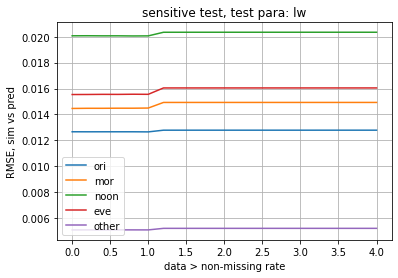

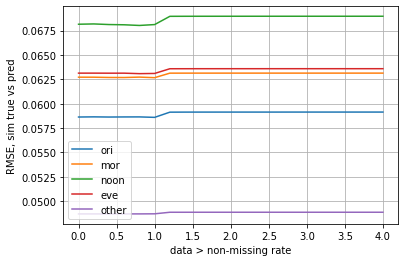

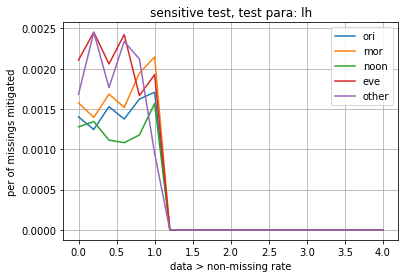

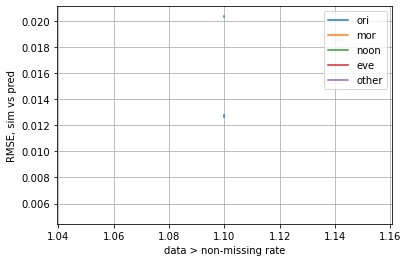

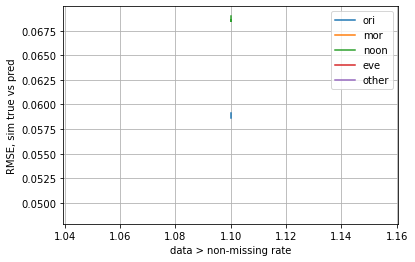

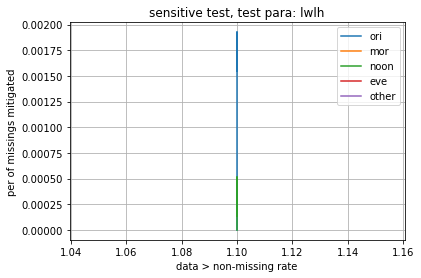

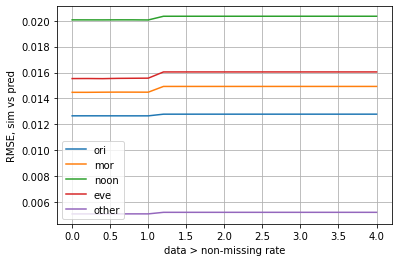

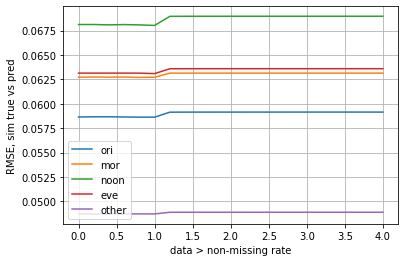

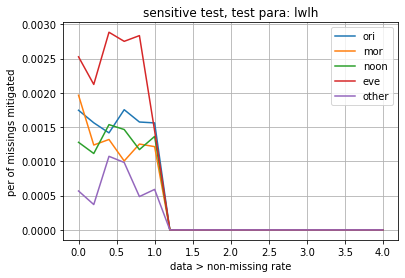

In [19]:
idx = plot_paras_sensitive(test_lw_bmf, list(np.array(lw_bmf)[:, 1]), 'lw', 1)
idx = plot_paras_sensitive(test_lh_bmf, list(np.array(lw_bmf)[:, 2]), 'lh', idx)
idx = plot_paras_sensitive(test_lwlh_bmf, list(np.array(lw_bmf)[:, 1]), 'lwlh', idx)

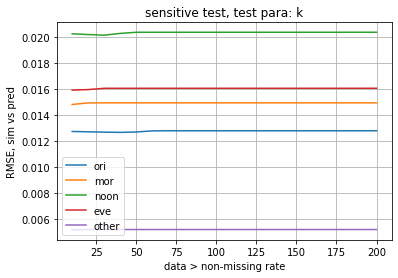

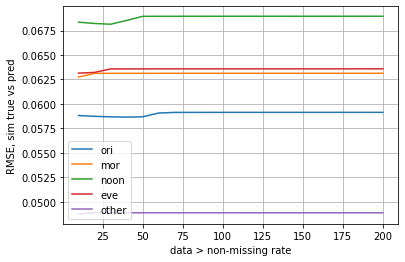

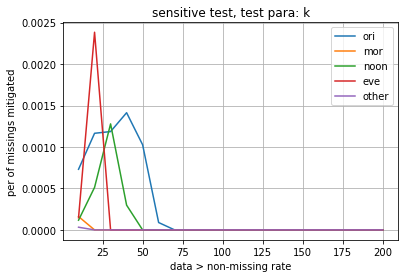

In [241]:
plot_paras_sensitive(test_k_bmf, list(np.array(k_bmf)[:, 0]), 'k')
#k bmf = 30/40

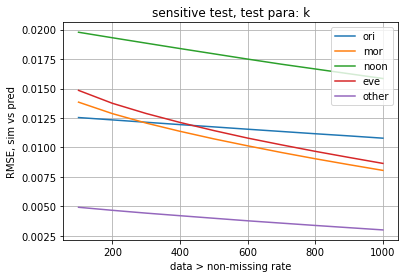

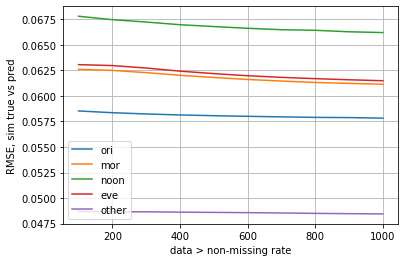

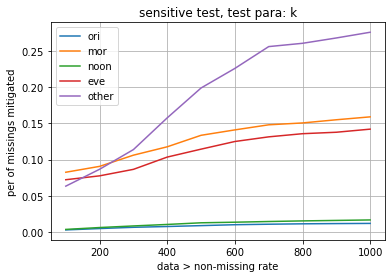

In [242]:
plot_paras_sensitive(test_k_nmf, list(np.array(k_nmf)[:, 0]), 'k')
#k = 700

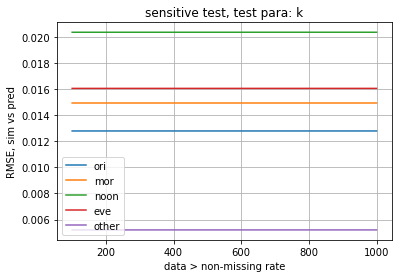

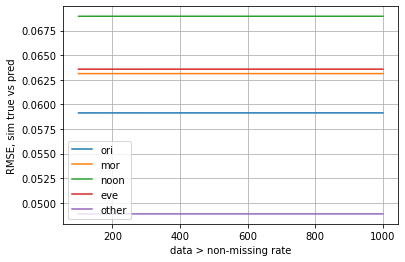

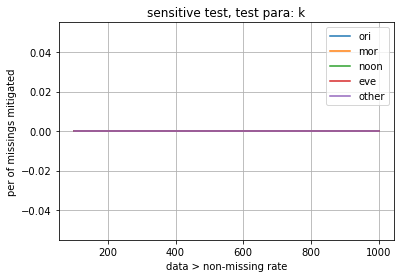

In [244]:
plot_paras_sensitive(test_k_bmf_100, list(np.array(k_bmf)[:, 0]), 'k')

In [16]:
missing_info = check_missings(fcd_dt, 'sim_t', 288, False)
fit_process_dt_mf01(fcd_dt, 'all', 'sim_t', missing_info, 0.05, 100, 'SVD')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100 0.01251388795158972
RMSE with True, data with missing rate>=0.05, k=100 0.05860620104015138
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00261574525469052


[0.01251388795158972,
 0.05860620104015138,
 0.9379050189193012,
 0.00261574525469052]

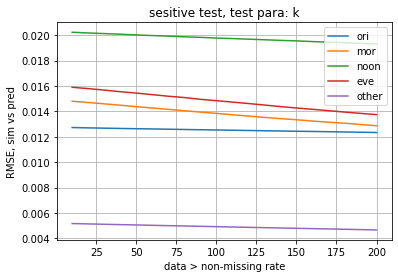

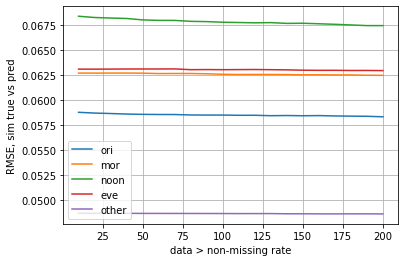

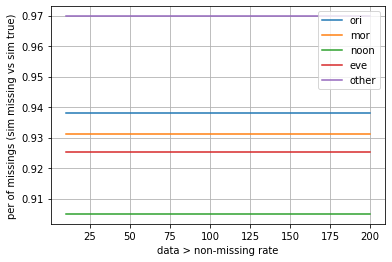

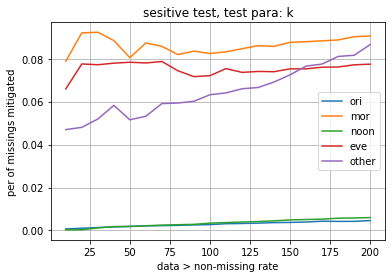

In [228]:
plot_paras_sensitive(test_k_nmf, list(np.array(k_nmf)[:, 0]), 'k')

### SVD

In [ ]:
k_svd = list(np.array(range(1, 10))*10)
k_svd.extend(list(np.array(range(1, 11))*100))

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10 0.01272439912760697
RMSE with True, data with missing rate>=0.05, k=10 0.05876526168109402
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00028631806166207045


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10,mor 0.014796460926171009
RMSE with True, data with missing rate>=0.05, k=10,mor 0.06272964917463858
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07819650961848877
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10,noon 0.020218640791200098
RMSE with True, data with missing rate>=0.05, k=10,noon 0.06830343873972776
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0001263872836075693
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10,eve 0.0158980097764757
RMSE with True, data with missing rate>=0.05, k=10,eve 0.06313101085000375
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06593665834430967
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10,other 0.005172630488776107
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20 0.012698658192684344
RMSE with True, data with missing rate>=0.05, k=20 0.058726264330379405
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0006733776635385731


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20,mor 0.01469379700266771
RMSE with True, data with missing rate>=0.05, k=20,mor 0.06274289846334391
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07875671775005222
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20,noon 0.02016369009197465
RMSE with True, data with missing rate>=0.05, k=20,noon 0.06827940023452661
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0006685704132864174
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20,eve 0.015786154295402165
RMSE with True, data with missing rate>=0.05, k=20,eve 0.0631388981645393
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06637407356439341
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20,other 0.0051427647103015044
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30 0.012674583068238016
RMSE with True, data with missing rate>=0.05, k=30 0.05870696031131813
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.000874271612153318


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30,mor 0.014592827369991464
RMSE with True, data with missing rate>=0.05, k=30,mor 0.06274949293861547
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07912702482006874
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30,noon 0.020111376766227915
RMSE with True, data with missing rate>=0.05, k=30,noon 0.06826261092305241
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0009872861719489835
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30,eve 0.015675180196683233
RMSE with True, data with missing rate>=0.05, k=30,eve 0.06314988481202291
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06700316511687342
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30,other 0.0051152560817824
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40 0.01265061176063572
RMSE with True, data with missing rate>=0.05, k=40 0.05868526119031616
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0012030071644319915


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40,mor 0.014492442293173216
RMSE with True, data with missing rate>=0.05, k=40,mor 0.06275326195805277
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0796872329516322
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40,noon 0.02005967031639653
RMSE with True, data with missing rate>=0.05, k=40,noon 0.06825191197756075
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0015148157035284032
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40,eve 0.01555946284162002
RMSE with True, data with missing rate>=0.05, k=40,eve 0.06316269414314869
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06805984233392966
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40,other 0.005088505672072714
RMSE wit

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50 0.012627853191760718
RMSE with True, data with missing rate>=0.05, k=50 0.058676776572598066
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0014321794401244718


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50,mor 0.014388795113943583
RMSE with True, data with missing rate>=0.05, k=50,mor 0.06276105169096946
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08003380238895536
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50,noon 0.020007943918278846
RMSE with True, data with missing rate>=0.05, k=50,noon 0.06823162271833283
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0018207095638539696
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50,eve 0.015455624756902459
RMSE with True, data with missing rate>=0.05, k=50,eve 0.0631745564837398
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0681728822222659
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50,other 0.005062345578752747
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60 0.012604805248848636
RMSE with True, data with missing rate>=0.05, k=60 0.05866072092628654
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001701412679177077


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60,mor 0.014291502639169177
RMSE with True, data with missing rate>=0.05, k=60,mor 0.06272841564948482
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08000056970318464
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60,noon 0.01995223533453689
RMSE with True, data with missing rate>=0.05, k=60,noon 0.06816544639307262
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.002285961303510819
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60,eve 0.015344003111576054
RMSE with True, data with missing rate>=0.05, k=60,eve 0.06318338116049546
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06904771266243341
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60,other 0.005036475241885138
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70 0.012581860175669566
RMSE with True, data with missing rate>=0.05, k=70 0.058646601837011016
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.002014830804288644


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70,mor 0.014189250306205638
RMSE with True, data with missing rate>=0.05, k=70,mor 0.06273211244381094
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08022370345050228
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70,noon 0.019899321510746155
RMSE with True, data with missing rate>=0.05, k=70,noon 0.06812190634764952
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0025405675704883862
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70,eve 0.015233333133852578
RMSE with True, data with missing rate>=0.05, k=70,eve 0.06318932843731316
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06945072443824091
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70,other 0.005011124162658304
RMSE 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80 0.012558935756823224
RMSE with True, data with missing rate>=0.05, k=80 0.05863133885470938
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0022133682256469107


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80,mor 0.014089219938945187
RMSE with True, data with missing rate>=0.05, k=80,mor 0.06273045171642225
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08078865910860442
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80,noon 0.01984629874610174
RMSE with True, data with missing rate>=0.05, k=80,noon 0.06807434702826709
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0029014124236868086
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80,eve 0.015126738014505805
RMSE with True, data with missing rate>=0.05, k=80,eve 0.06315547210640592
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07046808343326715
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80,other 0.004986140455373994
RMSE w

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90 0.012536269503124772
RMSE with True, data with missing rate>=0.05, k=90 0.058617265454400554
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0023524033337791097


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90,mor 0.01398708784770039
RMSE with True, data with missing rate>=0.05, k=90,mor 0.06271650009446206
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08062724320628953
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90,noon 0.019795741559303377
RMSE with True, data with missing rate>=0.05, k=90,noon 0.06804721157096418
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.003143196792327376
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90,eve 0.015009754490732413
RMSE with True, data with missing rate>=0.05, k=90,eve 0.06315965672421316
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07054671987732715
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90,other 0.00496120938731839
RMSE wit

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100 0.01251388795158972
RMSE with True, data with missing rate>=0.05, k=100 0.05860620104015138
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00261574525469052


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100,mor 0.013887873742357153
RMSE with True, data with missing rate>=0.05, k=100,mor 0.06269813726327378
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0808456294270685
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100,noon 0.019744122128450194
RMSE with True, data with missing rate>=0.05, k=100,noon 0.06801358356576716
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0034564174517026564
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100,eve 0.014896396041398913
RMSE with True, data with missing rate>=0.05, k=100,eve 0.06315093491615612
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07057620854384965
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100,other 0.004936644571128517

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200 0.012295233239953107
RMSE with True, data with missing rate>=0.05, k=200 0.05852316321401374
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0043525058427147665


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200,mor 0.012928385330996146
RMSE with True, data with missing rate>=0.05, k=200,mor 0.06253590969670259
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0835896997664217
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200,noon 0.01925256351050141
RMSE with True, data with missing rate>=0.05, k=200,noon 0.06777587014656178
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.005940202329555758
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200,eve 0.013806806811942346
RMSE with True, data with missing rate>=0.05, k=200,eve 0.06297986458322204
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07424263274814713
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200,other 0.004698014914839834
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300 0.012079116093050965
RMSE with True, data with missing rate>=0.05, k=300 0.05842992686924735
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.005719880783286095


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300,mor 0.012114073920502316
RMSE with True, data with missing rate>=0.05, k=300,mor 0.062277700421009045
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08891642454281319
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300,noon 0.01876885238616999
RMSE with True, data with missing rate>=0.05, k=300,noon 0.06752064342639835
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.008330570519525004
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300,eve 0.012913025299450664
RMSE with True, data with missing rate>=0.05, k=300,eve 0.0626969740143843
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07844476772760335
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300,other 0.004471470021344645


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400 0.011865348400385759
RMSE with True, data with missing rate>=0.05, k=400 0.05834322373501625
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007020683828861921


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400,mor 0.01138792211630343
RMSE with True, data with missing rate>=0.05, k=400,mor 0.06202561755859306
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09027896465941244
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400,noon 0.01828606754156259
RMSE with True, data with missing rate>=0.05, k=400,noon 0.06723741099785181
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.010510293236814967
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400,eve 0.01212196635531647
RMSE with True, data with missing rate>=0.05, k=400,eve 0.06241564210451962
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08169343582283209
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400,other 0.0042535398427526495
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500 0.01165150888374347
RMSE with True, data with missing rate>=0.05, k=500 0.05825322340569762
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008210730093383283


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500,mor 0.010716699978183402
RMSE with True, data with missing rate>=0.05, k=500,mor 0.06179899689434544
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09063977667635162
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500,noon 0.017809192545537977
RMSE with True, data with missing rate>=0.05, k=500,noon 0.06697318018203259
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.012320012602094366
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500,eve 0.01139712627665344
RMSE with True, data with missing rate>=0.05, k=500,eve 0.062180033860415
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08493718914030708
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500,other 0.004041241595305185
RM

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600 0.011436553983409535
RMSE with True, data with missing rate>=0.05, k=600 0.05816755306844206
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.009325367485697353


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600,mor 0.010086315255427762
RMSE with True, data with missing rate>=0.05, k=600,mor 0.06161634816085759
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0917127176740918
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600,noon 0.01734182562260698
RMSE with True, data with missing rate>=0.05, k=600,noon 0.06676854193394091
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.01407294927473848
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600,eve 0.010733881926918046
RMSE with True, data with missing rate>=0.05, k=600,eve 0.06199563141172471
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08568915013663082
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600,other 0.0038265136765927195
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700 0.01122005487430628
RMSE with True, data with missing rate>=0.05, k=700 0.05808480134283356
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010204941284177746


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700,mor 0.009492959888792313
RMSE with True, data with missing rate>=0.05, k=700,mor 0.0614768906018187
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09177918304563322
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700,noon 0.016883424317773177
RMSE with True, data with missing rate>=0.05, k=700,noon 0.06660062705347512
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.015212266526969031
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700,eve 0.010103354889723746
RMSE with True, data with missing rate>=0.05, k=700,eve 0.06183514411745591
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08578253091395208
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700,other 0.003624511403804118


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800 0.011003871761808814
RMSE with True, data with missing rate>=0.05, k=800 0.05800854164859684
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010854753675151539


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800,mor 0.008925229928203361
RMSE with True, data with missing rate>=0.05, k=800,mor 0.06136394402000741
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09142786608177139
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800,noon 0.01643342018715075
RMSE with True, data with missing rate>=0.05, k=800,noon 0.06645223609896674
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.015944946431940447
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800,eve 0.00951654705488561
RMSE with True, data with missing rate>=0.05, k=800,eve 0.0617116862719472
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08666227613187331
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800,other 0.0034203443814308956
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900 0.010788153534932956
RMSE with True, data with missing rate>=0.05, k=900 0.05794019146939301
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01133607436728716


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900,mor 0.008388268965534596
RMSE with True, data with missing rate>=0.05, k=900,mor 0.061272718335423956
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09210201485026301
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900,noon 0.015991240308932998
RMSE with True, data with missing rate>=0.05, k=900,noon 0.06631595695267961
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.016531090355917582
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900,eve 0.008951788095050662
RMSE with True, data with missing rate>=0.05, k=900,eve 0.06160162713490394
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08638704857766331
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900,other 0.00322313615868457

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000 0.010573342123859655
RMSE with True, data with missing rate>=0.05, k=1000 0.05787636985586655
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01166893384226467


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000,mor 0.007875288142622304
RMSE with True, data with missing rate>=0.05, k=1000,mor 0.061192064891678825
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0930847528437684
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000,noon 0.015557984700365082
RMSE with True, data with missing rate>=0.05, k=1000,noon 0.06620462161912881
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.016976193398187716
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000,eve 0.008407052763282878
RMSE with True, data with missing rate>=0.05, k=1000,eve 0.06150388284929176
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08647059979947706
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000,other 0.00302790515

4

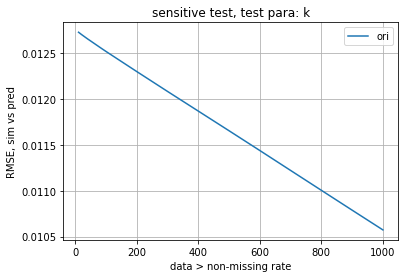

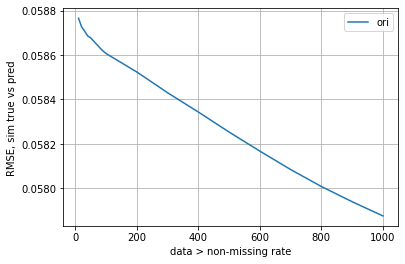

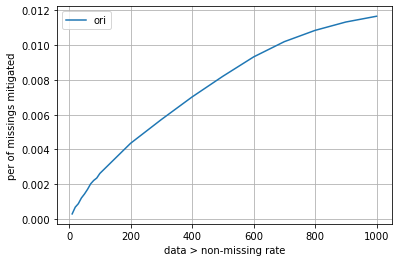

In [49]:
test_k_svd = fit_model_get_para(fcd_dt, 'sim_t', k_svd, 
                       0.05, 288, 
                       result_para_dict, 'SVD',
                       True)



4

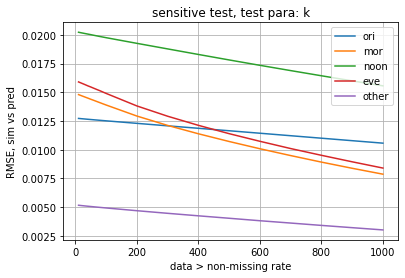

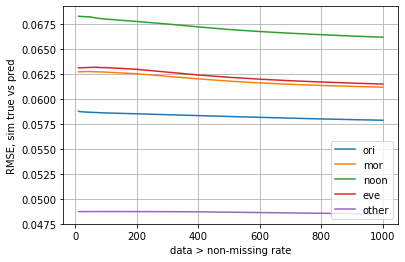

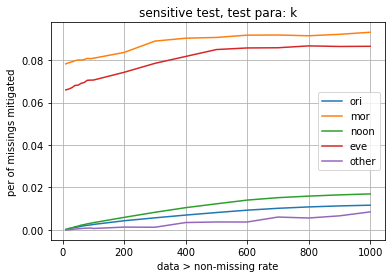

In [66]:
plot_paras_sensitive(test_k_svd, k_svd, 'k', 1)

In [134]:
missing_info = check_missings(fcd_dt, 'sim_t', 288, False)
ypop_simt = []
for i in x_val_simt:
    ypop_simt.append(len(np.where(missing_info>=i)[0]))
    
missing_info = check_missings(fcd_dt, 'sim_t2', 288, False)
ypop_simt2 =[]    
for i in x_val_simt2:
    ypop_simt2.append(len(np.where(missing_info>=i)[0]))

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25820\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


In [ ]:
x_val_simt = 0.01*np.array(range(1, 10))
#result_para_dict_simt = fit_model_get_para(fcd_dt, 'sim_t', 10, x_val_simt, 288, result_para_dict, 'BMF')
#result_para_dict_simt_100 = fit_model_get_para(fcd_dt, 'sim_t', 100, x_val_simt, 288, result_para_dict, 'BMF')
k_val = 100
result_para_dict_simt_100_bmf = copy.deepcopy(result_para_dict)
for i in x_val_simt:
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, i, k_val, 'BMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, i, 12, k_val, 'BMF')
    result_para_dict_simt_100_bmf = add_result2dict(result_para, result_para_time, result_para_dict_simt_100_bmf)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100)  

In [47]:
missing_info = check_missings(fcd_dt, 'sim_t', 288, False)
k_val = 10
result_para_dict_simt = copy.deepcopy(result_para_dict)
for i in 0.01*np.array(range(1, 10)):
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt = add_result2dict(result_para, result_para_time, result_para_dict_simt)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    

k_val = 100
result_para_dict_simt_100 = copy.deepcopy(result_para_dict)
for i in 0.01*np.array(range(1, 10)):
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt_100 = add_result2dict(result_para, result_para_time, result_para_dict_simt_100)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100)   


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.01, k=10 0.011861481770917106
RMSE with True, data with missing rate>=0.01, k=10 0.057591293538391555
% of missings (sim missing vs sim true) 0.9473901679100936
% of missings mitigated 0.00036099353686940016


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=10,mor 0.013859302799877782
RMSE with True, data with missing rate>=0.01, k=10,mor 0.061409481654068586
% of missings (sim missing vs sim true) 0.9419291151736052
% of missings mitigated 0.1439850457495264
RMSE, data with missing rate>=0.01, k=10,noon 0.018599294114145782
RMSE with True, data with missing rate>=0.01, k=10,noon 0.06663463440471604
% of missings (sim missing vs sim true) 0.9194973019534142
% of missings mitigated 0.0006290470711084486


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=10,eve 0.014686795660785661
RMSE with True, data with missing rate>=0.01, k=10,eve 0.06131457613238765
% of missings (sim missing vs sim true) 0.9361450782260623
% of missings mitigated 0.12332745836244746
RMSE, data with missing rate>=0.01, k=10,other 0.0050391726058245725
RMSE with True, data with missing rate>=0.01, k=10,other 0.04817776021159453
% of missings (sim missing vs sim true) 0.9743975329455968
% of missings mitigated 0.0866651885793117


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.02, k=10 0.011877536296354201
RMSE with True, data with missing rate>=0.02, k=10 0.05761897340150735
% of missings (sim missing vs sim true) 0.9472590758840116
% of missings mitigated 0.00036045797961888244


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=10,mor 0.01388070242604708
RMSE with True, data with missing rate>=0.02, k=10,mor 0.06145347607074007
% of missings (sim missing vs sim true) 0.941791457094955
% of missings mitigated 0.14271409136655355
RMSE, data with missing rate>=0.02, k=10,noon 0.018625756960884653
RMSE with True, data with missing rate>=0.02, k=10,noon 0.06666683229718667
% of missings (sim missing vs sim true) 0.919286908436214
% of missings mitigated 0.00034875836194317667


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=10,eve 0.014703299983863547
RMSE with True, data with missing rate>=0.02, k=10,eve 0.06126603262672687
% of missings (sim missing vs sim true) 0.9359861845972957
% of missings mitigated 0.12121997241610334
RMSE, data with missing rate>=0.02, k=10,other 0.00504378203699889
RMSE with True, data with missing rate>=0.02, k=10,other 0.04820066095892989
% of missings (sim missing vs sim true) 0.974339353127232
% of missings mitigated 0.08601381107795056


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.03, k=10 0.012001591648297517
RMSE with True, data with missing rate>=0.03, k=10 0.057746840221452135
% of missings (sim missing vs sim true) 0.946319543721706
% of missings mitigated 0.00036554165076642446


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.03, k=10,mor 0.014012703450132393
RMSE with True, data with missing rate>=0.03, k=10,mor 0.061559866704815516
% of missings (sim missing vs sim true) 0.9407736676991502
% of missings mitigated 0.12791749879303205
RMSE, data with missing rate>=0.03, k=10,noon 0.018830281157937768
RMSE with True, data with missing rate>=0.03, k=10,noon 0.06681604334763545
% of missings (sim missing vs sim true) 0.9177500297831784
% of missings mitigated 0.00016226193132263758


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=10,eve 0.014880110096300274
RMSE with True, data with missing rate>=0.03, k=10,eve 0.06145329045786582
% of missings (sim missing vs sim true) 0.9348080261411212
% of missings mitigated 0.11237004448595374
RMSE, data with missing rate>=0.03, k=10,other 0.005085500808195335
RMSE with True, data with missing rate>=0.03, k=10,other 0.048298424827468475
% of missings (sim missing vs sim true) 0.9739660560376656
% of missings mitigated 0.07757608932990441


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.04, k=10 0.012333412474008829
RMSE with True, data with missing rate>=0.04, k=10 0.05806906215263047
% of missings (sim missing vs sim true) 0.9432730700318003
% of missings mitigated 0.0003199875464306254


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,mor 0.014389104925496029
RMSE with True, data with missing rate>=0.04, k=10,mor 0.0619822568105651
% of missings (sim missing vs sim true) 0.9372626845127913
% of missings mitigated 0.11620325679289772


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,noon 0.01943439020966053
RMSE with True, data with missing rate>=0.04, k=10,noon 0.06729071592148717
% of missings (sim missing vs sim true) 0.9129778940623665
% of missings mitigated 9.503896597605019e-05


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,eve 0.015310394182962388
RMSE with True, data with missing rate>=0.04, k=10,eve 0.06191236456627443
% of missings (sim missing vs sim true) 0.9312137670104351
% of missings mitigated 0.09430005635722617


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,other 0.005156913382794126
RMSE with True, data with missing rate>=0.04, k=10,other 0.048426473670651636
% of missings (sim missing vs sim true) 0.9725853541433519
% of missings mitigated 0.09505327673228782


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, k=10 0.012729749571966173
RMSE with True, data with missing rate>=0.05, k=10 0.05880726664682562
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.000742306085790553


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, k=10,mor 0.01479752473155533
RMSE with True, data with missing rate>=0.05, k=10,mor 0.06272493392831388
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07883742570120968


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=10,noon 0.020230021374531098
RMSE with True, data with missing rate>=0.05, k=10,noon 0.06840617573166134
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00025826966650242426
RMSE, data with missing rate>=0.05, k=10,eve 0.015899886455230366
RMSE with True, data with missing rate>=0.05, k=10,eve 0.06312067571611471
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06590716967778718
RMSE, data with missing rate>=0.05, k=10,other 0.005172363428812574
RMSE with True, data with missing rate>=0.05, k=10,other 0.04871799070733817
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.0469656941988261


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=10 0.012770963765824813
RMSE with True, data with missing rate>=0.06, k=10 0.059887635174768555
% of missings (sim missing vs sim true) 0.931887830937642
% of missings mitigated 0.0005793668013440371


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.06, k=10,mor 0.014895481608422963
RMSE with True, data with missing rate>=0.06, k=10,mor 0.06409554392871193
% of missings (sim missing vs sim true) 0.9237925366348407
% of missings mitigated 0.05994926932687211
RMSE, data with missing rate>=0.06, k=10,noon 0.0205370567774557
RMSE with True, data with missing rate>=0.06, k=10,noon 0.06980675343678953
% of missings (sim missing vs sim true) 0.8961185867170286
% of missings mitigated 0.0003292976082017058
RMSE, data with missing rate>=0.06, k=10,eve 0.016107691438151106
RMSE with True, data with missing rate>=0.06, k=10,eve 0.06497919622359812
% of missings (sim missing vs sim true) 0.9171275686856424
% of missings mitigated 0.051363012355363794


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=10,other 0.004933129317534506
RMSE with True, data with missing rate>=0.06, k=10,other 0.04922779459510219
% of missings (sim missing vs sim true) 0.9669447501021027
% of missings mitigated 0.03289661295095639


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.07, k=10 0.011992614263893142
RMSE with True, data with missing rate>=0.07, k=10 0.060584920113530394
% of missings (sim missing vs sim true) 0.9254866740358634
% of missings mitigated 0.0018053885179502066


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=10,mor 0.014056608880928344
RMSE with True, data with missing rate>=0.07, k=10,mor 0.06534559487715583
% of missings (sim missing vs sim true) 0.9157455170719725
% of missings mitigated 0.04611498569384836
RMSE, data with missing rate>=0.07, k=10,noon 0.019494547469498524
RMSE with True, data with missing rate>=0.07, k=10,noon 0.0716626726709641
% of missings (sim missing vs sim true) 0.8877118644067796
% of missings mitigated 0.0009511950468679741


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=10,eve 0.015438681984233605
RMSE with True, data with missing rate>=0.07, k=10,eve 0.06717567682473358
% of missings (sim missing vs sim true) 0.909801031687546
% of missings mitigated 0.038948415912614845
RMSE, data with missing rate>=0.07, k=10,other 0.004321308784059673
RMSE with True, data with missing rate>=0.07, k=10,other 0.04847803607771668
% of missings (sim missing vs sim true) 0.9628921356663033
% of missings mitigated 0.029221272074077823


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.08, k=10 0.009650150431630694
RMSE with True, data with missing rate>=0.08, k=10 0.05677436238546328
% of missings (sim missing vs sim true) 0.9182703625235404
% of missings mitigated 0.007714738916571868


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.08, k=10,mor 0.010688582884434163
RMSE with True, data with missing rate>=0.08, k=10,mor 0.060358234150394596
% of missings (sim missing vs sim true) 0.9111935028248588
% of missings mitigated 0.05916166117677453
RMSE, data with missing rate>=0.08, k=10,noon 0.015948706624935666
RMSE with True, data with missing rate>=0.08, k=10,noon 0.06970939212550449
% of missings (sim missing vs sim true) 0.8773172669491526
% of missings mitigated 0.006716474228360123
RMSE, data with missing rate>=0.08, k=10,eve 0.012885753461279553
RMSE with True, data with missing rate>=0.08, k=10,eve 0.06537460640518673
% of missings (sim missing vs sim true) 0.8980024213075061
% of missings mitigated 0.023255813953488372
RMSE, data with missing rate>=0.08, k=10,other 0.003116114595040795
RMSE with True, data with missing rate>=0.08, k=10,other 0.042936930492251904
% of missings (sim missing vs sim true) 0.9587302143157305
% of missings mitigated 0.13260889416491645


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=10 0.007690334758278416
RMSE with True, data with missing rate>=0.09, k=10 0.051016427193137544
% of missings (sim missing vs sim true) 0.911108193277311
% of missings mitigated 0.02562008614753967


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.09, k=10,mor 0.007828231347560718
RMSE with True, data with missing rate>=0.09, k=10,mor 0.053418281987026695
% of missings (sim missing vs sim true) 0.9082633053221288
% of missings mitigated 0.14006682086867128


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=10,noon 0.012727082029697806
RMSE with True, data with missing rate>=0.09, k=10,noon 0.06397895272199196
% of missings (sim missing vs sim true) 0.8701855742296919
% of missings mitigated 0.011920329946685444
RMSE, data with missing rate>=0.09, k=10,eve 0.010502100208879794
RMSE with True, data with missing rate>=0.09, k=10,eve 0.059767333535504445
% of missings (sim missing vs sim true) 0.888235294117647
% of missings mitigated 0.035139883768076766


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=10,other 0.00238980846981346
RMSE with True, data with missing rate>=0.09, k=10,other 0.0372070395469539
% of missings (sim missing vs sim true) 0.951038266546288
% of missings mitigated 0.27643493500803273


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100 0.011718845062469205
RMSE with True, data with missing rate>=0.01, k=100 0.05742133942388645
% of missings (sim missing vs sim true) 0.9473901679100936
% of missings mitigated 0.0018350243881973586


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,mor 0.012943196577740271
RMSE with True, data with missing rate>=0.01, k=100,mor 0.06139424374519242
% of missings (sim missing vs sim true) 0.9419291151736052
% of missings mitigated 0.14339554194042484


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,noon 0.018247480696655702
RMSE with True, data with missing rate>=0.01, k=100,noon 0.06634585496873031
% of missings (sim missing vs sim true) 0.9194973019534142
% of missings mitigated 0.0028249052316393257


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,eve 0.013676315064261806
RMSE with True, data with missing rate>=0.01, k=100,eve 0.061271522966663716
% of missings (sim missing vs sim true) 0.9361450782260623
% of missings mitigated 0.1243234223617383


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,other 0.004810967024234538
RMSE with True, data with missing rate>=0.01, k=100,other 0.048168615439306096
% of missings (sim missing vs sim true) 0.9743975329455968
% of missings mitigated 0.11693192538267247


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=100 0.011733566569767748
RMSE with True, data with missing rate>=0.02, k=100 0.05744962395342661
% of missings (sim missing vs sim true) 0.9472590758840116
% of missings mitigated 0.0018887118199733947


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.02, k=100,mor 0.012964622958688716
RMSE with True, data with missing rate>=0.02, k=100,mor 0.06143577672558209
% of missings (sim missing vs sim true) 0.941791457094955
% of missings mitigated 0.1421249070707173


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=100,noon 0.01827392259203088
RMSE with True, data with missing rate>=0.02, k=100,noon 0.06637771509463157
% of missings (sim missing vs sim true) 0.919286908436214
% of missings mitigated 0.002607430204611382
RMSE, data with missing rate>=0.02, k=100,eve 0.013700908948636592
RMSE with True, data with missing rate>=0.02, k=100,eve 0.06128546629518019
% of missings (sim missing vs sim true) 0.9359861845972957
% of missings mitigated 0.12117024812421652


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=100,other 0.004815628678019117
RMSE with True, data with missing rate>=0.02, k=100,other 0.04819144758270118
% of missings (sim missing vs sim true) 0.974339353127232
% of missings mitigated 0.11566341460576761


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100 0.011857189689905543
RMSE with True, data with missing rate>=0.03, k=100 0.057585196976337294
% of missings (sim missing vs sim true) 0.946319543721706
% of missings mitigated 0.0019217983468993545


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100,mor 0.013091975124042513
RMSE with True, data with missing rate>=0.03, k=100,mor 0.061566936034890274
% of missings (sim missing vs sim true) 0.9407736676991502
% of missings mitigated 0.13432827945727333


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100,noon 0.018472161225652914
RMSE with True, data with missing rate>=0.03, k=100,noon 0.06652067168402429
% of missings (sim missing vs sim true) 0.9177500297831784
% of missings mitigated 0.002539399225199278
RMSE, data with missing rate>=0.03, k=100,eve 0.013879608477173365
RMSE with True, data with missing rate>=0.03, k=100,eve 0.06147088566450972
% of missings (sim missing vs sim true) 0.9348080261411212
% of missings mitigated 0.10448600836193925


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100,other 0.0048549057757592455
RMSE with True, data with missing rate>=0.03, k=100,other 0.04828926300943124
% of missings (sim missing vs sim true) 0.9739660560376656
% of missings mitigated 0.1072021022368868


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100 0.012175408280241933
RMSE with True, data with missing rate>=0.04, k=100 0.057885257080326914
% of missings (sim missing vs sim true) 0.9432730700318003
% of missings mitigated 0.0021683676979254666


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.04, k=100,mor 0.013454469391263654
RMSE with True, data with missing rate>=0.04, k=100,mor 0.06195752304479292
% of missings (sim missing vs sim true) 0.9372626845127913
% of missings mitigated 0.11162349068696492


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100,noon 0.019053665125387184
RMSE with True, data with missing rate>=0.04, k=100,noon 0.06694953571832818
% of missings (sim missing vs sim true) 0.9129778940623665
% of missings mitigated 0.0026903338060912667


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100,eve 0.014277790834191059
RMSE with True, data with missing rate>=0.04, k=100,eve 0.06193061209542259
% of missings (sim missing vs sim true) 0.9312137670104351
% of missings mitigated 0.09655106882134759


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100,other 0.0049219933587330116
RMSE with True, data with missing rate>=0.04, k=100,other 0.04841361978202191
% of missings (sim missing vs sim true) 0.9725853541433519
% of missings mitigated 0.07768275706862726


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=100 0.012537902574912135
RMSE with True, data with missing rate>=0.05, k=100 0.05853086733659989
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.002722967244860267


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, k=100,mor 0.013843213028521144
RMSE with True, data with missing rate>=0.05, k=100,mor 0.06260554479826538
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08240756565829203


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=100,noon 0.01977246559190874
RMSE with True, data with missing rate>=0.05, k=100,noon 0.06780792098408596
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0034124566574043717
RMSE, data with missing rate>=0.05, k=100,eve 0.014843101059781693
RMSE with True, data with missing rate>=0.05, k=100,eve 0.06306572448088565
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07208013053649714


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=100,other 0.004927446588611469
RMSE with True, data with missing rate>=0.05, k=100,other 0.04869171920371929
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.06319910817936228


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100 0.012457821394958409
RMSE with True, data with missing rate>=0.06, k=100 0.0595330527865058
% of missings (sim missing vs sim true) 0.931887830937642
% of missings mitigated 0.005392567920202192


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100,mor 0.013861891523689846
RMSE with True, data with missing rate>=0.06, k=100,mor 0.06382172910693823
% of missings (sim missing vs sim true) 0.9237925366348407
% of missings mitigated 0.0730010600439161


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100,noon 0.019858375829254395
RMSE with True, data with missing rate>=0.06, k=100,noon 0.06907508500548713
% of missings (sim missing vs sim true) 0.8961185867170286
% of missings mitigated 0.006904273185295764
RMSE, data with missing rate>=0.06, k=100,eve 0.01493134470726502
RMSE with True, data with missing rate>=0.06, k=100,eve 0.06472994054673181
% of missings (sim missing vs sim true) 0.9171275686856424
% of missings mitigated 0.06187487742694646


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100,other 0.004648387867537759
RMSE with True, data with missing rate>=0.06, k=100,other 0.04916312707495369
% of missings (sim missing vs sim true) 0.9669447501021027
% of missings mitigated 0.07726991471846331


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=100 0.011329832116100173
RMSE with True, data with missing rate>=0.07, k=100 0.060100909144346355
% of missings (sim missing vs sim true) 0.9254866740358634
% of missings mitigated 0.013320615435657114


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.07, k=100,mor 0.012410904154695694
RMSE with True, data with missing rate>=0.07, k=100,mor 0.0645911127635084
% of missings (sim missing vs sim true) 0.9157455170719725
% of missings mitigated 0.078616773962804


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=100,noon 0.018134310841257557
RMSE with True, data with missing rate>=0.07, k=100,noon 0.07069427111459081
% of missings (sim missing vs sim true) 0.8877118644067796
% of missings mitigated 0.012988136003597247
RMSE, data with missing rate>=0.07, k=100,eve 0.013577201540000822
RMSE with True, data with missing rate>=0.07, k=100,eve 0.06630736467714958
% of missings (sim missing vs sim true) 0.909801031687546
% of missings mitigated 0.061951817824165145


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=100,other 0.003874158098419388
RMSE with True, data with missing rate>=0.07, k=100,other 0.0482881463237679
% of missings (sim missing vs sim true) 0.9628921356663033
% of missings mitigated 0.1945744573192329


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.08, k=100 0.008197304995008576
RMSE with True, data with missing rate>=0.08, k=100 0.05592133829779657
% of missings (sim missing vs sim true) 0.9182703625235404
% of missings mitigated 0.04322817361767581


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.08, k=100,mor 0.007526928160644816
RMSE with True, data with missing rate>=0.08, k=100,mor 0.05876000001163887
% of missings (sim missing vs sim true) 0.9111935028248588
% of missings mitigated 0.14163921720596784


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.08, k=100,noon 0.012925001583698473
RMSE with True, data with missing rate>=0.08, k=100,noon 0.06780630419430676
% of missings (sim missing vs sim true) 0.8773172669491526
% of missings mitigated 0.03134354639901391
RMSE, data with missing rate>=0.08, k=100,eve 0.008987527177881508
RMSE with True, data with missing rate>=0.08, k=100,eve 0.0633000693530829
% of missings (sim missing vs sim true) 0.8980024213075061
% of missings mitigated 0.09908998988877654
RMSE, data with missing rate>=0.08, k=100,other 0.0021772026684106346
RMSE with True, data with missing rate>=0.08, k=100,other 0.04252596224841436
% of missings (sim missing vs sim true) 0.9587302143157305
% of missings mitigated 0.36794813259063097


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=100 0.0052040000840710594
RMSE with True, data with missing rate>=0.09, k=100 0.04946726894450069
% of missings (sim missing vs sim true) 0.911108193277311
% of missings mitigated 0.15333621559302493


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=100,mor 0.003561714003103202
RMSE with True, data with missing rate>=0.09, k=100,mor 0.051049659553870363
% of missings (sim missing vs sim true) 0.9082633053221288
% of missings mitigated 0.34425597532767926


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=100,noon 0.007725539465128526
RMSE with True, data with missing rate>=0.09, k=100,noon 0.06101082775451818
% of missings (sim missing vs sim true) 0.8701855742296919
% of missings mitigated 0.08927673272306609
RMSE, data with missing rate>=0.09, k=100,eve 0.004564356091072934
RMSE with True, data with missing rate>=0.09, k=100,eve 0.05647657692901584
% of missings (sim missing vs sim true) 0.888235294117647
% of missings mitigated 0.19164751993512638
RMSE, data with missing rate>=0.09, k=100,other 0.001107215084676042
RMSE with True, data with missing rate>=0.09, k=100,other 0.03666044604774989
% of missings (sim missing vs sim true) 0.951038266546288
% of missings mitigated 0.5815320578355484


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


0.13194444444444445
0.006944444444444444
0.6631944444444444
0.4513888888888889


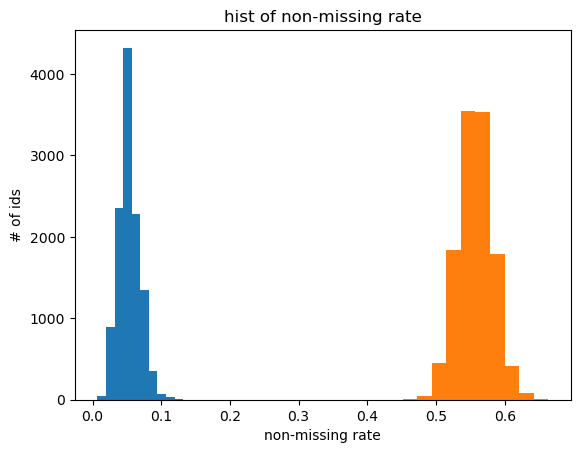

In [69]:
missing_info = check_missings(fcd_dt, 'sim_t', 288)
missing_info_simt2 = check_missings(fcd_dt, 'sim_t2', 288)

In [37]:
x_val_simt2 = (0.02*np.array(range(22, 32)))+0.01

In [39]:
missing_info = check_missings(fcd_dt, 'sim_t2', 288, False)
k_val = 10
result_para_dict_simt2 = copy.deepcopy(result_para_dict)
for i in x_val:
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t2', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t2', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt2 = add_result2dict(result_para, result_para_time, result_para_dict_simt2)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))'''
    
k_val = 100
result_para_dict_simt2_100 = copy.deepcopy(result_para_dict)
for i in x_val:
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t2', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t2', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt2_100 = add_result2dict(result_para, result_para_time, result_para_dict_simt2_100)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.45, k=10 0.04111722559182743
RMSE with True, data with missing rate>=0.45, k=10 0.054303558364962645
% of missings (sim missing vs sim true) 0.44363132348336043
% of missings mitigated 3.0080012834138808e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.45, k=10,mor 0.04603721382201868
RMSE with True, data with missing rate>=0.45, k=10,mor 0.05538060840320619
% of missings (sim missing vs sim true) 0.3595358745883983
% of missings mitigated 7.258186904911154e-05
RMSE, data with missing rate>=0.45, k=10,noon 0.05771167886871295
RMSE with True, data with missing rate>=0.45, k=10,noon 0.06161263580970071
% of missings (sim missing vs sim true) 0.1568745196003074
% of missings mitigated 6.805151499685262e-05
RMSE, data with missing rate>=0.45, k=10,eve 0.04767238939154101
RMSE with True, data with missing rate>=0.45, k=10,eve 0.05491400228645466
% of missings (sim missing vs sim true) 0.2982492100093945
% of missings mitigated 0.0001227224753941437
RMSE, data with missing rate>=0.45, k=10,other 0.023304530100790068
RMSE with True, data with missing rate>=0.45, k=10,other 0.04569884888139243
% of missings (sim missing vs sim true) 0.73821366484353
% of missings mitigated 0.0


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.47000000000000003, k=10 0.04111639877003737
RMSE with True, data with missing rate>=0.47000000000000003, k=10 0.05429885145621064
% of missings (sim missing vs sim true) 0.44359871137690443
% of missings mitigated 3.0092504358397714e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.47000000000000003, k=10,mor 0.04603781584016959
RMSE with True, data with missing rate>=0.47000000000000003, k=10,mor 0.0553781340911575
% of missings (sim missing vs sim true) 0.3594902463334757
% of missings mitigated 7.261588835637237e-05
RMSE, data with missing rate>=0.47000000000000003, k=10,noon 0.05748672921067693
RMSE with True, data with missing rate>=0.47000000000000003, k=10,noon 0.06133045439729243
% of missings (sim missing vs sim true) 0.15684981489392003
% of missings mitigated 0.00013049719431032232
RMSE, data with missing rate>=0.47000000000000003, k=10,eve 0.0476724597686474
RMSE with True, data with missing rate>=0.47000000000000003, k=10,eve 0.05491020452965904
% of missings (sim missing vs sim true) 0.2981924696405688
% of missings mitigated 0.00012278777361208887
RMSE, data with missing rate>=0.47000000000000003, k=10,other 0.02330343885890285
RMSE with True, data with missing rate>=0.47000000000000003, k=10,other 0.0456912550768033

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.49, k=10 0.04113116871445562
RMSE with True, data with missing rate>=0.49, k=10 0.054310325907520884
% of missings (sim missing vs sim true) 0.443381446415141
% of missings mitigated 3.019495878388126e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.49, k=10,mor 0.04605544584762949
RMSE with True, data with missing rate>=0.49, k=10,mor 0.05539026222999334
% of missings (sim missing vs sim true) 0.3592451375203496
% of missings mitigated 7.287712254619415e-05
RMSE, data with missing rate>=0.49, k=10,noon 0.05749544469411315
RMSE with True, data with missing rate>=0.49, k=10,noon 0.06133199060000812
% of missings (sim missing vs sim true) 0.1566302159198012
% of missings mitigated 0.00013106085212347072
RMSE, data with missing rate>=0.49, k=10,eve 0.04769605053224289
RMSE with True, data with missing rate>=0.49, k=10,eve 0.054928982811856535
% of missings (sim missing vs sim true) 0.29792281234317053
% of missings mitigated 0.0001232569414200843
RMSE, data with missing rate>=0.49, k=10,other 0.023264774902154027
RMSE with True, data with missing rate>=0.49, k=10,other 0.04553670199102238
% of missings (sim missing vs sim true) 0.7379936566654227
% of missings mitigated 7.676158236325883e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.51, k=10 0.041184081235263424
RMSE with True, data with missing rate>=0.51, k=10 0.054322687650986606
% of missings (sim missing vs sim true) 0.4422419403405503
% of missings mitigated 2.8141249855861892e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.51, k=10,mor 0.04614880698773168
RMSE with True, data with missing rate>=0.51, k=10,mor 0.05545914647576983
% of missings (sim missing vs sim true) 0.35792755777020135
% of missings mitigated 6.784444625362968e-05
RMSE, data with missing rate>=0.51, k=10,noon 0.05755710878642277
RMSE with True, data with missing rate>=0.51, k=10,noon 0.06137783926326854
% of missings (sim missing vs sim true) 0.1557072660780371
% of missings mitigated 0.0001345115767680962
RMSE, data with missing rate>=0.51, k=10,eve 0.047761284355657144
RMSE with True, data with missing rate>=0.51, k=10,eve 0.05496826688826913
% of missings (sim missing vs sim true) 0.29655439411536977
% of missings mitigated 0.0001263370672955445
RMSE, data with missing rate>=0.51, k=10,other 0.023298016369414136
RMSE with True, data with missing rate>=0.51, k=10,other 0.04549559339073957
% of missings (sim missing vs sim true) 0.7368015322381962
% of missings mitigated 7.844513890182689e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.53, k=10 0.041487874319830295
RMSE with True, data with missing rate>=0.53, k=10 0.054542247587347985
% of missings (sim missing vs sim true) 0.43779281748369225
% of missings mitigated 3.036685496712204e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.53, k=10,mor 0.04649625181919368
RMSE with True, data with missing rate>=0.53, k=10,mor 0.055713138800225104
% of missings (sim missing vs sim true) 0.35272269127560707
% of missings mitigated 7.731440676655688e-05
RMSE, data with missing rate>=0.53, k=10,noon 0.05779052739359679
RMSE with True, data with missing rate>=0.53, k=10,noon 0.06152222921005614
% of missings (sim missing vs sim true) 0.1520264742456967
% of missings mitigated 0.00014798869904480023
RMSE, data with missing rate>=0.53, k=10,eve 0.04839289133593939
RMSE with True, data with missing rate>=0.53, k=10,eve 0.0556061392929522
% of missings (sim missing vs sim true) 0.2918347311435865
% of missings mitigated 6.728052132792527e-05
RMSE, data with missing rate>=0.53, k=10,other 0.023570437312259208
RMSE with True, data with missing rate>=0.53, k=10,other 0.04567812941140119
% of missings (sim missing vs sim true) 0.7320459291881743
% of missings mitigated 7.758373224302328e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.55, k=10 0.0419878677078346
RMSE with True, data with missing rate>=0.55, k=10 0.054838395683896306
% of missings (sim missing vs sim true) 0.42850012053626974
% of missings mitigated 3.289372943432994e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.55, k=10,mor 0.047266541128441836
RMSE with True, data with missing rate>=0.55, k=10,mor 0.05625179770976011
% of missings (sim missing vs sim true) 0.34117207913400527
% of missings mitigated 5.6983953318745444e-05
RMSE, data with missing rate>=0.55, k=10,noon 0.058304903386335726
RMSE with True, data with missing rate>=0.55, k=10,noon 0.061888384758768615
% of missings (sim missing vs sim true) 0.14504741741321392
% of missings mitigated 0.00015078862450616725
RMSE, data with missing rate>=0.55, k=10,eve 0.0489445503801498
RMSE with True, data with missing rate>=0.55, k=10,eve 0.05584569031229092
% of missings (sim missing vs sim true) 0.2818229083346665
% of missings mitigated 9.933727844239147e-05
RMSE, data with missing rate>=0.55, k=10,other 0.023828971609620865
RMSE with True, data with missing rate>=0.55, k=10,other 0.04559143079013039
% of missings (sim missing vs sim true) 0.7217974049771871
% of missings mitigated 9.616324672764486e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.5700000000000001, k=10 0.04224019237296494
RMSE with True, data with missing rate>=0.5700000000000001, k=10 0.05493546506722652
% of missings (sim missing vs sim true) 0.41504928181030465
% of missings mitigated 3.0110883327854826e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.5700000000000001, k=10,mor 0.04774753620161773
RMSE with True, data with missing rate>=0.5700000000000001, k=10,mor 0.05646701033537079
% of missings (sim missing vs sim true) 0.325993134706392
% of missings mitigated 2.555779896235336e-05
RMSE, data with missing rate>=0.5700000000000001, k=10,noon 0.05862421009167481
RMSE with True, data with missing rate>=0.5700000000000001, k=10,noon 0.06202370640033234
% of missings (sim missing vs sim true) 0.13569786042791443
% of missings mitigated 0.00020722048259347946
RMSE, data with missing rate>=0.5700000000000001, k=10,eve 0.050053860923813594
RMSE with True, data with missing rate>=0.5700000000000001, k=10,eve 0.05680285412029061
% of missings (sim missing vs sim true) 0.26764932727740165
% of missings mitigated 0.0004482581967213115
RMSE, data with missing rate>=0.5700000000000001, k=10,other 0.0237556867937643
RMSE with True, data with missing rate>=0.5700000000000001, k=10,other 0.04550867321548507
% of 

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=10 0.04061707975560004
RMSE with True, data with missing rate>=0.59, k=10 0.05334242000650133
% of missings (sim missing vs sim true) 0.40096785241874533
% of missings mitigated 6.627246820762427e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.59, k=10,mor 0.04668923015559086
RMSE with True, data with missing rate>=0.59, k=10,mor 0.05564405939537624
% of missings (sim missing vs sim true) 0.3075869236583523
% of missings mitigated 0.0001535862386730149
RMSE, data with missing rate>=0.59, k=10,noon 0.05681967903539097
RMSE with True, data with missing rate>=0.59, k=10,noon 0.060137378192501076
% of missings (sim missing vs sim true) 0.12745358560090703
% of missings mitigated 0.00013899506567516853


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=10,eve 0.0489701270739688
RMSE with True, data with missing rate>=0.59, k=10,eve 0.05597666904631493
% of missings (sim missing vs sim true) 0.2527939747327502
% of missings mitigated 0.00038443056222969726
RMSE, data with missing rate>=0.59, k=10,other 0.02192833204092225
RMSE with True, data with missing rate>=0.59, k=10,other 0.04367143834401894
% of missings (sim missing vs sim true) 0.688613875302187
% of missings mitigated 4.082174165960791e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.61, k=10 0.03225722962442523
RMSE with True, data with missing rate>=0.61, k=10 0.04301526298238092
% of missings (sim missing vs sim true) 0.3779633620689655
% of missings mitigated 0.006098043874237745


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.61, k=10,mor 0.03658036705882046
RMSE with True, data with missing rate>=0.61, k=10,mor 0.044813576951435286
% of missings (sim missing vs sim true) 0.2893917624521073
% of missings mitigated 0.0008274720728175424
RMSE, data with missing rate>=0.61, k=10,noon 0.04525043343926336
RMSE with True, data with missing rate>=0.61, k=10,noon 0.04860589232318428
% of missings (sim missing vs sim true) 0.11687320402298851
% of missings mitigated 0.0
RMSE, data with missing rate>=0.61, k=10,eve 0.04151569391647262
RMSE with True, data with missing rate>=0.61, k=10,eve 0.04869995394879642
% of missings (sim missing vs sim true) 0.23251231527093597
% of missings mitigated 0.0005296610169491525


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=10,other 0.01635616970163936
RMSE with True, data with missing rate>=0.61, k=10,other 0.033439662743337796
% of missings (sim missing vs sim true) 0.6535337703049302
% of missings mitigated 0.06050365202223918


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.63, k=10 0.010885600988090612
RMSE with True, data with missing rate>=0.63, k=10 0.018149991625865874
% of missings (sim missing vs sim true) 0.35763888888888884
% of missings mitigated 0.11650485436893204


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.63, k=10,mor 0.009015541373590261
RMSE with True, data with missing rate>=0.63, k=10,mor 0.013753181754522252
% of missings (sim missing vs sim true) 0.29282407407407407
% of missings mitigated 0.07509881422924901
RMSE, data with missing rate>=0.63, k=10,noon 0.014407005005534372
RMSE with True, data with missing rate>=0.63, k=10,noon 0.016657969838092167
% of missings (sim missing vs sim true) 0.10590277777777779
% of missings mitigated 0.03278688524590164
RMSE, data with missing rate>=0.63, k=10,eve 0.014660407450502644
RMSE with True, data with missing rate>=0.63, k=10,eve 0.020436684537250126
% of missings (sim missing vs sim true) 0.21785714285714286
% of missings mitigated 0.08196721311475409
RMSE, data with missing rate>=0.63, k=10,other 0.005659571535496818
RMSE with True, data with missing rate>=0.63, k=10,other 0.017580883587102046
% of missings (sim missing vs sim true) 0.6170798898071626
% of missings mitigated 0.21986607142857142


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100 0.03661180469915875
RMSE with True, data with missing rate>=0.45, k=100 0.04772029726269818
% of missings (sim missing vs sim true) 0.44363132348336043
% of missings mitigated 0.001961885281515498


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,mor 0.0399072301463096
RMSE with True, data with missing rate>=0.45, k=100,mor 0.046988737726024486
% of missings (sim missing vs sim true) 0.3595358745883983
% of missings mitigated 0.0011085230909318852


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,noon 0.0470074718049499
RMSE with True, data with missing rate>=0.45, k=100,noon 0.04752247628153762
% of missings (sim missing vs sim true) 0.1568745196003074
% of missings mitigated 0.006561300237613207


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,eve 0.0412284365402123
RMSE with True, data with missing rate>=0.45, k=100,eve 0.04659399418421835
% of missings (sim missing vs sim true) 0.2982492100093945
% of missings mitigated 0.0017999296391141074


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,other 0.02217211717448885
RMSE with True, data with missing rate>=0.45, k=100,other 0.043142143891319484
% of missings (sim missing vs sim true) 0.73821366484353
% of missings mitigated 0.0006539865932748378


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100 0.03664640248206911
RMSE with True, data with missing rate>=0.47000000000000003, k=100 0.047756410928834855
% of missings (sim missing vs sim true) 0.44359871137690443
% of missings mitigated 0.0019707246743155124


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100,mor 0.039982074584738105
RMSE with True, data with missing rate>=0.47000000000000003, k=100,mor 0.0471163379586906
% of missings (sim missing vs sim true) 0.3594902463334757
% of missings mitigated 0.0011420498805138565
RMSE, data with missing rate>=0.47000000000000003, k=100,noon 0.0470358524049391
RMSE with True, data with missing rate>=0.47000000000000003, k=100,noon 0.04755021331088671
% of missings (sim missing vs sim true) 0.15684981489392003
% of missings mitigated 0.0066610307008834095


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100,eve 0.04128185186095567
RMSE with True, data with missing rate>=0.47000000000000003, k=100,eve 0.04665774031557236
% of missings (sim missing vs sim true) 0.2981924696405688
% of missings mitigated 0.001743586385291662


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100,other 0.022183249781803815
RMSE with True, data with missing rate>=0.47000000000000003, k=100,other 0.04320429334365754
% of missings (sim missing vs sim true) 0.7381856309198936
% of missings mitigated 0.0006657127334776987


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100 0.03665475100141675
RMSE with True, data with missing rate>=0.49, k=100 0.047765624007991336
% of missings (sim missing vs sim true) 0.443381446415141
% of missings mitigated 0.001944555345681953


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,mor 0.039956425774333934
RMSE with True, data with missing rate>=0.49, k=100,mor 0.047062711165676986
% of missings (sim missing vs sim true) 0.3592451375203496
% of missings mitigated 0.0010799064522754225


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,noon 0.046984992869108996
RMSE with True, data with missing rate>=0.49, k=100,noon 0.047483318725211936
% of missings (sim missing vs sim true) 0.1566302159198012
% of missings mitigated 0.006518852818663066


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,eve 0.04134937934473869
RMSE with True, data with missing rate>=0.49, k=100,eve 0.046766154536627434
% of missings (sim missing vs sim true) 0.29792281234317053
% of missings mitigated 0.001758465697593203


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,other 0.02216476396104477
RMSE with True, data with missing rate>=0.49, k=100,other 0.04307152884783094
% of missings (sim missing vs sim true) 0.7379936566654227
% of missings mitigated 0.0006582305687649445


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100 0.036688565444053446
RMSE with True, data with missing rate>=0.51, k=100 0.04775289141995688
% of missings (sim missing vs sim true) 0.4422419403405503
% of missings mitigated 0.001946550843688398


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,mor 0.040087135397491196
RMSE with True, data with missing rate>=0.51, k=100,mor 0.04722813238354725
% of missings (sim missing vs sim true) 0.35792755777020135
% of missings mitigated 0.0011737089201877935


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,noon 0.047120162792793574
RMSE with True, data with missing rate>=0.51, k=100,noon 0.047645204783516165
% of missings (sim missing vs sim true) 0.1557072660780371
% of missings mitigated 0.005842481095275135


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,eve 0.04134715947822645
RMSE with True, data with missing rate>=0.51, k=100,eve 0.04673964746250669
% of missings (sim missing vs sim true) 0.29655439411536977
% of missings mitigated 0.001819253769055841


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,other 0.02219413396096074
RMSE with True, data with missing rate>=0.51, k=100,other 0.04302815938717784
% of missings (sim missing vs sim true) 0.7368015322381962
% of missings mitigated 0.000694239479281168


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100 0.03686233432728058
RMSE with True, data with missing rate>=0.53, k=100 0.04786341689665841
% of missings (sim missing vs sim true) 0.43779281748369225
% of missings mitigated 0.001771399873082119


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,mor 0.04036433184149381
RMSE with True, data with missing rate>=0.53, k=100,mor 0.04742675848376503
% of missings (sim missing vs sim true) 0.35272269127560707
% of missings mitigated 0.001561751016684449


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,noon 0.04739138034229244
RMSE with True, data with missing rate>=0.53, k=100,noon 0.04790976738939102
% of missings (sim missing vs sim true) 0.1520264742456967
% of missings mitigated 0.008233553074128885


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,eve 0.041500011772124694
RMSE with True, data with missing rate>=0.53, k=100,eve 0.04660739090707612
% of missings (sim missing vs sim true) 0.2918347311435865
% of missings mitigated 0.0019319121124161396


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,other 0.022410731064452554
RMSE with True, data with missing rate>=0.53, k=100,other 0.043036223484163874
% of missings (sim missing vs sim true) 0.7320459291881743
% of missings mitigated 0.0006062614505276248


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100 0.037151488094065016
RMSE with True, data with missing rate>=0.55, k=100 0.04795390068492791
% of missings (sim missing vs sim true) 0.42850012053626974
% of missings mitigated 0.0015017688886569945


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,mor 0.04070370732724887
RMSE with True, data with missing rate>=0.55, k=100,mor 0.047347910113663315
% of missings (sim missing vs sim true) 0.34117207913400527
% of missings mitigated 0.0014473924142961341


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,noon 0.04749200002196313
RMSE with True, data with missing rate>=0.55, k=100,noon 0.047930144680402416
% of missings (sim missing vs sim true) 0.14504741741321392
% of missings mitigated 0.0008042059973662253


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,eve 0.042227556822274435
RMSE with True, data with missing rate>=0.55, k=100,eve 0.04730936777412926
% of missings (sim missing vs sim true) 0.2818229083346665
% of missings mitigated 0.001887408290405438


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,other 0.02261288338111459
RMSE with True, data with missing rate>=0.55, k=100,other 0.04291977086018476
% of missings (sim missing vs sim true) 0.7217974049771871
% of missings mitigated 0.0006795536102086903


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100 0.037056892021453
RMSE with True, data with missing rate>=0.5700000000000001, k=100 0.04782279674961093
% of missings (sim missing vs sim true) 0.41504928181030465
% of missings mitigated 0.0023963244648417797


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100,mor 0.040506007560389794
RMSE with True, data with missing rate>=0.5700000000000001, k=100,mor 0.04690140747233438
% of missings (sim missing vs sim true) 0.325993134706392
% of missings mitigated 0.002530222097272983
RMSE, data with missing rate>=0.5700000000000001, k=100,noon 0.0473618095053479
RMSE with True, data with missing rate>=0.5700000000000001, k=100,noon 0.047881784058947496
% of missings (sim missing vs sim true) 0.13569786042791443
% of missings mitigated 0.0009440044207036286


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100,eve 0.042503991175841915
RMSE with True, data with missing rate>=0.5700000000000001, k=100,eve 0.04733714105115841
% of missings (sim missing vs sim true) 0.26764932727740165
% of missings mitigated 0.0024334016393442624


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100,other 0.022169499695076728
RMSE with True, data with missing rate>=0.5700000000000001, k=100,other 0.04211698308546977
% of missings (sim missing vs sim true) 0.7058158616210642
% of missings mitigated 0.0005338278264778602


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100 0.03442893890654824
RMSE with True, data with missing rate>=0.59, k=100 0.045648284412831676
% of missings (sim missing vs sim true) 0.40096785241874533
% of missings mitigated 0.0027245348040912205


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,mor 0.037343223251700364
RMSE with True, data with missing rate>=0.59, k=100,mor 0.04430426035777655
% of missings (sim missing vs sim true) 0.3075869236583523
% of missings mitigated 0.006143449546920596


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,noon 0.04411937100479734
RMSE with True, data with missing rate>=0.59, k=100,noon 0.045068186908918326
% of missings (sim missing vs sim true) 0.12745358560090703
% of missings mitigated 0.0027104037806657865


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,eve 0.03935770345381963
RMSE with True, data with missing rate>=0.59, k=100,eve 0.044786489660740794
% of missings (sim missing vs sim true) 0.2527939747327502
% of missings mitigated 0.006823642479577127


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,other 0.019494550260735675
RMSE with True, data with missing rate>=0.59, k=100,other 0.03981465602526194
% of missings (sim missing vs sim true) 0.688613875302187
% of missings mitigated 0.002204374049618827


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100 0.0185169747724728
RMSE with True, data with missing rate>=0.61, k=100 0.029753259320337285
% of missings (sim missing vs sim true) 0.3779633620689655
% of missings mitigated 0.02906470262136691


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100,mor 0.016649038578479394
RMSE with True, data with missing rate>=0.61, k=100,mor 0.025830030441984182
% of missings (sim missing vs sim true) 0.2893917624521073
% of missings mitigated 0.03640877120397187


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100,noon 0.02221048530567763
RMSE with True, data with missing rate>=0.61, k=100,noon 0.025441243714530992
% of missings (sim missing vs sim true) 0.11687320402298851
% of missings mitigated 0.01882443334613907
RMSE, data with missing rate>=0.61, k=100,eve 0.01882509682413377
RMSE with True, data with missing rate>=0.61, k=100,eve 0.02664206596767231
% of missings (sim missing vs sim true) 0.23251231527093597
% of missings mitigated 0.03972457627118644


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100,other 0.008915888334893183
RMSE with True, data with missing rate>=0.61, k=100,other 0.027601565057020123
% of missings (sim missing vs sim true) 0.6535337703049302
% of missings mitigated 0.03025182601111959


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.63, k=100 1.920040851573985e-08
RMSE with True, data with missing rate>=0.63, k=100 0.00897178314397038
% of missings (sim missing vs sim true) 0.35763888888888884
% of missings mitigated 0.2139967637540453


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.63, k=100,mor 1.7220014510468987e-07
RMSE with True, data with missing rate>=0.63, k=100,mor 0.007140971224391772
% of missings (sim missing vs sim true) 0.29282407407407407
% of missings mitigated 0.2727272727272727


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.63, k=100,noon 1.4846981548128033e-07
RMSE with True, data with missing rate>=0.63, k=100,noon 0.0033176934314872
% of missings (sim missing vs sim true) 0.10590277777777779
% of missings mitigated 0.11475409836065574
RMSE, data with missing rate>=0.63, k=100,eve 9.629711724858316e-07
RMSE with True, data with missing rate>=0.63, k=100,eve 0.006875988874886172
% of missings (sim missing vs sim true) 0.21785714285714286
% of missings mitigated 0.24043715846994534
RMSE, data with missing rate>=0.63, k=100,other 1.009133470517608e-06
RMSE with True, data with missing rate>=0.63, k=100,other 0.014608926945753513
% of missings (sim missing vs sim true) 0.6170798898071626
% of missings mitigated 0.40625


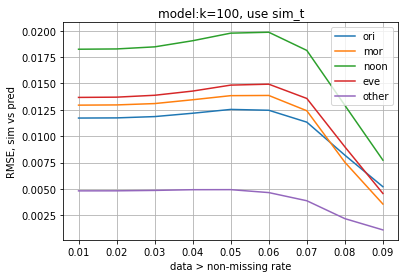

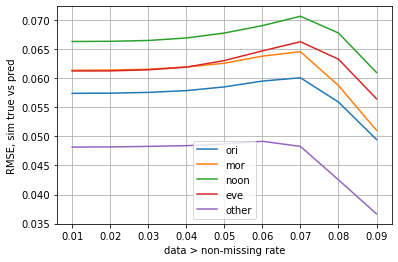

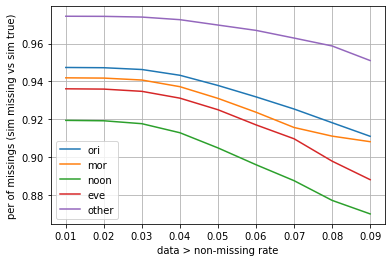

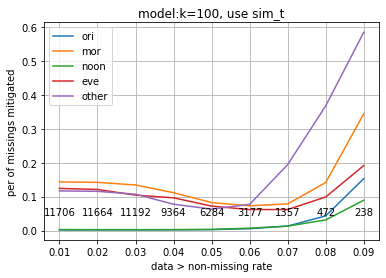

In [138]:
plot_paras(result_para_dict_simt_nmf_100, x_val_simt, 100, 'sim_t', ypop_simt)

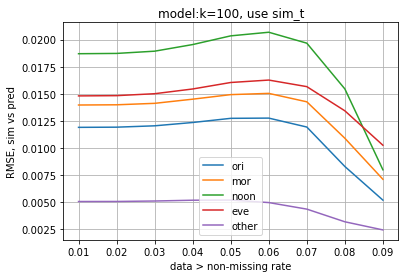

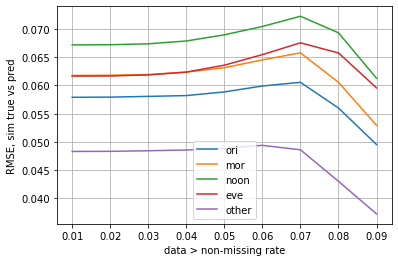

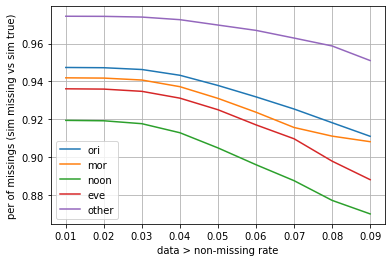

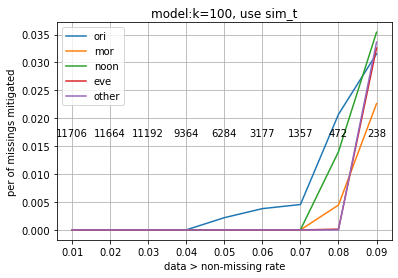

In [139]:
plot_paras(result_para_dict_simt_bmf_100, x_val_simt, 100, 'sim_t', ypop_simt)

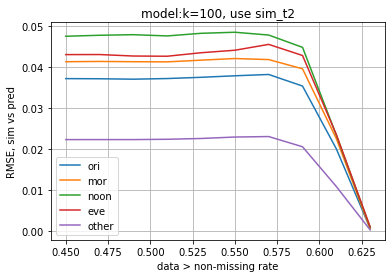

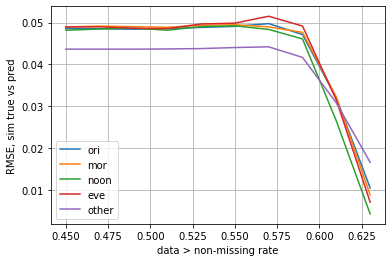

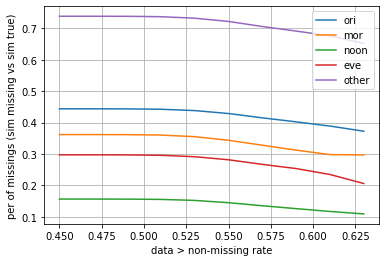

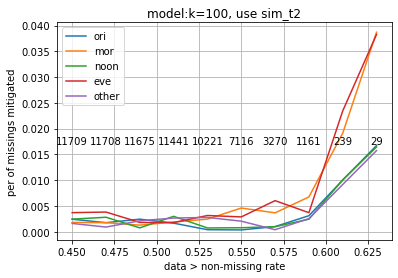

In [136]:
plot_paras(result_para_dict_simt2_bmf_100, x_val_simt2, 100, 'sim_t2', ypop_simt2)

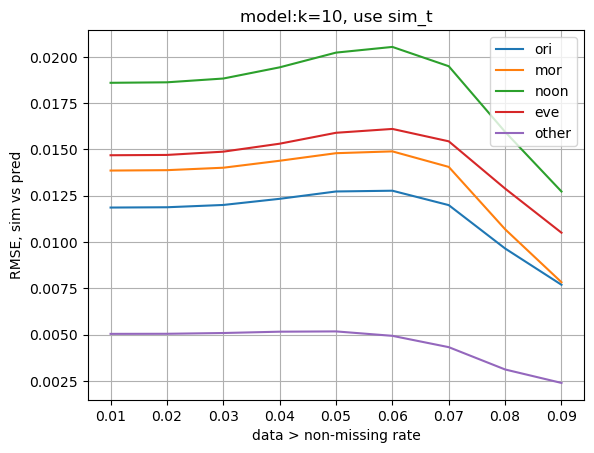

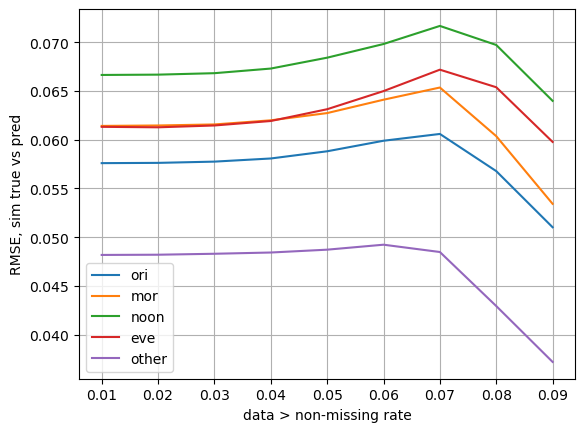

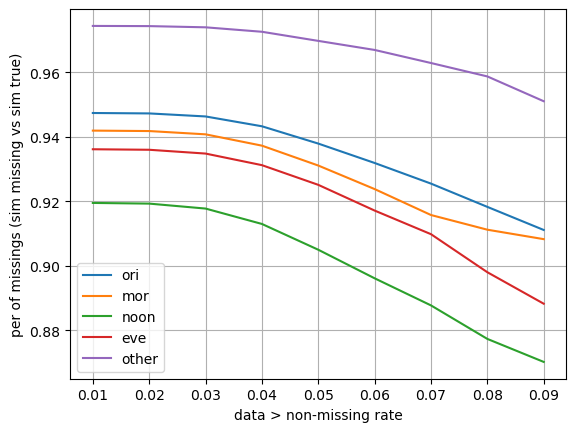

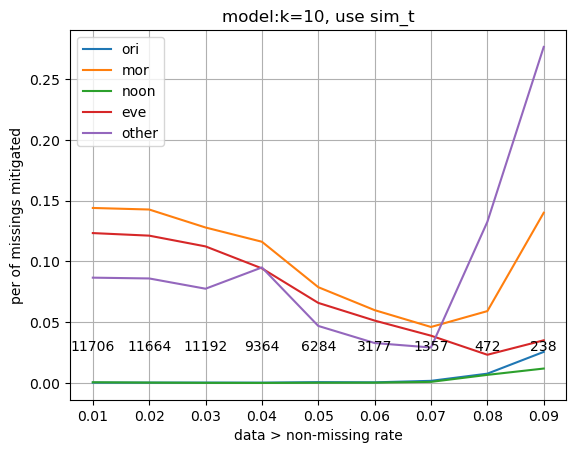

In [91]:
plot_paras(result_para_dict_simt, x_val_simt, 10, 'sim_t', ypop_simt)

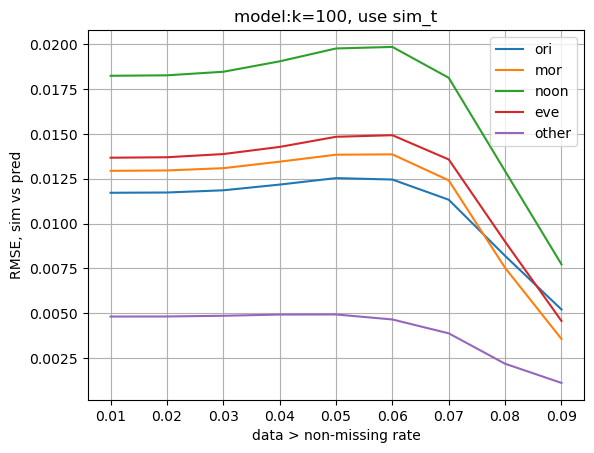

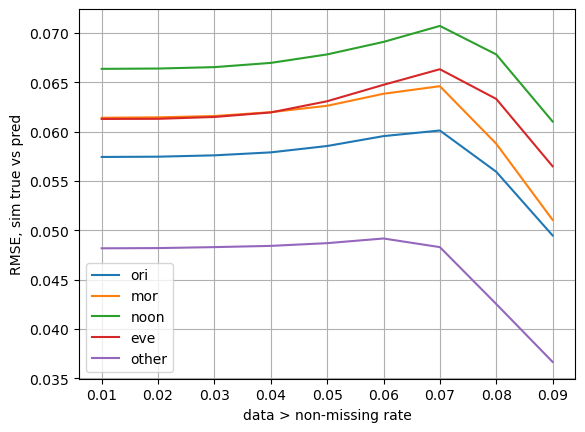

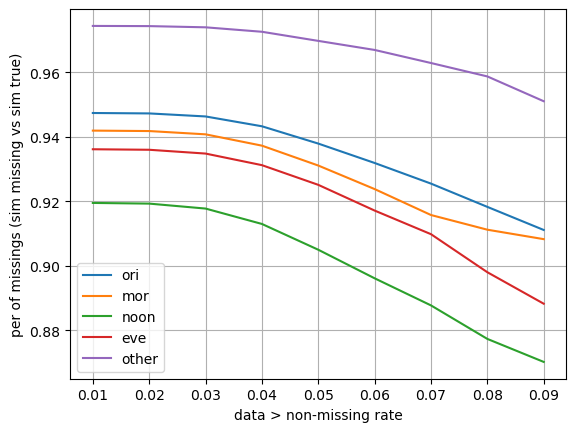

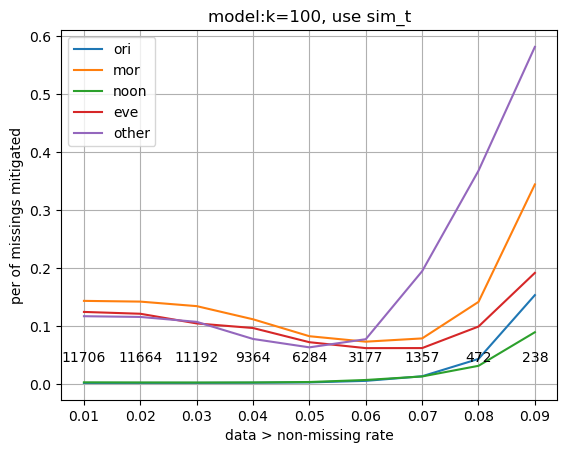

In [92]:
plot_paras(result_para_dict_simt_100, x_val_simt, 100, 'sim_t', ypop_simt)

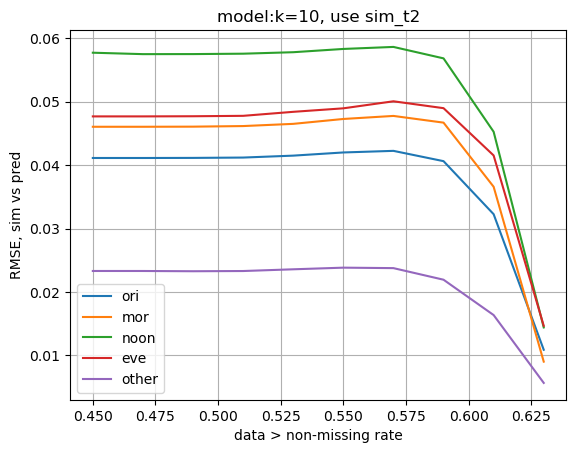

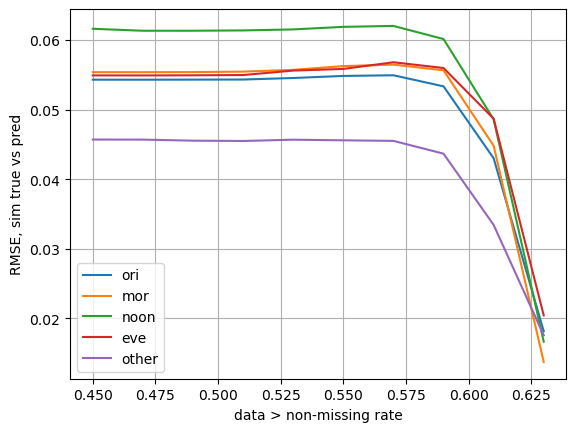

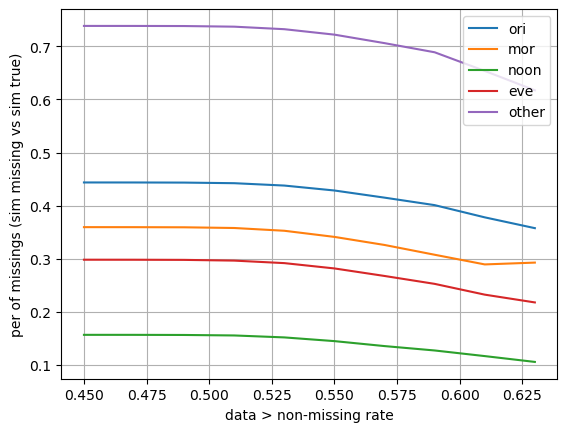

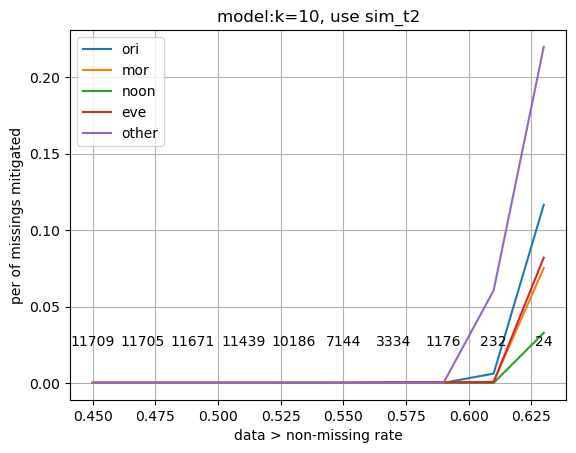

In [93]:
plot_paras(result_para_dict_simt2, x_val, 10, 'sim_t2', ypop_simt2)

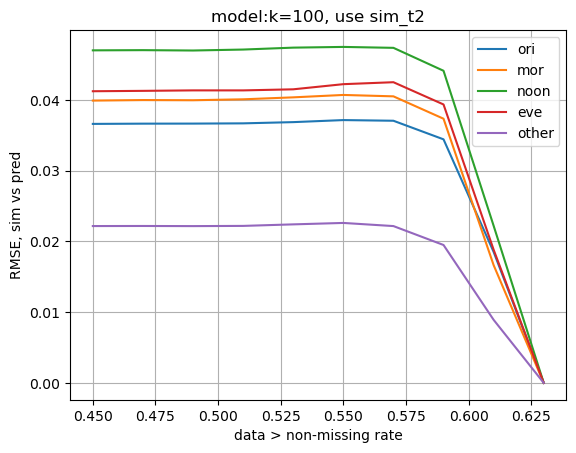

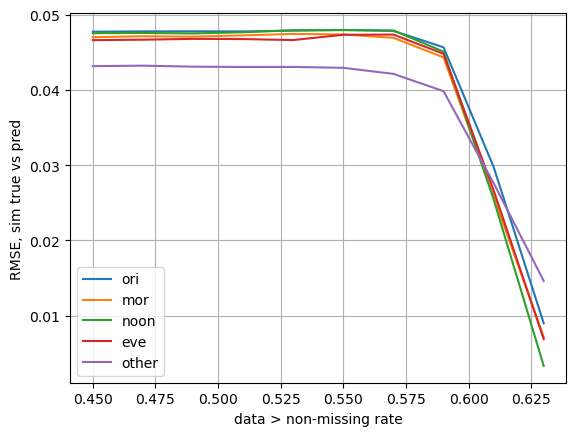

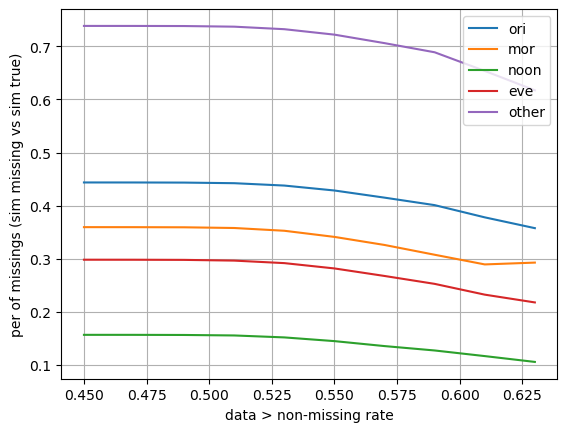

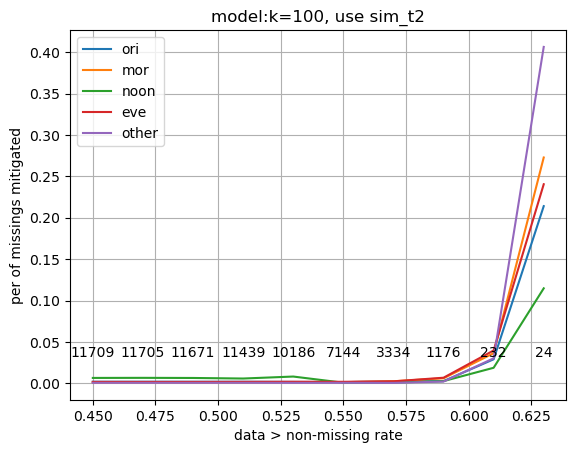

In [94]:
#plot_paras(result_para_dict_simt_100, x_val, 100, 'sim_t')
plot_paras(result_para_dict_simt2_100, x_val, 100, 'sim_t2', ypop_simt2)

In [137]:
#save_result_dict(result_para_dict_simt, "result_para_dict_simt_k10.txt")
#save_result_dict(result_para_dict_simt_bmf_100, "result_para_simt_k100_bmf.txt")
#save_result_dict(result_para_dict_simt_nmf_100, "result_para_simt_k100_nmf.txt")
save_result_dict(result_para_dict_simt2_bmf_100, "result_para_simt2_k100_bmf.txt")

In [ ]:
#data
result_para_dict_simt ={'ori': {'rmse_predvssim': [0.007690334758278416,
   0.011861481770917106,
   0.011877536296354201,
   0.012001591648297517,
   0.012333412474008829,
   0.012729749571966173,
   0.012770963765824813,
   0.011992614263893142,
   0.009650150431630694],
    'rmse_predvstrue': [0.051016427193137544,
   0.057591293538391555,
   0.05761897340150735,
   0.057746840221452135,
   0.05806906215263047,
   0.05880726664682562,
   0.059887635174768555,
   0.060584920113530394,
   0.05677436238546328],
    'per of missings (sim missing vs sim true)': [0.911108193277311,
   0.9473901679100936,
   0.9472590758840116,
   0.946319543721706,
   0.9432730700318003,
   0.9379050189193012,
   0.931887830937642,
   0.9254866740358634,
   0.9182703625235404],
    'per of missings mitigated': [0.02562008614753967,
   0.00036099353686940016,
   0.00036045797961888244,
   0.00036554165076642446,
   0.0003199875464306254,
   0.000742306085790553,
   0.0005793668013440371,
   0.0018053885179502066,
   0.007714738916571868]},                   
    'mor': {'rmse_predvssim': [0.007828231347560718,
   0.013859302799877782,
   0.01388070242604708,
   0.014012703450132393,
   0.014389104925496029,
   0.01479752473155533,
   0.014895481608422963,
   0.014056608880928344,
   0.010688582884434163],  
     'rmse_predvstrue': [0.053418281987026695,
   0.061409481654068586,
   0.06145347607074007,
   0.061559866704815516,
   0.0619822568105651,
   0.06272493392831388,
   0.06409554392871193,
   0.06534559487715583,
   0.060358234150394596],
       'per of missings (sim missing vs sim true)': [0.9082633053221288,
   0.9419291151736052,
   0.941791457094955,
   0.9407736676991502,
   0.9372626845127913,
   0.9310948440483768,
   0.9237925366348407,
   0.9157455170719725,
   0.9111935028248588],
      'per of missings mitigated': [0.14006682086867128,
   0.1439850457495264,
   0.14271409136655355,
   0.12791749879303205,
   0.11620325679289772,
   0.07883742570120968,
   0.05994926932687211,
   0.04611498569384836,
   0.05916166117677453]},
'noon': {'rmse_predvssim': [0.012727082029697806,
   0.018599294114145782,
   0.018625756960884653,
   0.018830281157937768,
   0.01943439020966053,
   0.020230021374531098,
   0.0205370567774557,
   0.019494547469498524,
   0.015948706624935666],
           'rmse_predvstrue': [0.06397895272199196,
   0.06663463440471604,
   0.06666683229718667,
   0.06681604334763545,
   0.06729071592148717,
   0.06840617573166134,
   0.06980675343678953,
   0.0716626726709641,
   0.06970939212550449],
   'per of missings (sim missing vs sim true)': [0.8701855742296919,
   0.9194973019534142,
   0.919286908436214,
   0.9177500297831784,
   0.9129778940623665,
   0.904978583174199,
   0.8961185867170286,
   0.8877118644067796,
   0.8773172669491526],
  'per of missings mitigated': [0.011920329946685444,
   0.0006290470711084486,
   0.00034875836194317667,
   0.00016226193132263758,
   9.503896597605019e-05,
   0.00025826966650242426,
   0.0003292976082017058,
   0.0009511950468679741,
   0.006716474228360123]},
 'eve': {'rmse_predvssim': [0.010502100208879794,
   0.014686795660785661,
   0.014703299983863547,
   0.014880110096300274,
   0.015310394182962388,
   0.015899886455230366,
   0.016107691438151106,
   0.015438681984233605,
   0.012885753461279553],
  'rmse_predvstrue': [0.059767333535504445,
   0.06131457613238765,
   0.06126603262672687,
   0.06145329045786582,
   0.06191236456627443,
   0.06312067571611471,
   0.06497919622359812,
   0.06717567682473358,
   0.06537460640518673],
     'per of missings (sim missing vs sim true)': [0.888235294117647,
   0.9361450782260623,
   0.9359861845972957,
   0.9348080261411212,
   0.9312137670104351,
   0.9251068473219969,
   0.9171275686856424,
   0.909801031687546,
   0.8980024213075061],
  'per of missings mitigated': [0.035139883768076766,
   0.12332745836244746,
   0.12121997241610334,
   0.11237004448595374,
   0.09430005635722617,
   0.06590716967778718,
   0.051363012355363794,
   0.038948415912614845,
   0.023255813953488372]},
'other': {'rmse_predvssim': [0.00238980846981346,
   0.0050391726058245725,
   0.00504378203699889,
   0.005085500808195335,
   0.005156913382794126,
   0.005172363428812574,
   0.004933129317534506,
   0.004321308784059673,
   0.003116114595040795],
  'rmse_predvstrue': [0.0372070395469539,
   0.04817776021159453,
   0.04820066095892989,
   0.048298424827468475,
   0.048426473670651636,
   0.04871799070733817,
   0.04922779459510219,
   0.04847803607771668,
   0.042936930492251904],
'per of missings (sim missing vs sim true)': [0.951038266546288,
   0.9743975329455968,
   0.974339353127232,
   0.9739660560376656,
   0.9725853541433519,
   0.9697565902646628,
   0.9669447501021027,
   0.9628921356663033,
   0.9587302143157305],
'per of missings mitigated': [0.27643493500803273,
   0.0866651885793117,
   0.08601381107795056,
   0.07757608932990441,
   0.09505327673228782,
   0.0469656941988261,
   0.03289661295095639,
   0.029221272074077823,
   0.13260889416491645]}}

result_para_dict_simt2 = {'ori' : {'rmse_predvssim': [
   0.04113807471040142,
   0.041164117749803227,
   0.04127143536381266,
   0.041567190570421526,
   0.04218157313979382,
   0.04286957179349329,
   0.04314950697886612,
   0.03977831916975735,
   0.03485291636914015],
   'rmse_predvstrue': [
   0.05431287678026451,
   0.05435014557879387,
   0.05448716410273881,
   0.05484531430515014,
   0.05568600774637898,
   0.056898355548439354,
   0.05785064294057926,
   0.0542894822785923,
   0.048350428694050526],                                
  'per of missings (sim missing vs sim true)': [
   0.4435424260113522,
   0.44352220983843926,
   0.44348021404177584,
   0.44300497769234415,
   0.4418435930758894,
   0.44063341552128144,
   0.43869493572422824,
   0.433674670433145,
   0.430015756302521],                               
  'per of missings mitigated': [
   2.6081251793086062e-05,
   2.5505170166468218e-05,
   3.4278486821670716e-05,
   5.440650869248604e-05,
   5.377386215132965e-05,
   4.216594033767477e-05,
   3.499582966363175e-05,
   0.0005597774460578097,
   0.001289228159457167]},                       
   'mor': {'rmse_predvssim': [
   0.04597298172474255,
   0.04601717229809827,
   0.046144403277808554,
   0.04660057885888863,
   0.047433923216744577,
   0.048615885076810215,
   0.04945095483562942,
   0.04432818987020974,
   0.03748786965187502],
   'rmse_predvstrue': [
   0.055399036920744674,
   0.05545326415940571,
   0.055584439135866526,
   0.0560854457813578,
   0.057016758976203744,
   0.05866908260866102,
   0.060247286692762074,
   0.05547474858257091,
   0.0486262611766219],
   'per of missings (sim missing vs sim true)': [   
   0.3610636520682651,
   0.36104681069958844,
   0.36098453260265273,
   0.35986223835967535,
   0.35826879553009405,
   0.35694925331374816,
   0.3531073446327684,
   0.3481638418079096,
   0.35049019607843135],
   'per of missings mitigated': [
   5.914904244272401e-05,
   5.936479667557139e-05,
   5.500360961188078e-05,
   4.945965328783045e-05,
   8.636750607657096e-05,
   7.348438456827924e-05,
   0.00017391304347826088,
   0.0005070993914807302,
   0.001665001665001665]},
 'noon': {'rmse_predvssim': [   
   0.05771133952731652,
   0.05752131332133793,
   0.057696402312049665,
   0.05826518868888879,
   0.059471278306711256,
   0.06113525305211396,
   0.06310008390125588,
   0.060859934607045016,
   0.05500693672224737],
   'rmse_predvstrue': [
   0.061613797851948586,
   0.06136875646013456,
   0.06155764213847834,
   0.062160208861244,
   0.0634247441808637,
   0.06523004889329768,
   0.06755932976446813,
   0.06579333521670577,
   0.06027021135687914],
'per of missings (sim missing vs sim true)': [
   0.15658369639501113,
   0.1565429240969365,
   0.15644824428162973,
   0.1560519898903603,
   0.15510622215149583,
   0.15412535410764872,
   0.15278801277327436,
   0.14740024717514122,
   0.14784663865546221],

   'per of missings mitigated': [
   7.956127639019123e-05,
   0.0001597371183423851,
   0.0001606253680998019,
   0.00017108395945310162,
   0.00014962060489473122,
   0.00012764056417129363,
   0.00010048231511254019,
   0.0002994460248540201,
   0.0014801657785671995]},

   'eve': {'rmse_predvssim': [
   0.04778408117262504,
   0.04764011329828683,
   0.04800422124918561,
   0.04851812369380867,
   0.049582772463760964,
   0.05134328993647618,
   0.05309201727423527,
   0.051402812871429435,
   0.04579020178523013],

  'rmse_predvstrue': [
   0.0551453194630221,
   0.054927172653105184,
   0.05538760865662916,
   0.05591716813559445,
   0.05707864368720805,
   0.05919619101862636,
   0.06168663692082968,
   0.06097255155453629,
   0.055411012288502565],
   'per of missings (sim missing vs sim true)': [
   0.2982353371897195,
   0.29829757005682933,
   0.2980955784744205,
   0.29774516384939276,
   0.29651268527780306,
   0.2938171680381312,
   0.29087272344457316,
   0.2889830508474577,
   0.28223289315726285],
   'per of missings mitigated': [
   0.00018004746705949752,
   0.00013959943174819548,
   0.00018840455596471695,
   0.00019470604511031634,
   0.00016867285133788238,
   0.0004897309540571148,
   0.00014477017734346723,
   0.00020946795140343527,
   0.0012760527435133986]},

  'other': {'rmse_predvssim': [
   0.02333749344820515,
   0.023349222593386593,
   0.02337498617324706,
   0.023339796774259253,
   0.023294053769046766,
   0.022940266313281808,
   0.021336176132825502,
   0.016983274665613873,
   0.013727346880013569],

   'rmse_predvstrue': [
   0.045554969162595,
   0.04557929714795551,
   0.04567460178028213,
   0.0457060480675748,
   0.04616244314046175,
   0.04675520401582132,
   0.046085124039845105,
   0.04040245722169883,
   0.034688090977294826],
  
   'per of missings (sim missing vs sim true)': [         
   0.7377822773657078,
   0.7377535172147967,
   0.7378056344850809,
   0.7374241423987065,
   0.7362408004587276,
   0.7353108733484731,
   0.7337527482231709,
   0.7280956716626978,
   0.7202930759080493],
   'per of missings mitigated': [
   8.61232481095947e-06,
   8.643673215369604e-06,
   9.00756635573882e-06,
   1.0771554478932037e-05,
   1.0717903006550425e-05,
   1.7688720963964538e-05,
   2.4900398406374503e-05,
   0.0004569174903205637,
   0.006267174468495396]}}

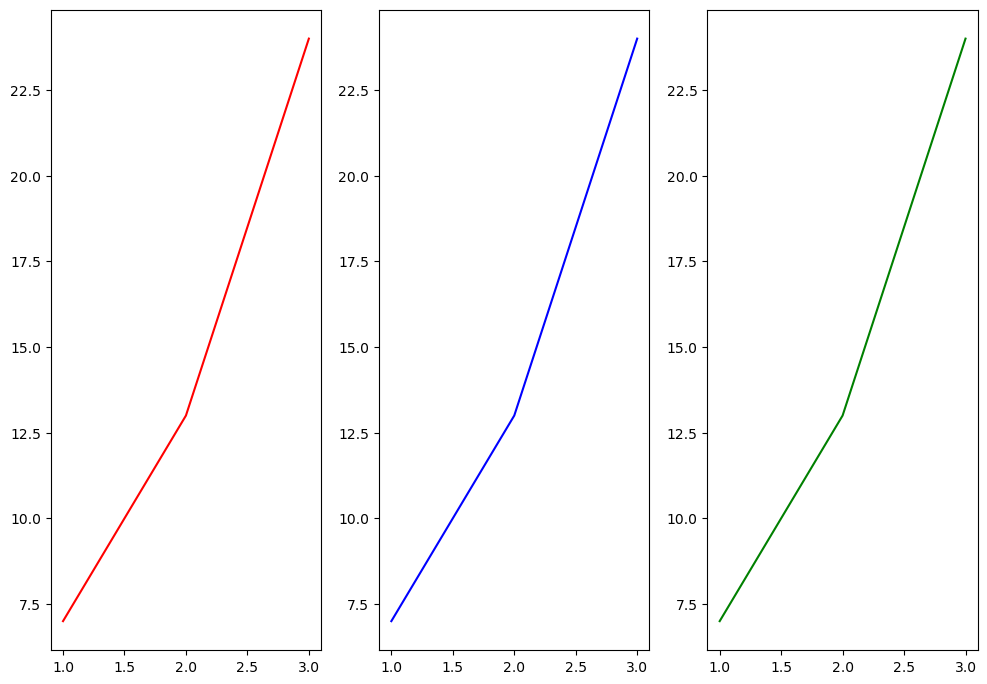

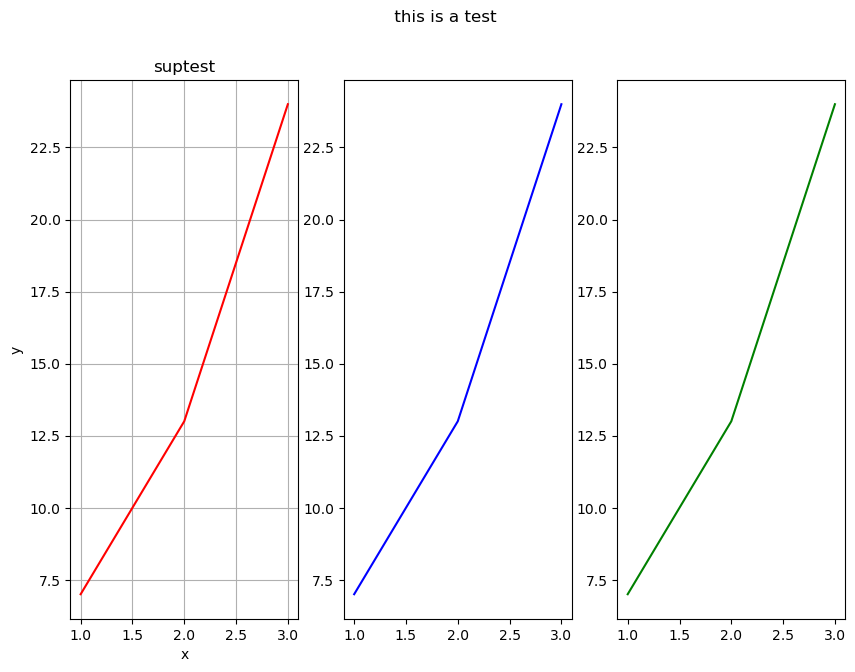

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(10,7))
fig.tight_layout()

#define data
x = [1, 2, 3]
y = [7, 13, 24]

#create subplots
ax[0].plot(x, y, color='red')
ax[1].plot(x, y, color='blue')
ax[2].plot(x, y, color='green')
#ax[1, 1].plot(x, y, color='purple')

fig, ax = plt.subplots(1, 3, figsize=(10,7))
#fig.tight_layout()

#define data
x = [1, 2, 3]
y = [7, 13, 24]

fig.suptitle(' this is a test ')
#create subplots
ax[0].plot(x, y, color='red')
ax[0].grid()
ax[0].set_title('suptest')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].plot(x, y, color='blue')
ax[2].plot(x, y, color='green')

In [30]:
k_val = 10

model = NMF(n_components=k_val, init='random', random_state=0)

W = model.fit_transform(sim_dt_all_wmiss)
H = model.components_

pred_dt = np.dot(W, H)

#pred vs. data with missings
model_rmse_wm = mean_squared_error(sim_dt_all_wmiss, pred_dt, squared=False)
#pred vs. true data
model_rmse_t = mean_squared_error(sim_dt_all, pred_dt, squared=False)

In [45]:
b.append(model_rmse_wm)

In [46]:
b.append(model_rmse_t)

num taz 174


num taz 174


num taz 174


0.5403461605982103

0.5396932144014379

In [62]:
mean_squared_error(WH_index_mis, WH_index_tru, squared=False)

30.116392508759784

In [56]:
np.unique(WH_index_tru)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173], dtype=int64)

In [57]:
np.unique(WH_index)

array([  5,   6,   7,   8,  14,  16, 109, 142, 150, 159, 164, 168, 169,
       170, 171, 172, 173], dtype=int64)

In [59]:
np.unique(WH_index_mis)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173], dtype=int64)

In [41]:
WH_index.shape

(11709, 288)

In [40]:
pred_dt[WH_index]

MemoryError: Unable to allocate 1.23 TiB for an array with shape (11709, 288, 50112) and data type float64

In [14]:
a = np.zeros((3,5))
for i in range(a.shape[0]):
    a[i, np.random.choice(list(range(5)))] = 1


In [206]:
type(a[np.where(a>0)])

numpy.ndarray

In [210]:
np.random.choice(list(range(non_zero_loc.shape[1])),size=int((non_zero_loc.shape[1])*missing_rate))

array([2793795,  202994, 2887327, ...,  506640, 2225479, 1055212])

In [167]:
#def fit_process_dt_nmf(sim_dt, missing_info, missing_val, k_val): 
    #predict data based on time



del(W, H)
print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val), model_rmse) 

array([    0, 31676], dtype=int64)

In [168]:
np.where(sim_dt_all>0)

(array([    0,     0,     0, ..., 11708, 11708, 11708], dtype=int64),
 array([31676, 32896, 33026, ..., 48957, 48958, 48959], dtype=int64))

In [141]:
###csv 2 fit data using r, 
###r dir: G:/My Drive/2021/Bias/PSRC_od_simulation_2018/ts_data_correlation.R
taz_time = fcd_dt.groupby(by=['taz', 'time_5_new']).size().to_frame()
taz_time.reset_index(inplace=True)
taz_time.columns = ['taz', 'time_5_new', 'num']

taz_time = taz_time[taz_time['taz']<=1000]
taz_dict = {}
idx = 0
for i in np.unique(taz_time.taz):
    #print(i)
    if i not in taz_dict:
        taz_dict[i] = idx
        idx+=1
        
get_tazid = lambda x: taz_dict[x]
taz_time['taz_id'] = taz_time['taz'].apply(get_tazid)
taz_total = ((fcd_dt[fcd_dt['taz']<1000]).groupby(by=['taz','reids']).size().to_frame()).groupby(by=['taz']).size().to_frame()
sum_val_sim = taz_total[0].values

origin_dt = pd.read_csv('../data-1670309862526.csv')
origin_dt.columns
sum_val_cuebiq = (origin_dt.groupby(by=['taz','newid']).size().to_frame()).groupby(by=['taz']).size().to_frame()
sum_val_cuebiq = sum_val_cuebiq[0].values

origin_dt = pd.read_csv('../data-1670309862526.csv')
get_time_5 = lambda x: int(x.split(':')[0])*12+int((int(x.split(':')[1]))/5)
origin_dt['time_5'] = origin_dt['time'].apply(get_time_5)

origin_dt = origin_dt.groupby(by=['taz','time_5']).size().to_frame()
origin_dt.reset_index(inplace=True)
origin_dt.columns = ['taz','time_5', 'num']

taz_dict = {}
idx = 0
for i in np.unique(origin_dt.taz):
    if i not in taz_dict:
        taz_dict[i] = idx
        idx += 1
origin_dt['taz_id'] = origin_dt['taz'].apply(get_tazid)

def convert_2mx(df, taz_col, time_col, val_col, sums_):
    origin_mx = np.zeros((len(np.unique(df[taz_col])), len(np.unique(df[time_col]))))
    for i in range(df.shape[0]):
        origin_mx[df[taz_col][i], df[time_col][i]] = df[val_col][i]
        
    num_taz = len(np.unique(df[taz_col]))
    taz_ = np.unique(df['taz']).reshape(num_taz, 1)
    sums_ = sums_.reshape(num_taz, 1)
    return(np.hstack((taz_, origin_mx, sums_)))

taz_time = convert_2mx(taz_time, 'taz_id', 'time_5_new', 'num', sum_val_sim)
origin_dt = convert_2mx(origin_dt, 'taz_id', 'time_5', 'num', sum_val_cuebiq)

#taz_time.to_csv('sim_taz_num.csv')
#origin_dt.to_csv('cuebiq_num.csv')
pd.DataFrame(taz_time).to_csv('sim_taz_num.csv')
pd.DataFrame(origin_dt).to_csv('cuebiq_num.csv')

In [ ]:
#algorithm, nmf test
WH_ts = fit_dt(fcd_dt, 'sim_t', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_100_ht10per_withstay.csv')
#pd.DataFrame(WH_index).to_csv('WH_index_t_100_ht10per_withstay.csv')
#del(WH_ts, WH_max, WH_index)

WH_ts = fit_dt01(fcd_dt, 'sim_ts', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_100_ht10per_withstay_01.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_100_ht10per_withstay_01.csv')
del(WH_ts, WH_max, WH_index)

fit_dtbytime_stay(fcd_dt, 'sim_t', 12, 100, '100t_ht10per01')

fit_dtbytime_stay(fcd_dt, 'sim_ts', 12, 100, '100ts_ht10per01')

In [ ]:
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)

#algorithm, nmf test
WH_ts = fit_dt(fcd_dt, 'sim_t', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_100_all10pe_withstay.csv')
pd.DataFrame(WH_index).to_csv('WH_index_t_100_all10pe_withstay.csv')
del(WH_ts, WH_max, WH_index)

WH_ts = fit_dt(fcd_dt, 'sim_ts', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_100_all10pe_withstay.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_100_all10pe_withstay.csv')
del(WH_ts, WH_max, WH_index)

fit_dtbytime_stay(fcd_dt, 'sim_t', 12, 100, '100t_all10pe')

fit_dtbytime_stay(fcd_dt, 'sim_ts', 12, 100, '100ts_all10pe')

### Surprise application

In [2]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise import SVDpp
from surprise import get_dataset_dir, dump
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise import NormalPredictor
#from surprise import NMF

In [27]:
#from surprise import BMF

In [10]:
#check similarity
len(np.unique(fcd_dt['reids']))

11709

In [11]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(fcd_dt[['id_index', 'ts_index', 'sim_t']], 
                            reader=reader)

In [12]:
train = data.build_full_trainset()
#test = data.build_anti_testset()

In [13]:
train.n_users

11709

In [14]:
train.n_items

49052

In [272]:
algo = NormalPredictor()
algo.fit(train)
predictions = algo.test(train.build_testset())
accuracy.rmse(predictions)

RMSE: 0.2631


0.263052824716942

In [273]:
algo = SVD()
algo.fit(train)
predictions = algo.test(train.build_testset())
accuracy.rmse(predictions)
del(predictions)

RMSE: 0.2012


0.20116639097274144

In [281]:
algo = KNNBaseline()
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1949


0.19494840144804554

In [17]:
#similarities between items
sim_options = {'name': 'cosine',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.1554


0.15539946341857047

In [18]:
#similarities between items
sim_options = {'name': 'pearson',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1386


0.13862897242064817

In [19]:
#'MSD'
algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1386


0.13862897242064817

In [51]:
#similarities between items
sim_options = {'name': 'pearson_baseline',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1237


0.12368558609025071

In [50]:
for i in (fcd_dt[(fcd_dt['id_index']==0)&(fcd_dt['sim_t']==1)]).ts_index:
    print(algo.predict(0, i, verbose=True))

user: 0          item: 48672      r_ui = None   est = 0.98   {'actual_k': 40, 'was_impossible': False}
user: 0          item: 48672      r_ui = None   est = 0.98   {'actual_k': 40, 'was_impossible': False}
user: 0          item: 39539      r_ui = None   est = 0.90   {'actual_k': 5, 'was_impossible': False}
user: 0          item: 39539      r_ui = None   est = 0.90   {'actual_k': 5, 'was_impossible': False}
user: 0          item: 39545      r_ui = None   est = 0.33   {'actual_k': 21, 'was_impossible': False}
user: 0          item: 39545      r_ui = None   est = 0.33   {'actual_k': 21, 'was_impossible': False}
user: 0          item: 39546      r_ui = None   est = 0.53   {'actual_k': 13, 'was_impossible': False}
user: 0          item: 39546      r_ui = None   est = 0.53   {'actual_k': 13, 'was_impossible': False}
user: 0          item: 39575      r_ui = None   est = 0.57   {'actual_k': 14, 'was_impossible': False}
user: 0          item: 39575      r_ui = None   est = 0.57   {'actual_k': 1

In [ ]:
#using BMF
#import numpy as np
from sklearn.decomposition import NMF

# Load the data into a Numpy array
#ratings = np.loadtxt('ratings.csv', delimiter=',')

# Create the user-item matrix
user_item_matrix = np.zeros((num_users, num_items))
for i in range(ratings.shape[0]):
    user_item_matrix[ratings[i, 0]-1, ratings[i, 1]-1] = ratings[i, 2]

# Initialize the NMF model with binary options
model = NMF(n_components=k, init='random', random_state=0, solver='cd', beta_loss='binary_reconstruction')

# Fit the model to the user-item matrix
W = model.fit_transform(user_item_matrix)
H = model.components_

# Predict the ratings for the test set
predictions = np.dot(W, H)
